Summary: Occurences of differences were observed for different ranges of feature LSTAT, which is mainly responsible for the differences.
- For values between 3.5 and 11.6 A may predict 1 while B predicts 2, 
- for values between 6.0 and 7.5 A may predict 2 while B predicts 1, 
- for values between 10.4 and 14.9 A may predict 0 while B predicts 1
- for values between 16.3 and 16.8 A may predict 1 while B predicts 0.

Aggregate ranges, where differences where found:
- $(0,1)$: $10.4 < LSTAT < 14.9, ZN=0, 13.8 < INDUS, CRIM < 3.9, RM < 6.4, 1 ≤ AGE ≤ 2, DIS < 3.2$, the mainly responsible feature being LSTAT.
- $(1,0)$: $16.3 < LSTAT < 16.8, ZN=0, INDUS=8.14, CRIM < 0.9, RM < 5.7, RAD=4, TAX=307, AGE=2, DIS=4.5, PTRATIO=21$, the mainly responsible feature being LSTAT.
- $(1,2)$:
    - $9.4 < LSTAT < 9.8, ZN=20, INDUS=3.97, RM=7.23, RAD=5, TAX=264, AGE=1, DIS=2.12, PRATIO=13$, the mainly responsible feature being LSTAT.
    - $3.5 < LSTAT < 11.6, 60 ≤ ZN ≤ 90, INDUS < 4.2, CRIM < 0.2, 5.9 < RM < 7.1, RAD ≤ 4, 285 ≤ TAX ≤ 411, 7.3 < DIS$, the mainly responsible feature being LSTAT.
- $(2,1)$: $6.0 < LSTAT < 7.5, ZN = 0, 11.9 < INDUS < 18.2, CRIM < 4.6, RM < 6.8, 273 ≤ TAX, AGE = 2, 1.6 < DIS < 2.4$, the mainly responsible feature being LSTAT.

Full explanations per cluster:
- $(0,1)$
    - Cluster: $10.5 < LSTAT, ZN ≤ 12.5, 4 < INDUS, RM < 6.9$ (108 instances)
        - Differences: $LSTAT < 14.2, ZN=0, 13.8 < INDUS < 19.6, CRIM < 3.9, RM < 6.4, 1 ≤ AGE ≤ 2, DIS < 3.2$ (3 instances)
        - Counterfactuals:
            - $LSTAT=14.9 \rightarrow (0,0)$
            - $LSTAT=10.4 \rightarrow (1,1)$
- $(1,0)$
    - Cluster: $10.5 < LSTAT < 21.9, ZN ≤ 12.5, 4 < INDUS, CRIM < 7.2, RM < 6.5$ (54 instances)
        - Differences: $16.4 < LSTAT < 16.6, ZN=0, INDUS=8.14, CRIM < 0.9, RM < 5.7, RAD=4, TAX=307, AGE=2, DIS = 4.5, PTRATIO=21$ (2 instances)
        - Counterfactuals:
            - $LSTAT=16.8 \rightarrow (0,0)$
            - $LSTAT=16.3 \rightarrow (1,1)$
- $(1,2)$
    - Cluster: $8.2 < LSTAT < 13.2, ZN ≤ 55, INDUS < 15.1, RM < 7.3, RAD ≤ 8, TAX ≤ 430, 2.1 < DIS < 8.0$ (20 instances)
        - Differences: $LSTAT=9.52, ZN=20, INDUS=3.97, RM=7.23, RAD=5, TAX=264, AGE=1, DIS=2.12, PRATIO=13$ (1 instance)
        - Counterfactuals:
            - $LSTAT=9.8 \rightarrow (1,1)$
            - $LSTAT=9.4 \rightarrow (2,2)$
    - Cluster: $LSTAT < 10.0, INDUS < 19.6$ (116 instances)
        - Differences: $5.4 < LSTAT < 7.9, 60 ≤ ZN ≤ 90, INDUS < 4.2, CRIM < 0.2, 5.9 < RM < 7.1, RAD ≤ 4, 285 ≤ TAX ≤ 411, 7.3 < DIS$ (4 instances)
        - Counterfactuals:
            - $LSTAT=11.6 \rightarrow (1,1)$
            - $LSTAT=3.5 \rightarrow (2,2)$
- $(2,1)$
    - Cluster: $LSTAT < 10.9, INDUS < 19.6, CRIM < 9.3$ (127 instances)
        - Differences: $6.4 < LSTAT < 7.2, ZN = 0, 11.9 < INDUS < 18.2, CRIM < 4.6, RM < 6.8, 273 ≤ TAX, AGE = 2, 1.6 < DIS < 2.4$ (2 instances)
        - Counterfactuals:
            - $LSTAT=7.5 \rightarrow (1,1)$
            - $LSTAT=6.0 \rightarrow (2,2)$

In [28]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
import xgboost
from sklearn.metrics import classification_report
from comparers import ModelComparer
from sklearn.model_selection import StratifiedKFold, train_test_split
from helper_models import LogProbabilityMixin
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from clustering import make_clustering
from tasks.boston_housing import make_task4 as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
shap.initjs()

In [3]:
try:
    with open('shap.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = pickle.load(f)
    is_pred_diff = comparer.predict_bin_diff(explanations.data)
    mclass_diff = comparer.predict_mclass_diff(explanations.data)
    global_feature_order, _ = calc_feature_order(explanations.mclass_diff.log_odds)
except FileNotFoundError:
    pass

# Setup Task

In [29]:
clf_a, clf_b, X, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


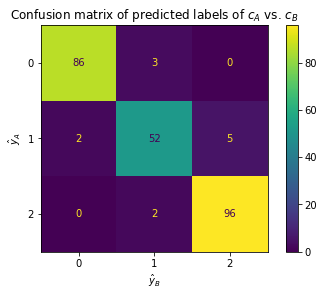

In [6]:
comparer.plot_confusion_matrix(X)

In [8]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open('shap.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 247it [00:28,  6.70it/s]                         
Permutation explainer: 247it [00:17,  5.94it/s]                         
Permutation explainer: 247it [00:46,  4.02it/s]                         

CPU times: user 2min 12s, sys: 13 s, total: 2min 25s
Wall time: 1min 32s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [9]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

In [10]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

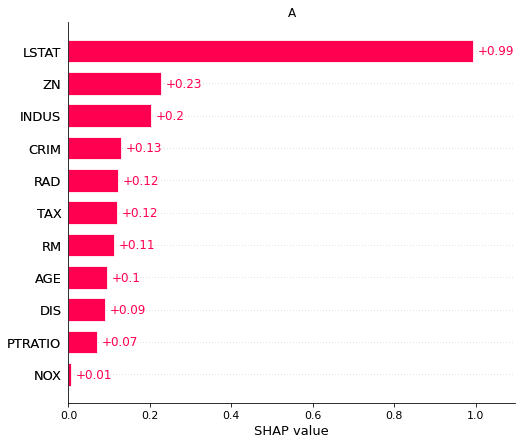

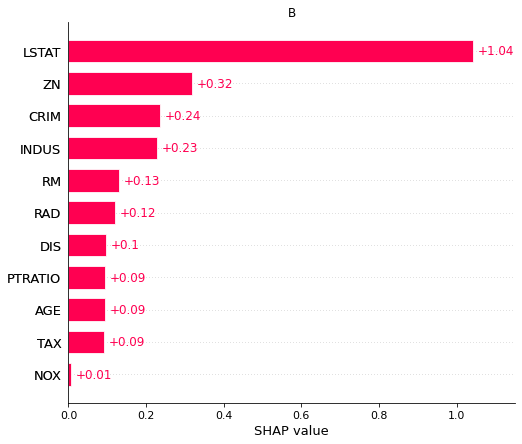

In [11]:
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.A)
plot_feature_importance_bar(feature_importances, 'A')
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.B)
plot_feature_importance_bar(feature_importances, 'B')

In [12]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)

In [13]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_effects_comparison(color=is_pred_diff,
                                    **{'A': explanations.indiv.log_odds.A[:, [feature_idx]],
                                       'B': explanations.indiv.log_odds.B[:, [feature_idx]]})
it = iter(feature_order)

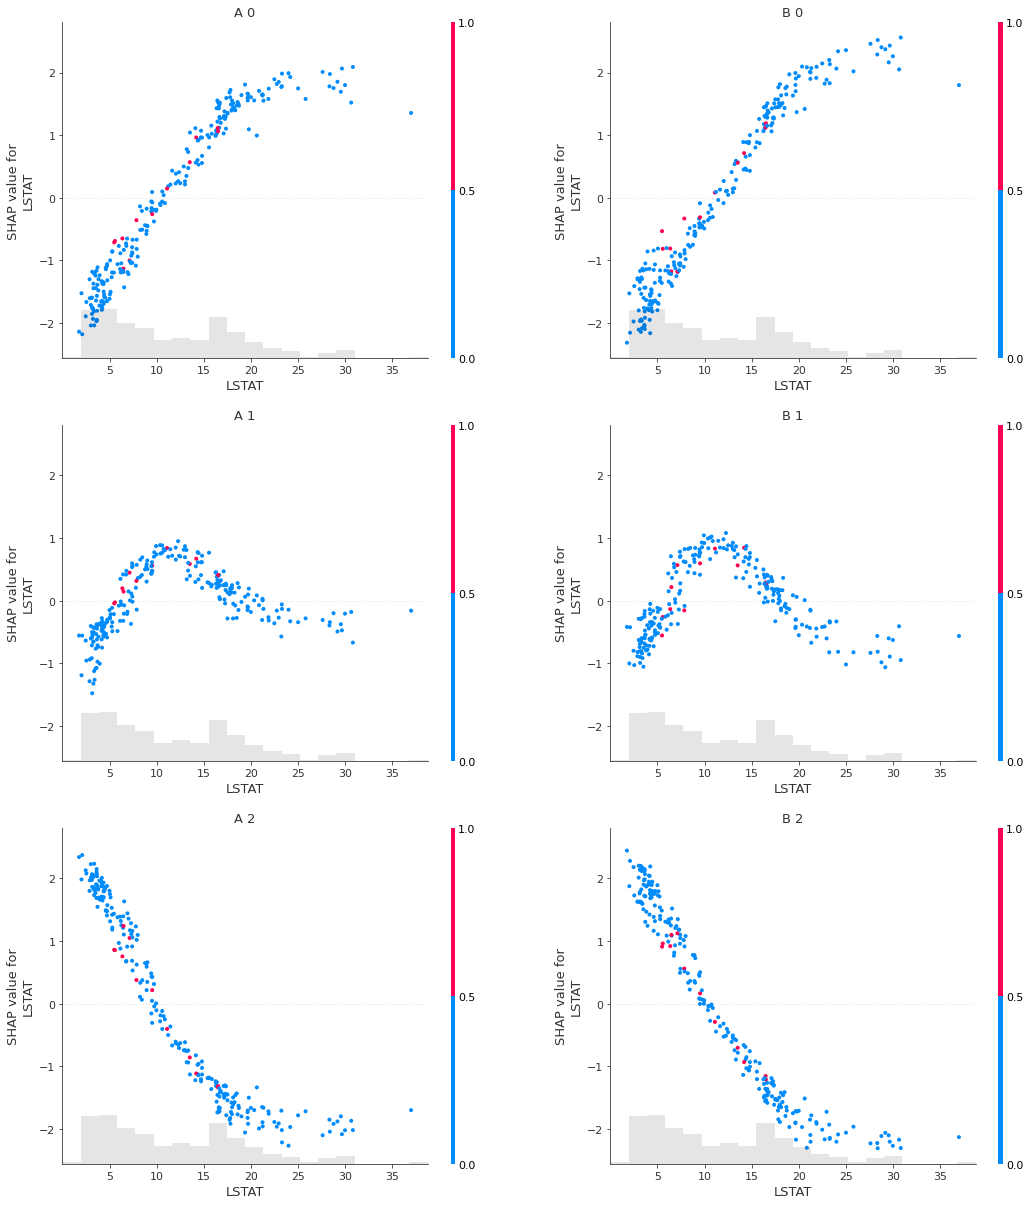

In [14]:
plot_next_feature()

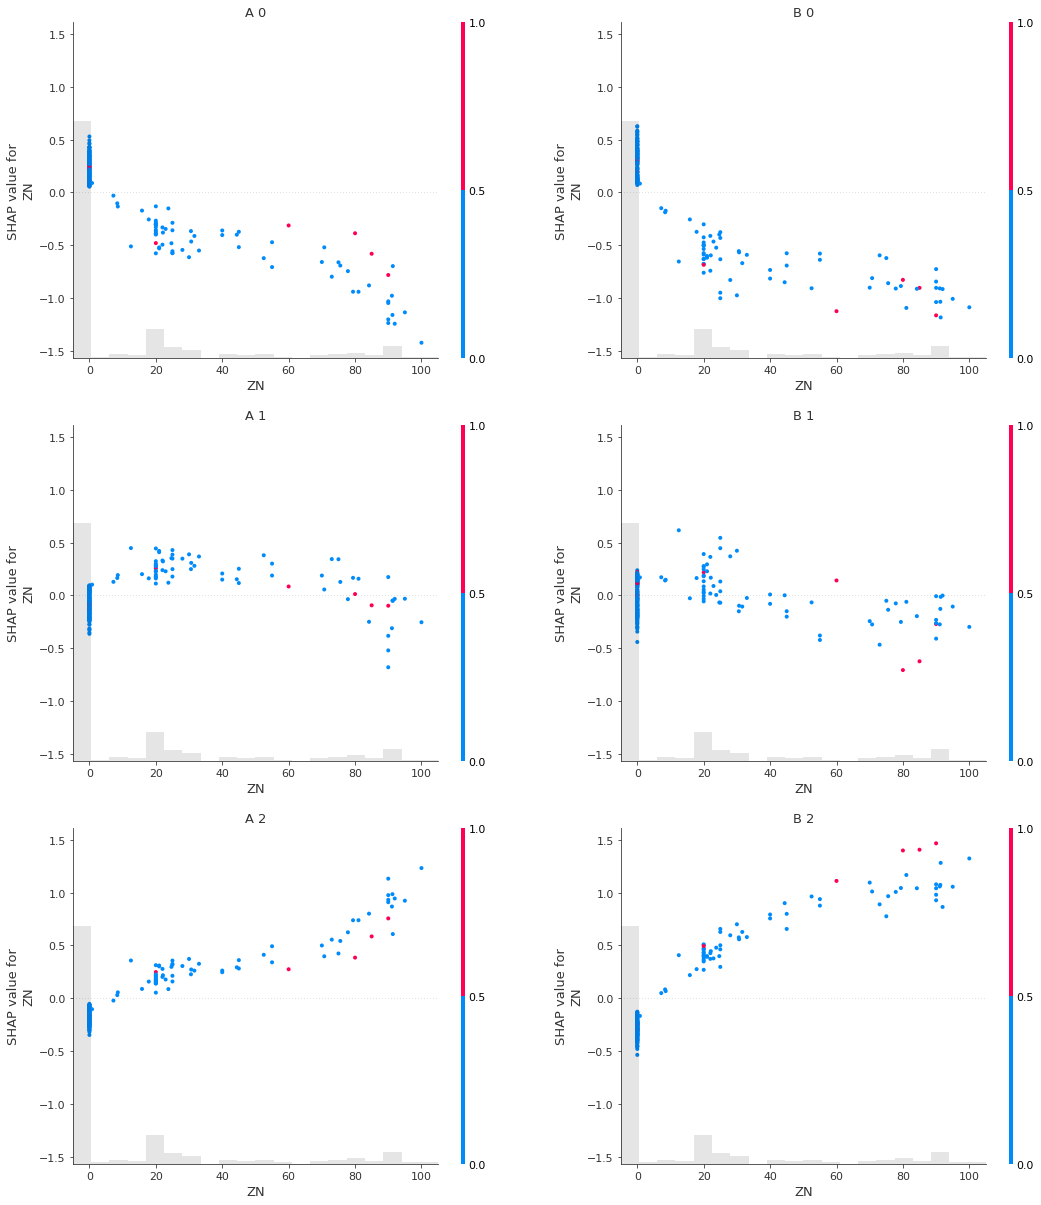

In [15]:
plot_next_feature()

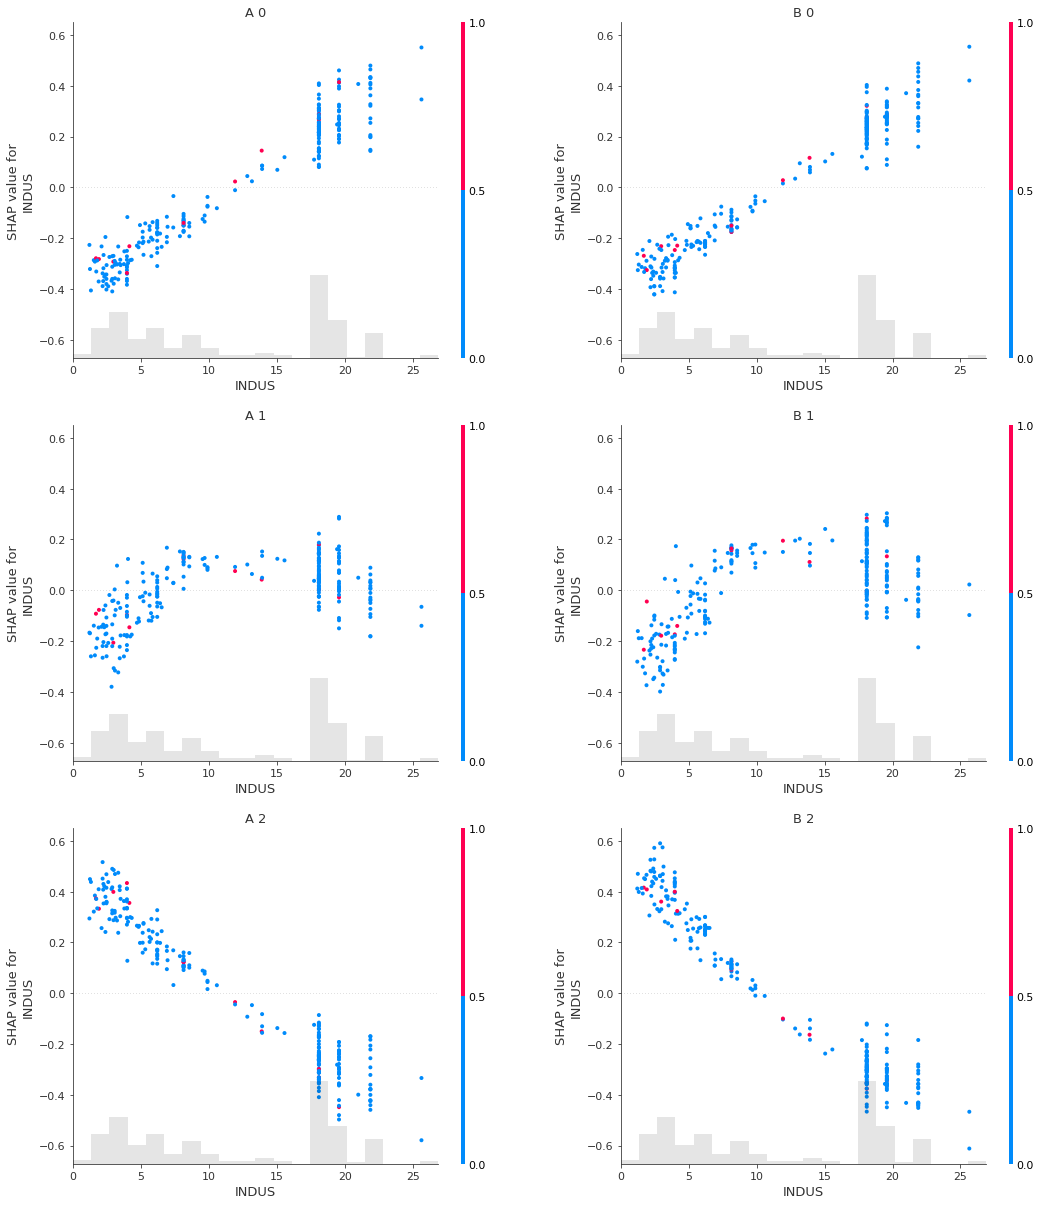

In [16]:
plot_next_feature()

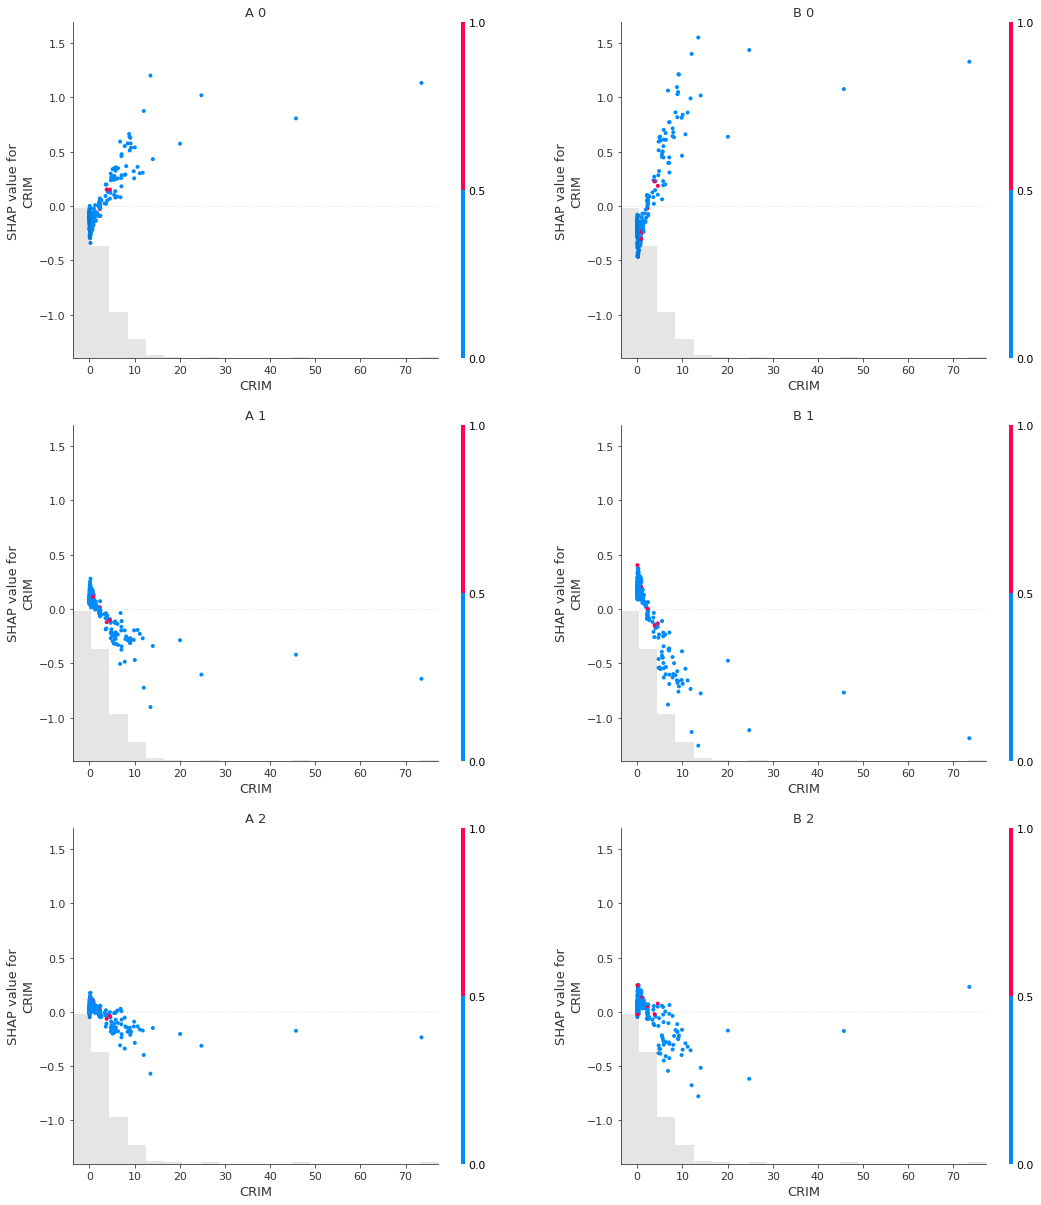

In [17]:
plot_next_feature()

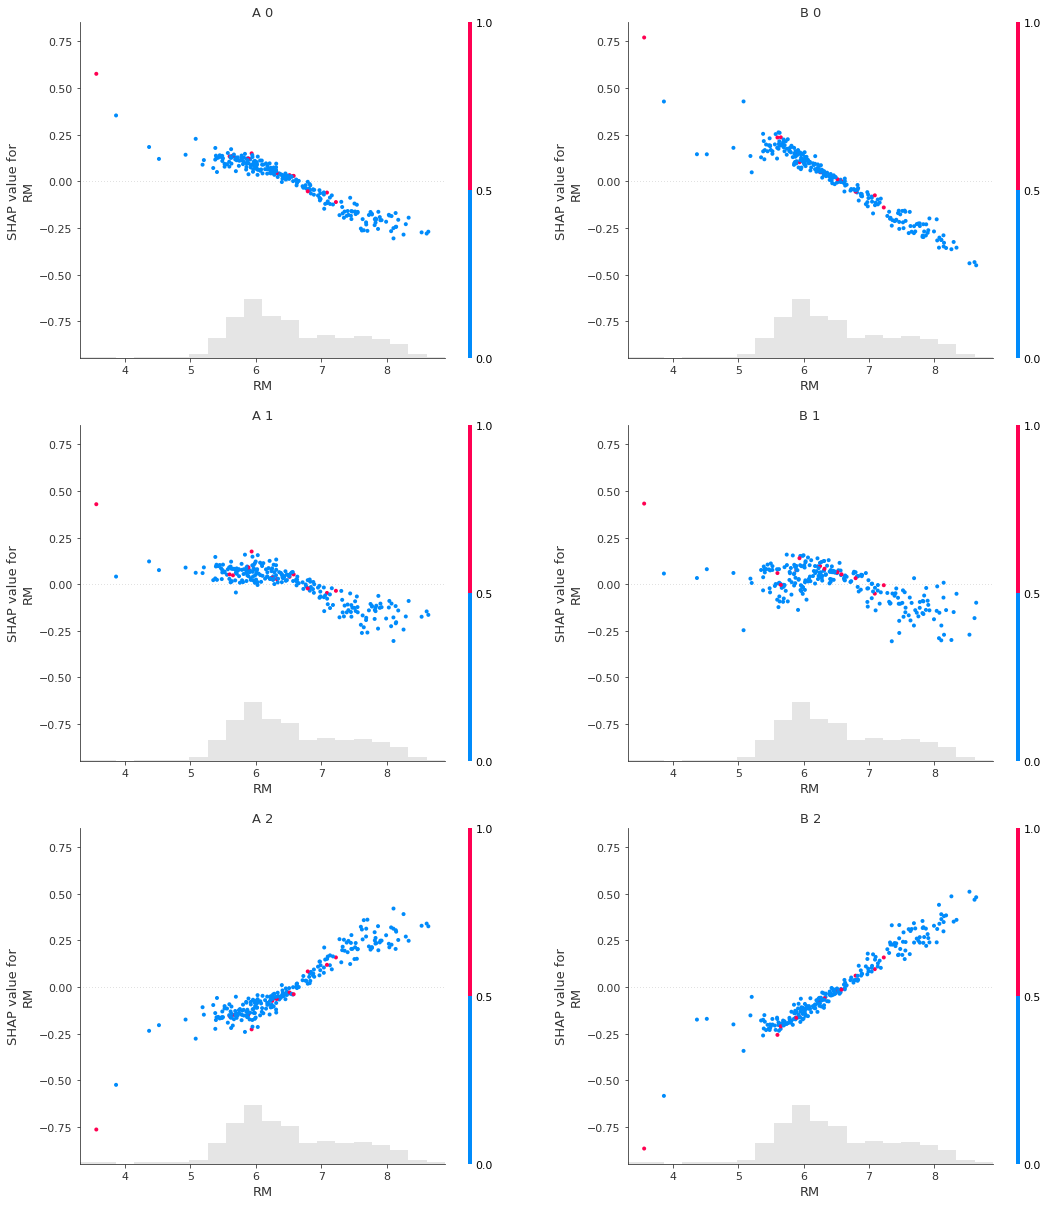

In [18]:
plot_next_feature()

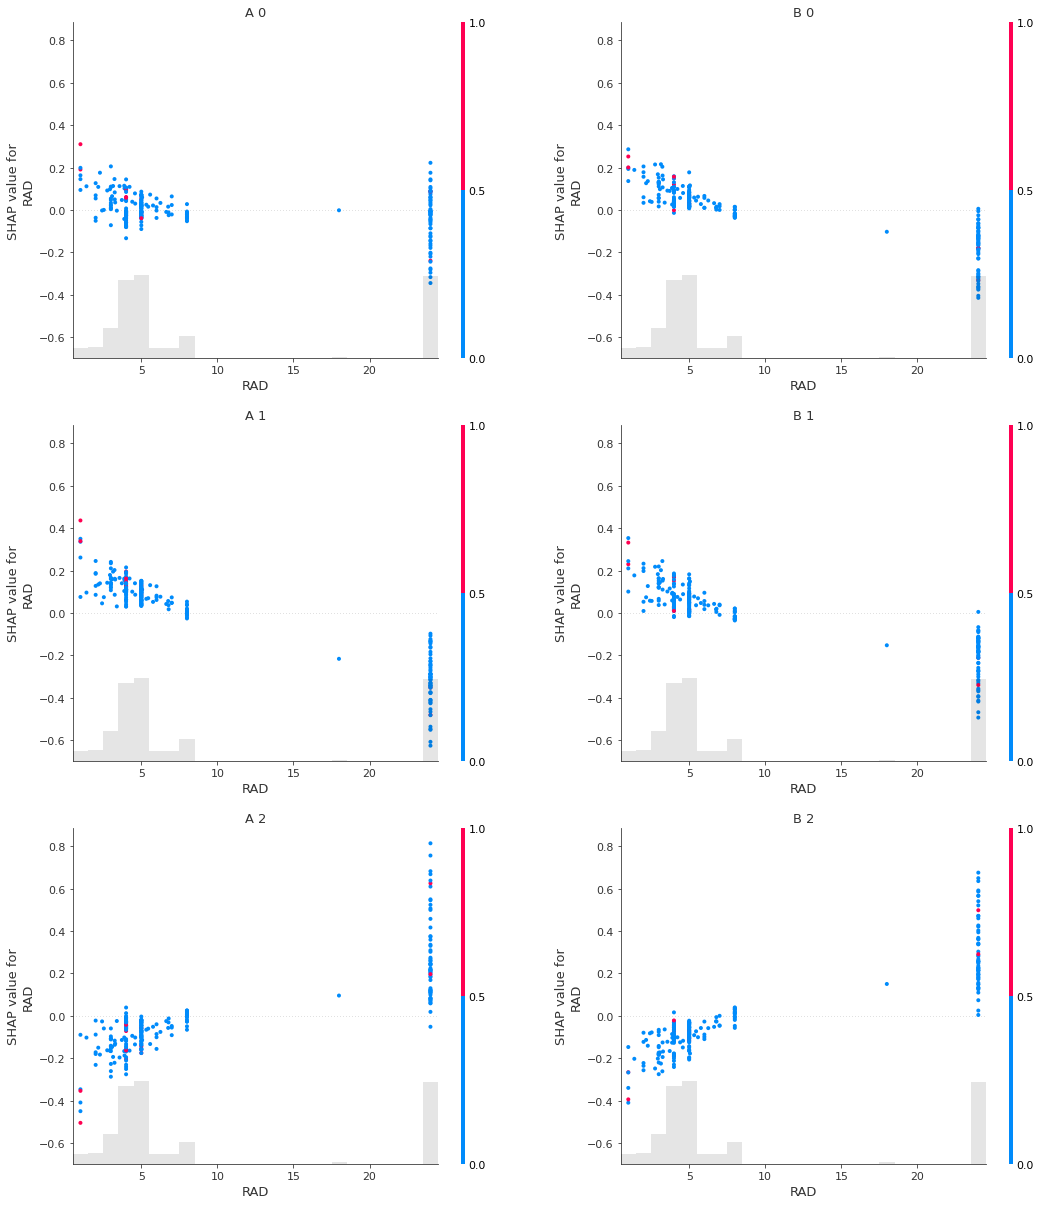

In [19]:
plot_next_feature()

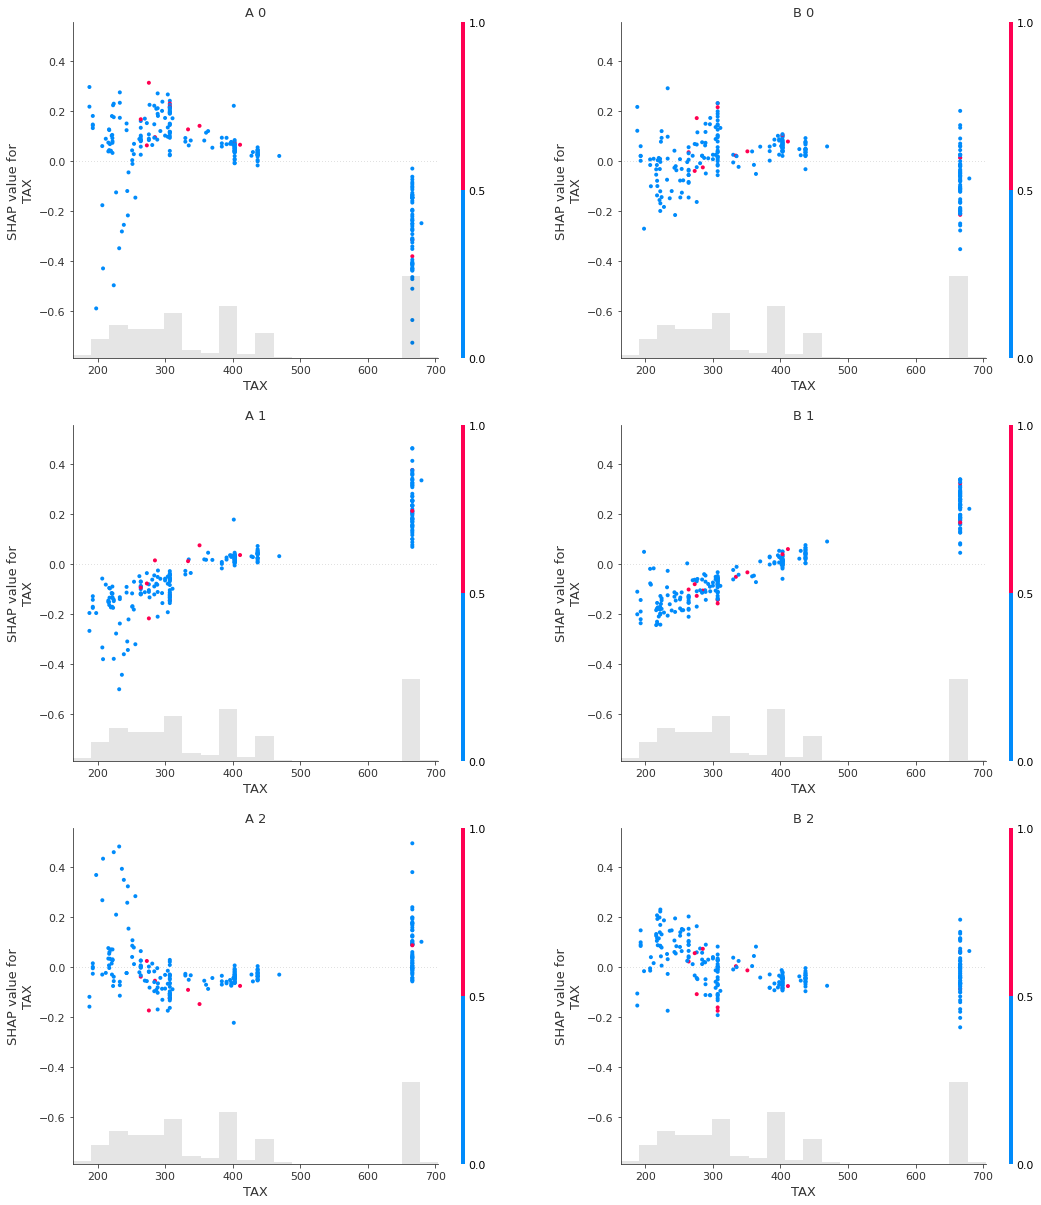

In [20]:
plot_next_feature()

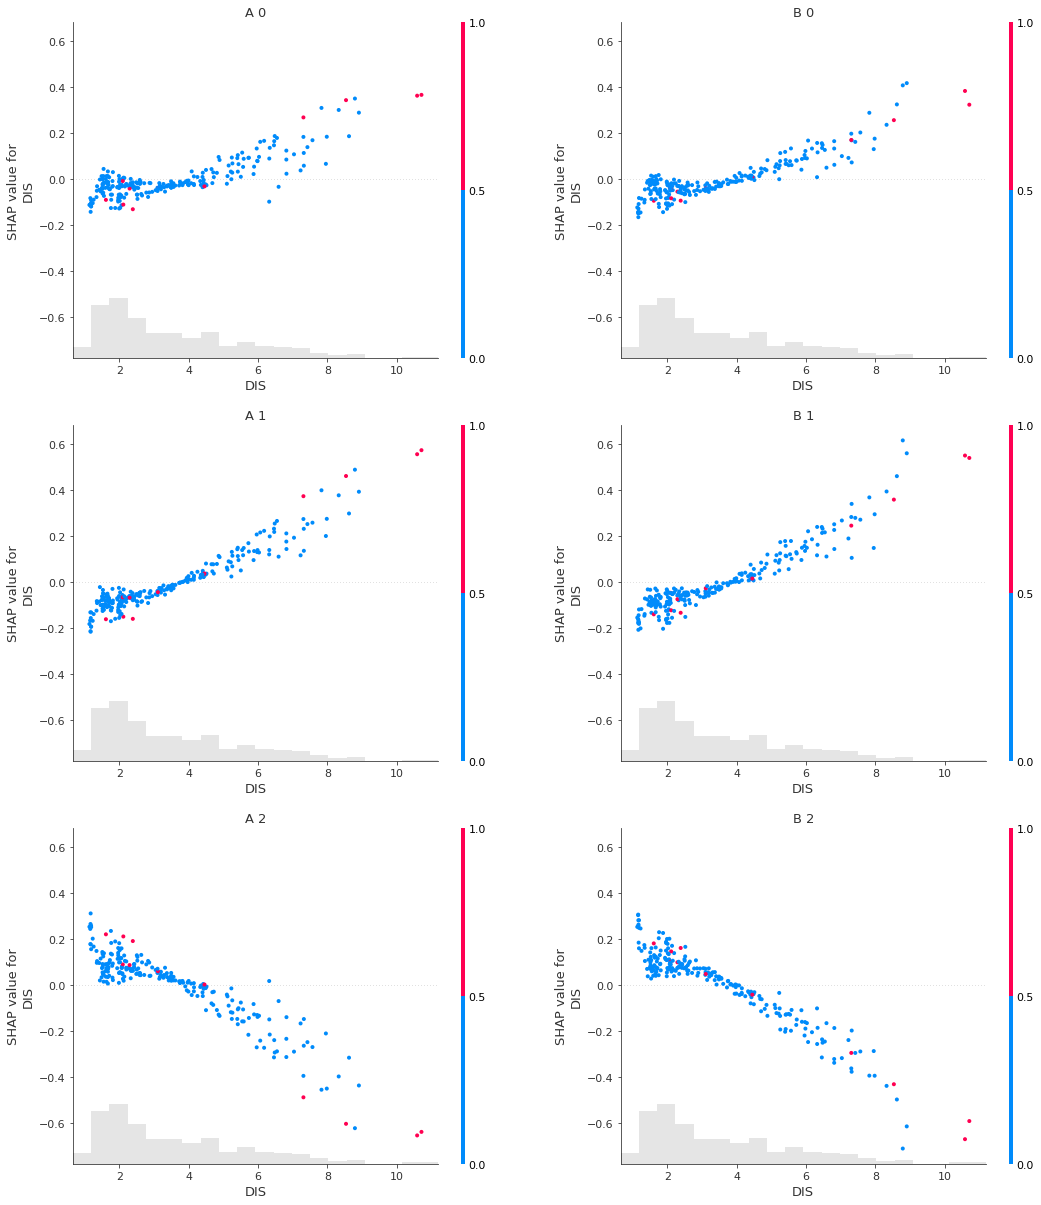

In [21]:
plot_next_feature()

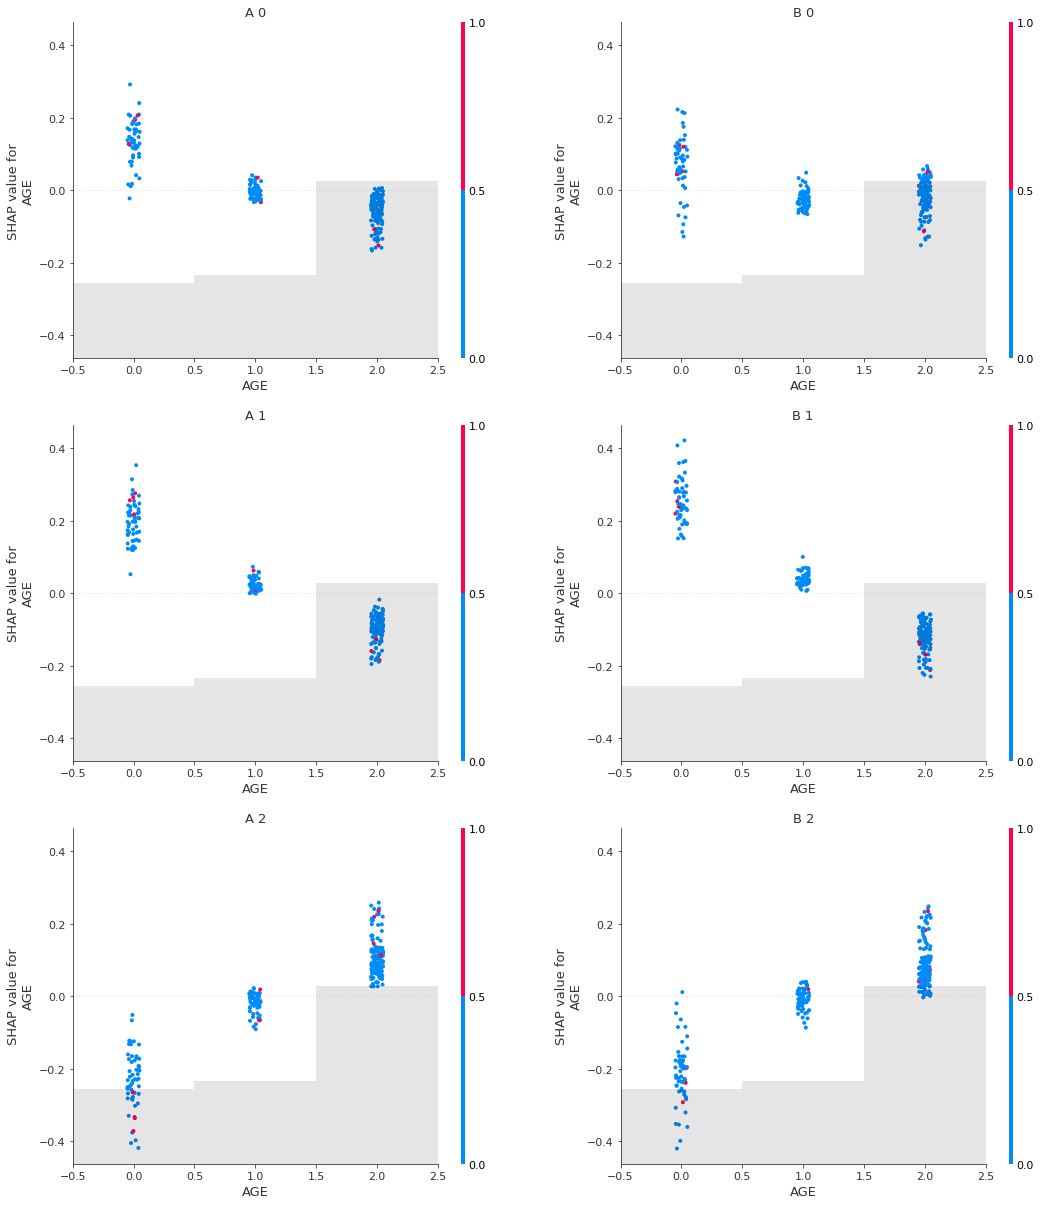

In [22]:
plot_next_feature()

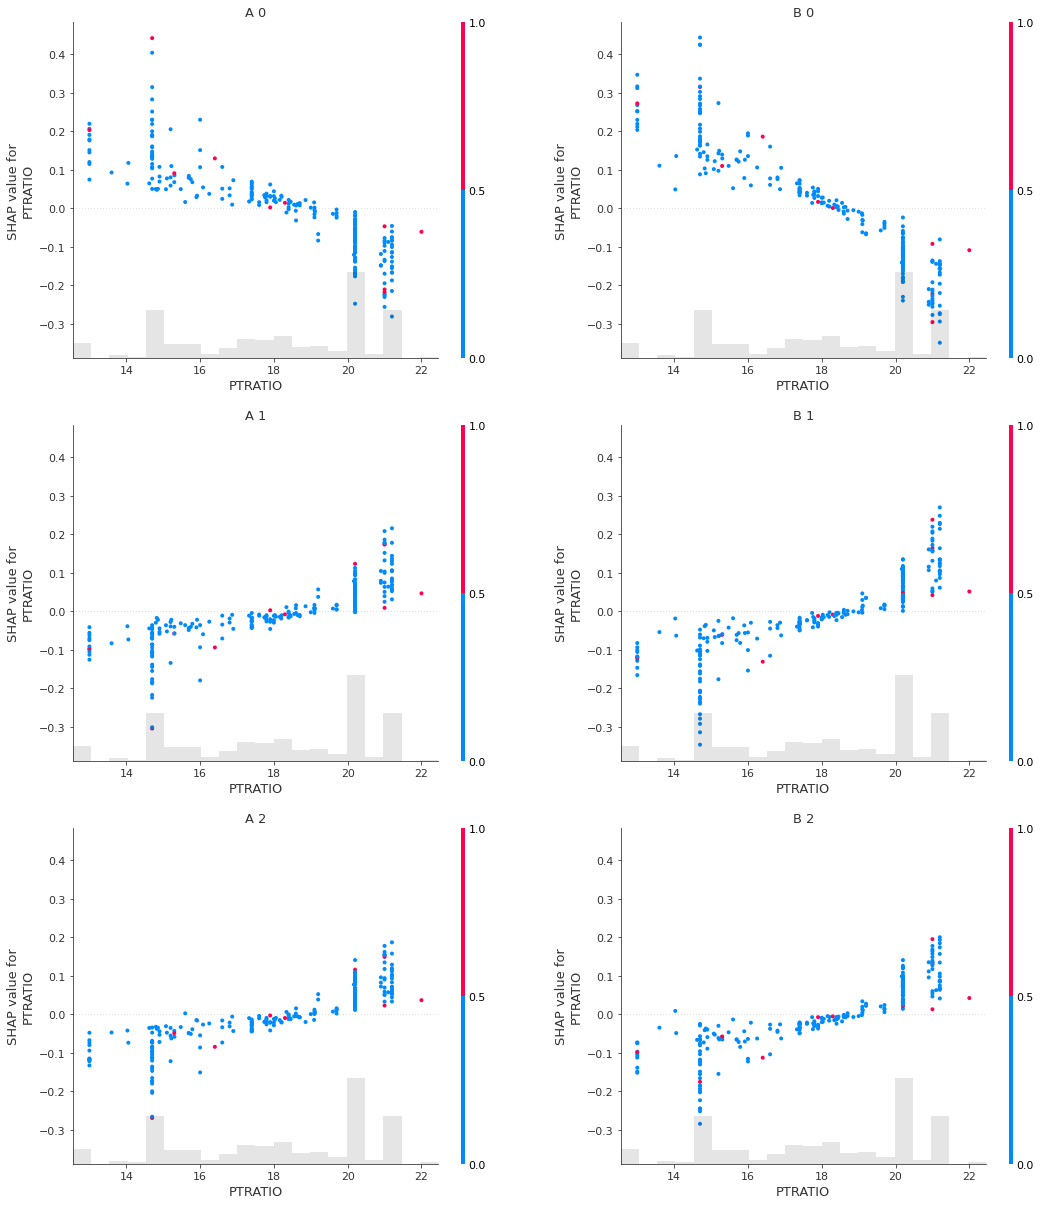

In [23]:
plot_next_feature()

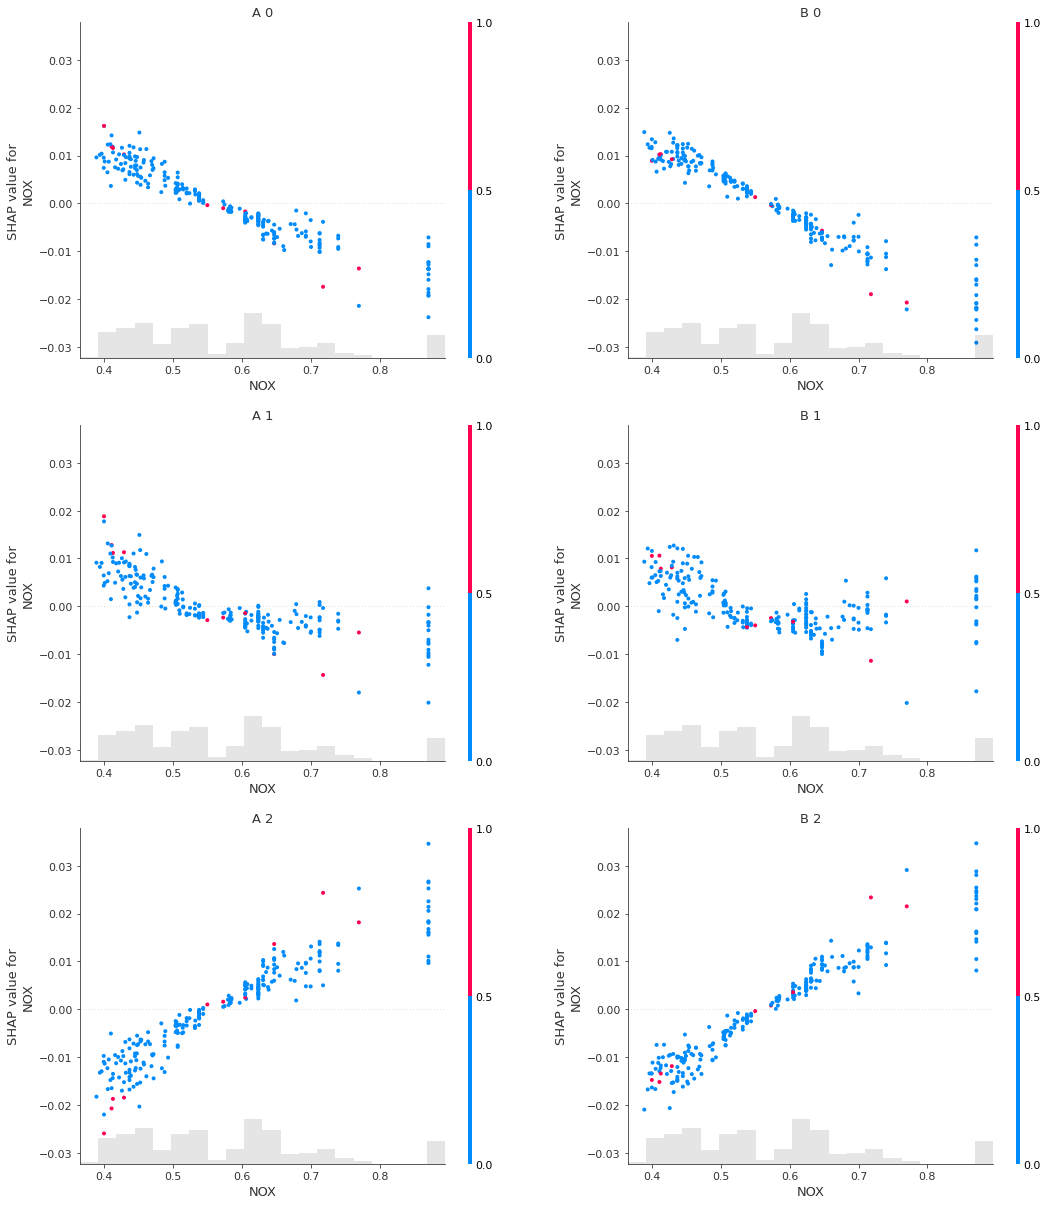

In [24]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

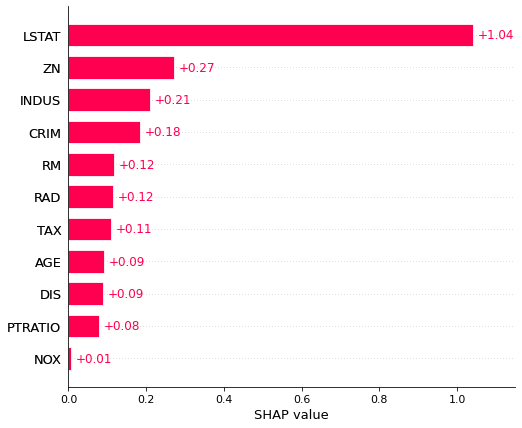

In [5]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [6]:
feature_order = feature_order[:-1]
global_feature_order = feature_order

In [27]:
X.iloc[:, feature_order].describe()

LSTAT          ZN       INDUS        CRIM          RM         RAD  \
count  246.000000  246.000000  246.000000  246.000000  246.000000  246.000000   
mean    11.736981   12.841063   11.718208    2.720010    6.511388    9.346908   
std      7.372550   25.552540    7.290396    6.388147    0.889747    8.493772   
min      1.763949    0.000000    1.210000    0.009060    3.561000    1.000000   
25%      5.008267    0.000000    4.243588    0.099321    5.882000    4.000000   
50%      9.950000    0.000000    9.900000    0.540032    6.315500    5.000000   
75%     17.091674   20.000000   18.100000    3.181873    7.134552    8.000000   
max     36.980000  100.000000   25.650000   73.534100    8.638029   24.000000   

              TAX         AGE         DIS     PTRATIO         NOX  
count  246.000000  246.000000  246.000000  246.000000  246.000000  
mean   403.132604    1.304878    3.501706   18.125578    0.572581  
std    165.416533    0.813494    2.007156    2.524334    0.125307  
min    188.000000    0.000000    1.137912   13.000000    0.389000  
25%    273.000000    1.000000    1.967365   15.707491    0.462112  
50%    362.186013    2.000000    2.866600   18.571912    0.544000  
75%    461.000000    2.000000    4.621654   20.200000    0.638740  
max    679.526743    2.000000   10.710300   22.000000    0.871000

In [28]:
X['AGE'].value_counts()

2.0    130
1.0     61
0.0     55
Name: AGE, dtype: int64

The equality classes (0,0) and (2,2) have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

(0,2) and (2,0) have the least importances.

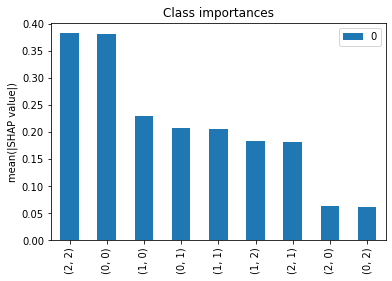

In [29]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [30]:
class_order = np.sort(class_order[:-2])

In [31]:
def plot_next_feature():
    feature_idx = next(it)
    # plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [feature_idx]], class_order=class_order)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx], class_order[:4]], color=is_pred_diff)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx], class_order[3:]], color=is_pred_diff)
it = iter(feature_order)

Difference classes (0,1) and (1,0) are at their peak between approx. 11 and 20, (1,2) and (2,1) in the range between approx. 5 and 10.

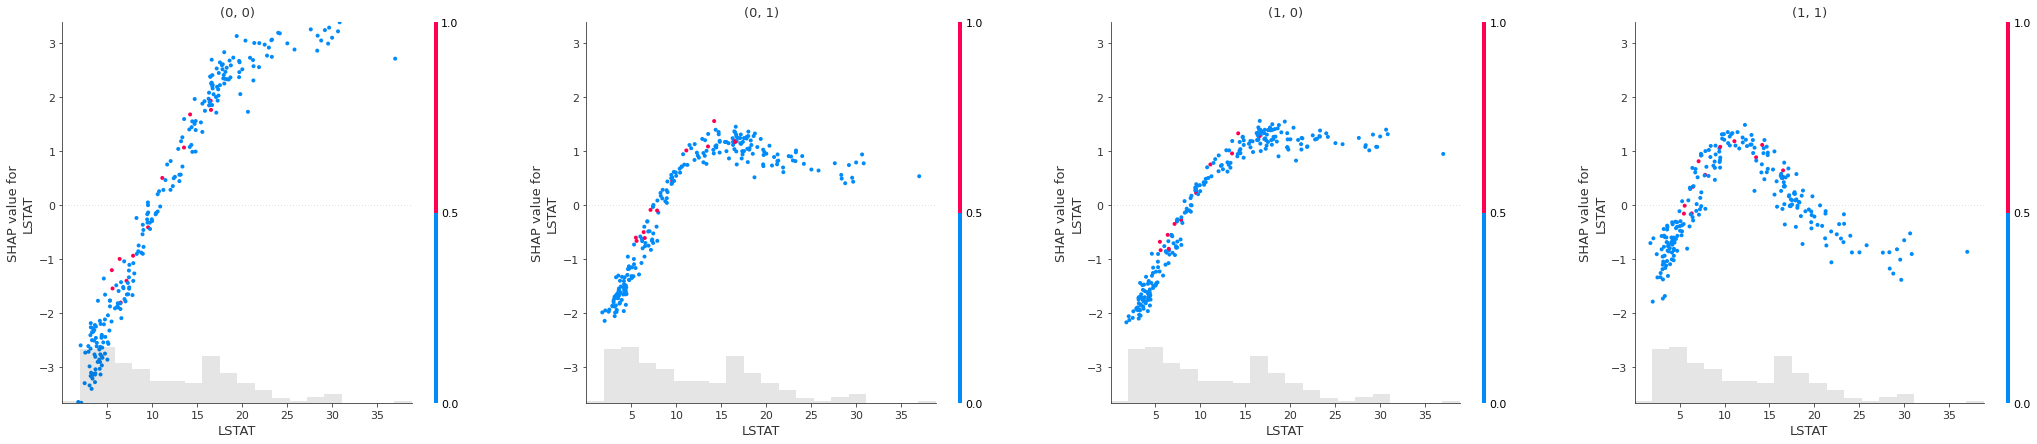

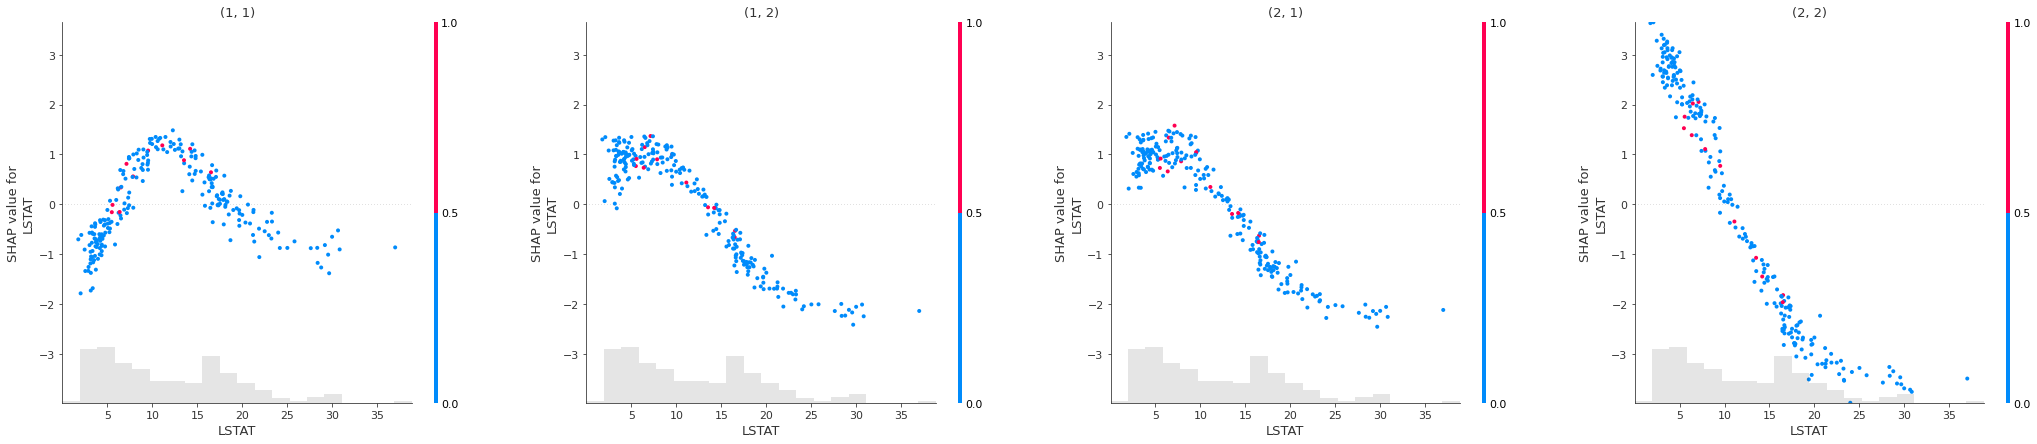

In [32]:
plot_next_feature()

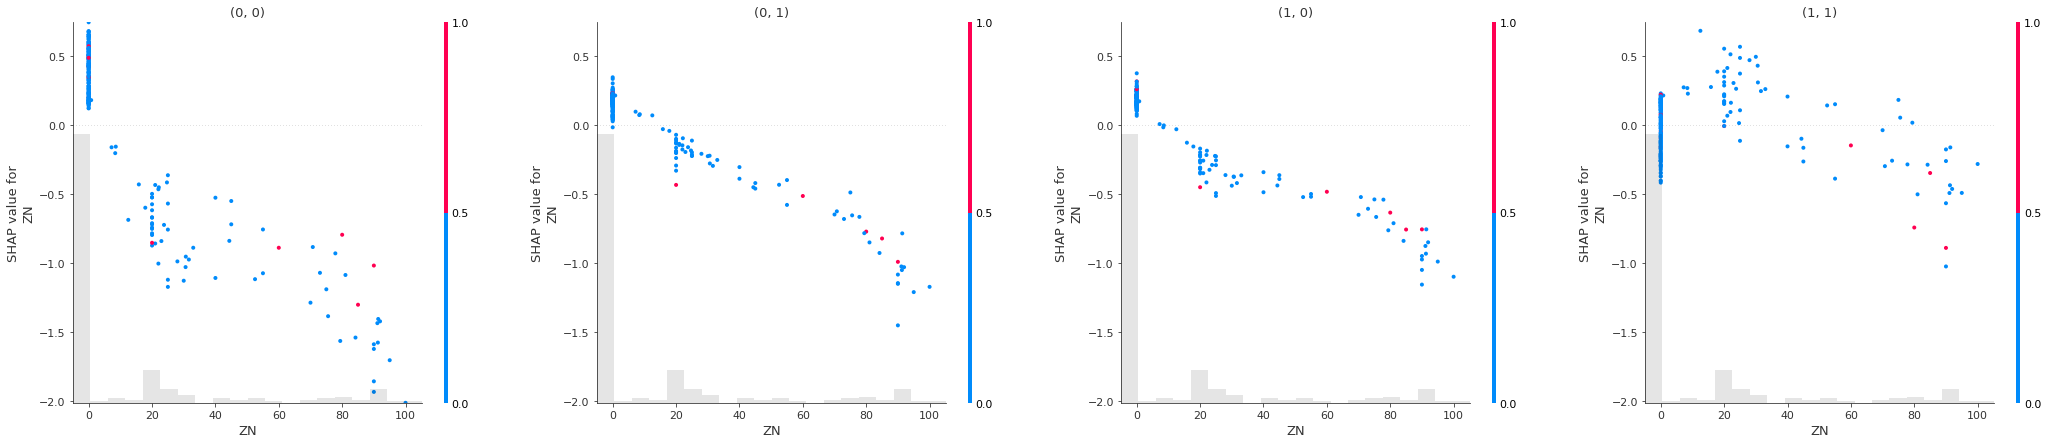

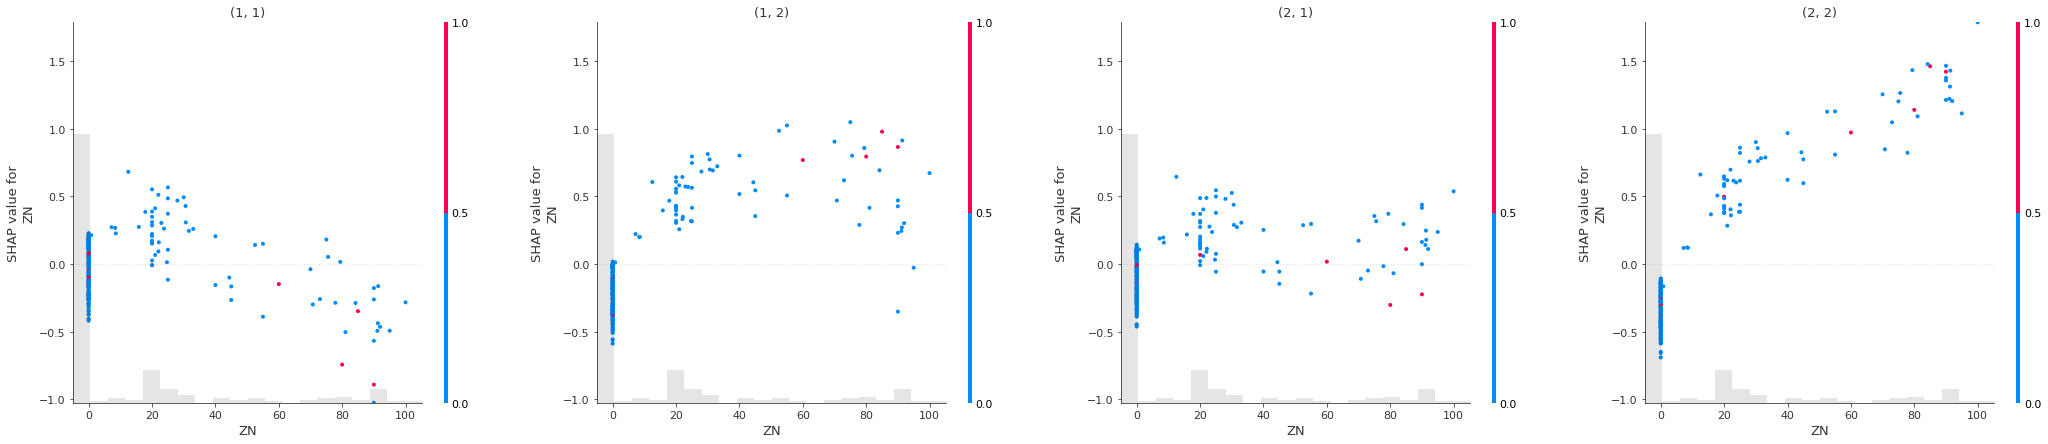

In [33]:
plot_next_feature()

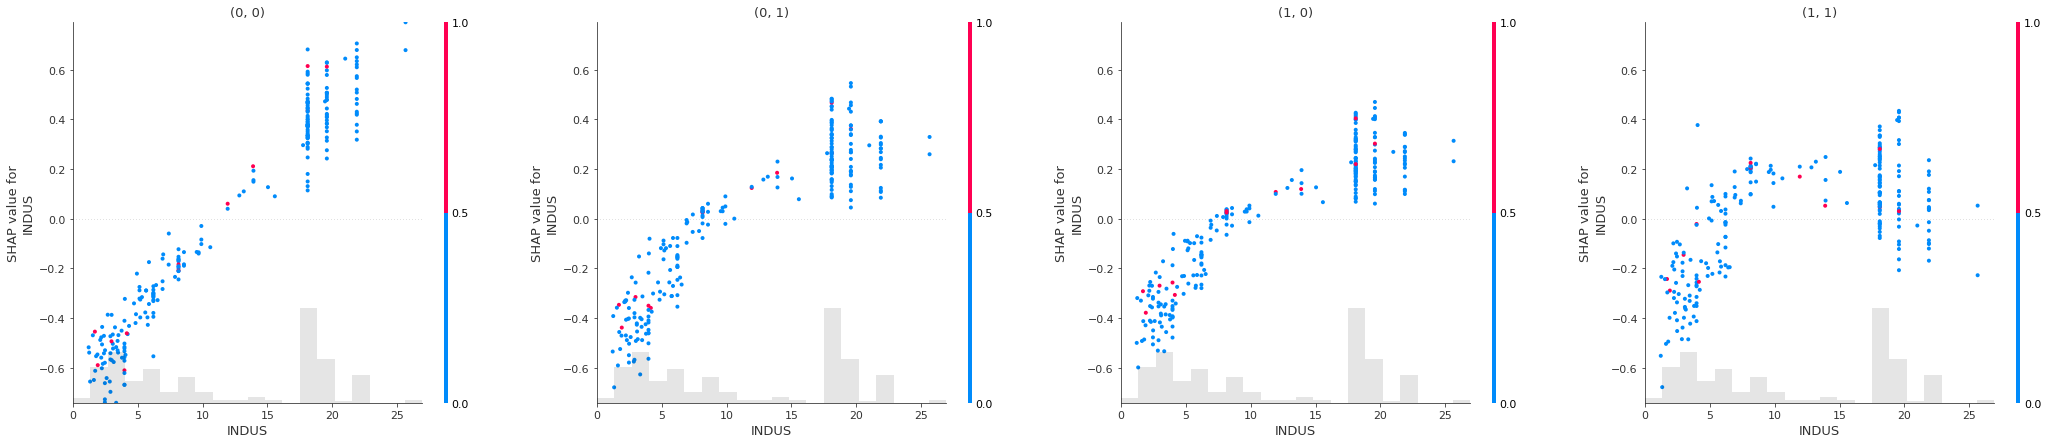

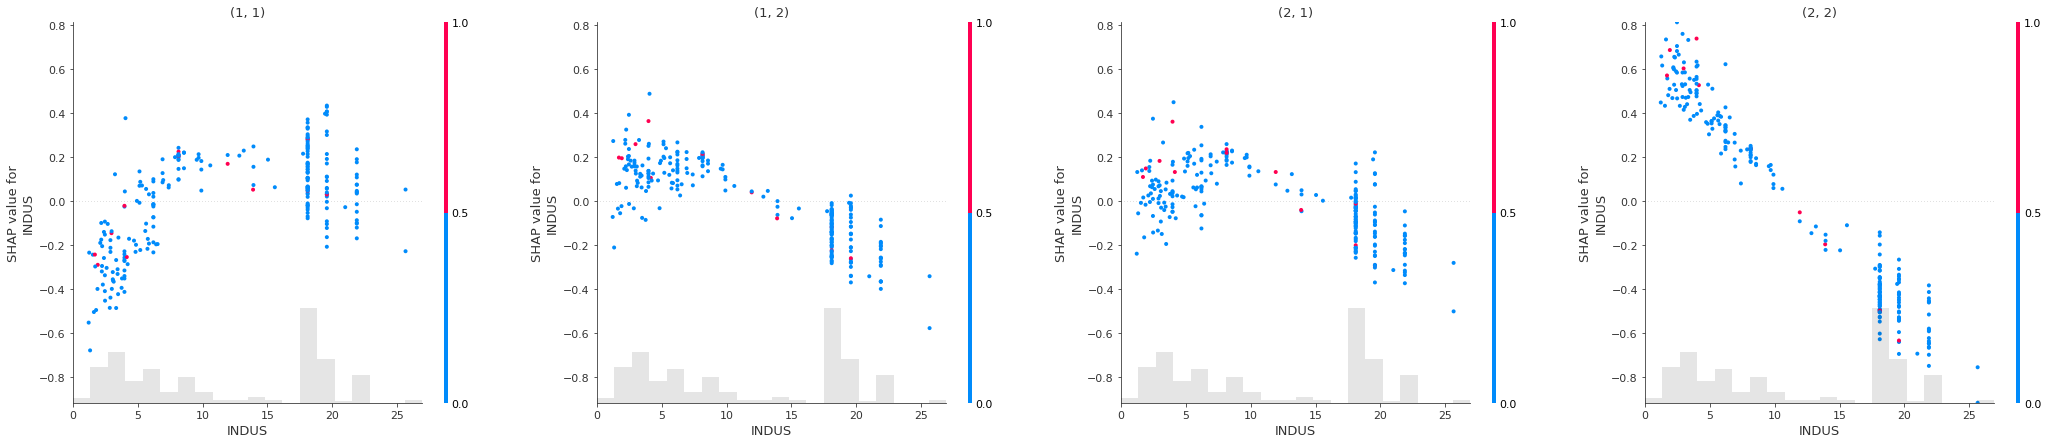

In [34]:
plot_next_feature()

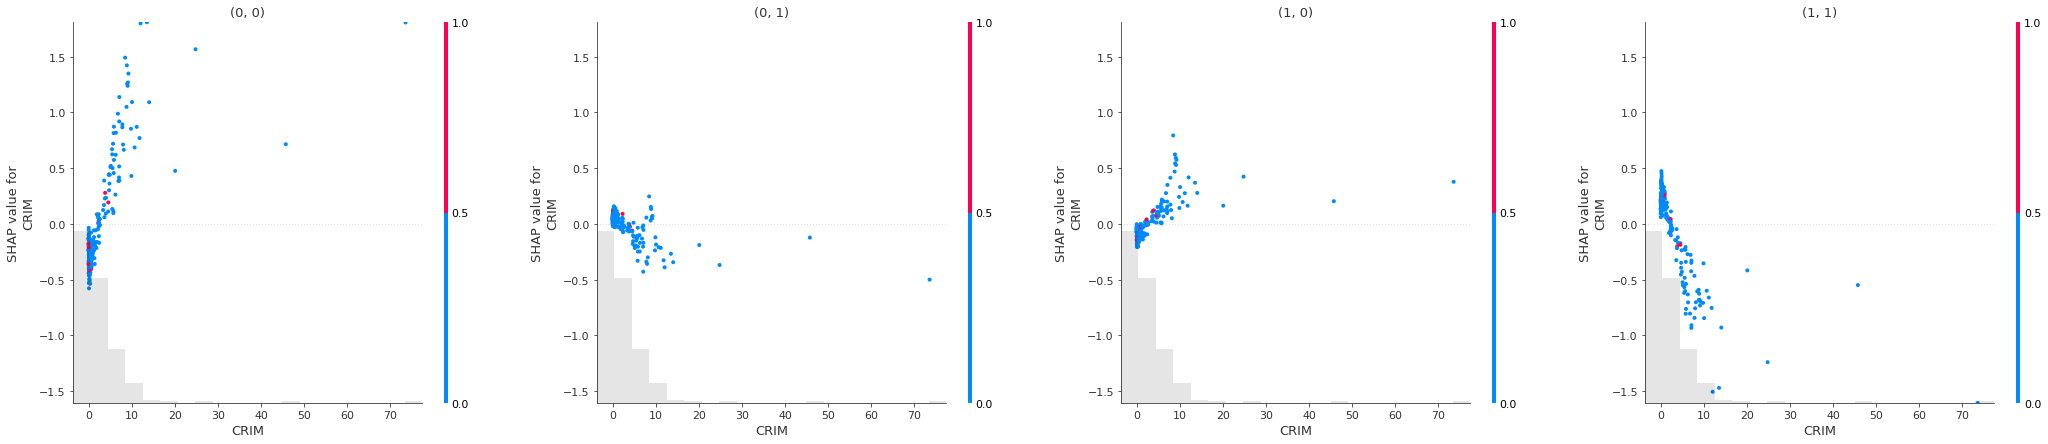

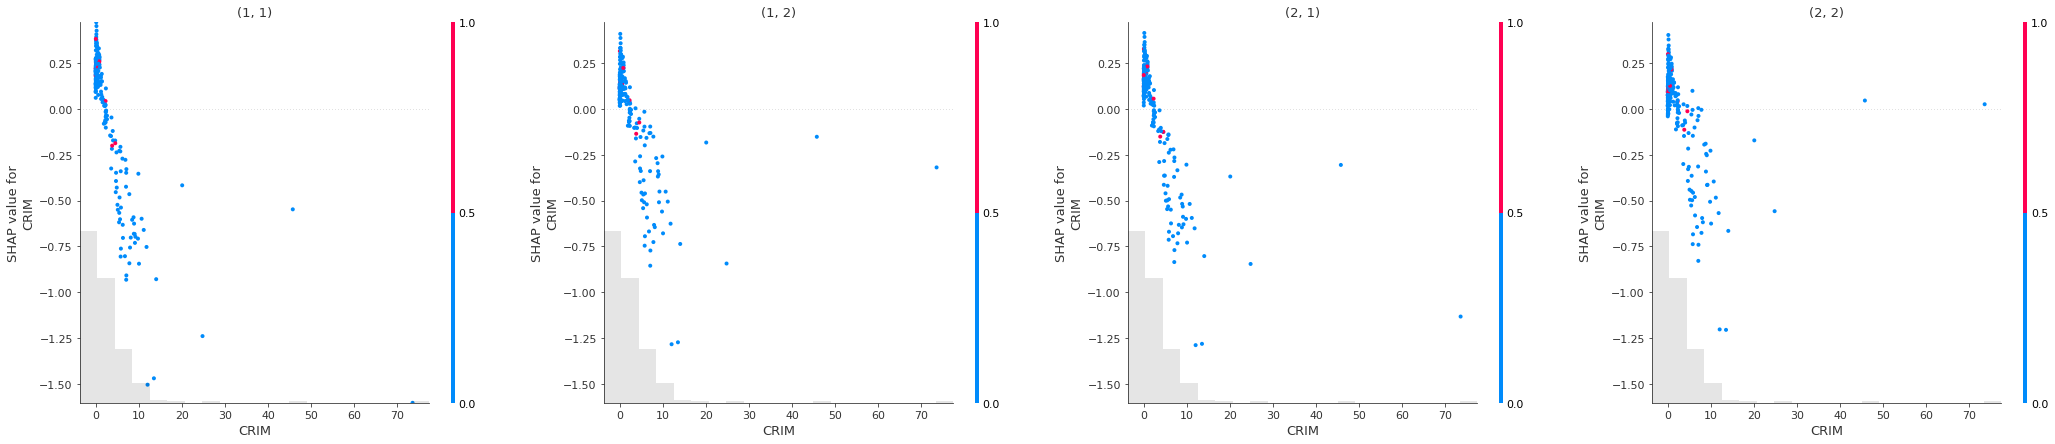

In [35]:
plot_next_feature()

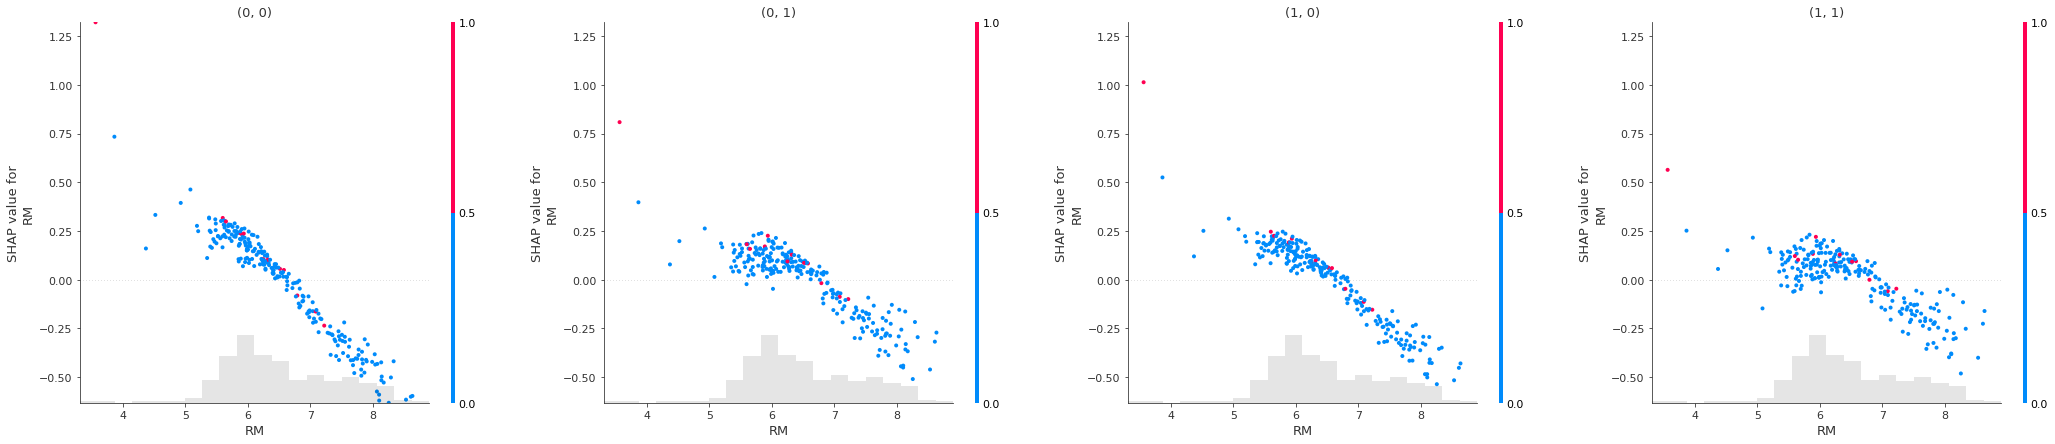

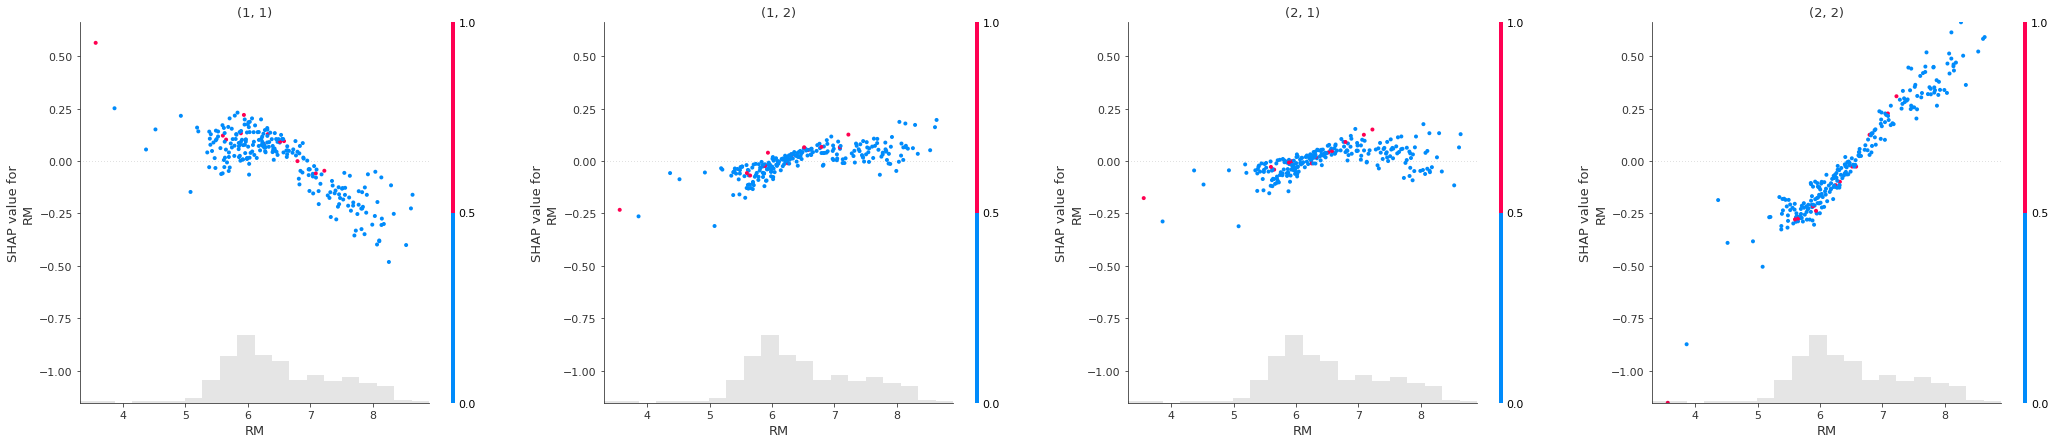

In [36]:
plot_next_feature()

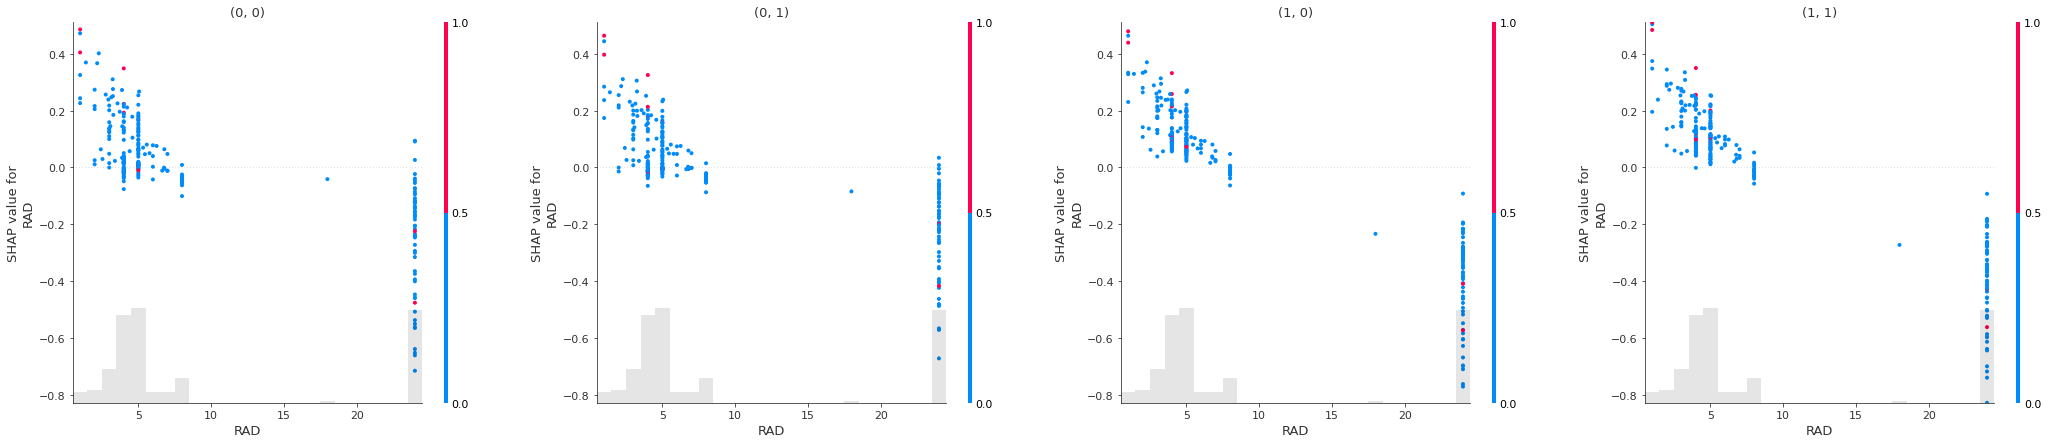

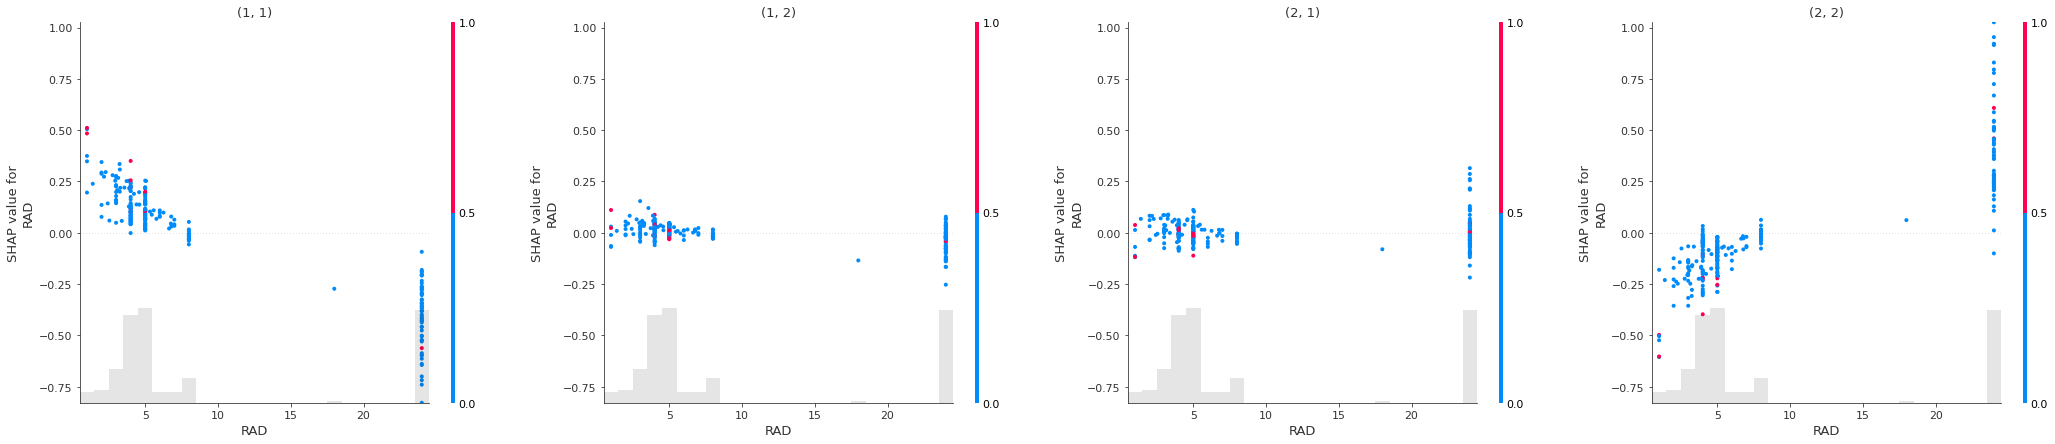

In [37]:
plot_next_feature()

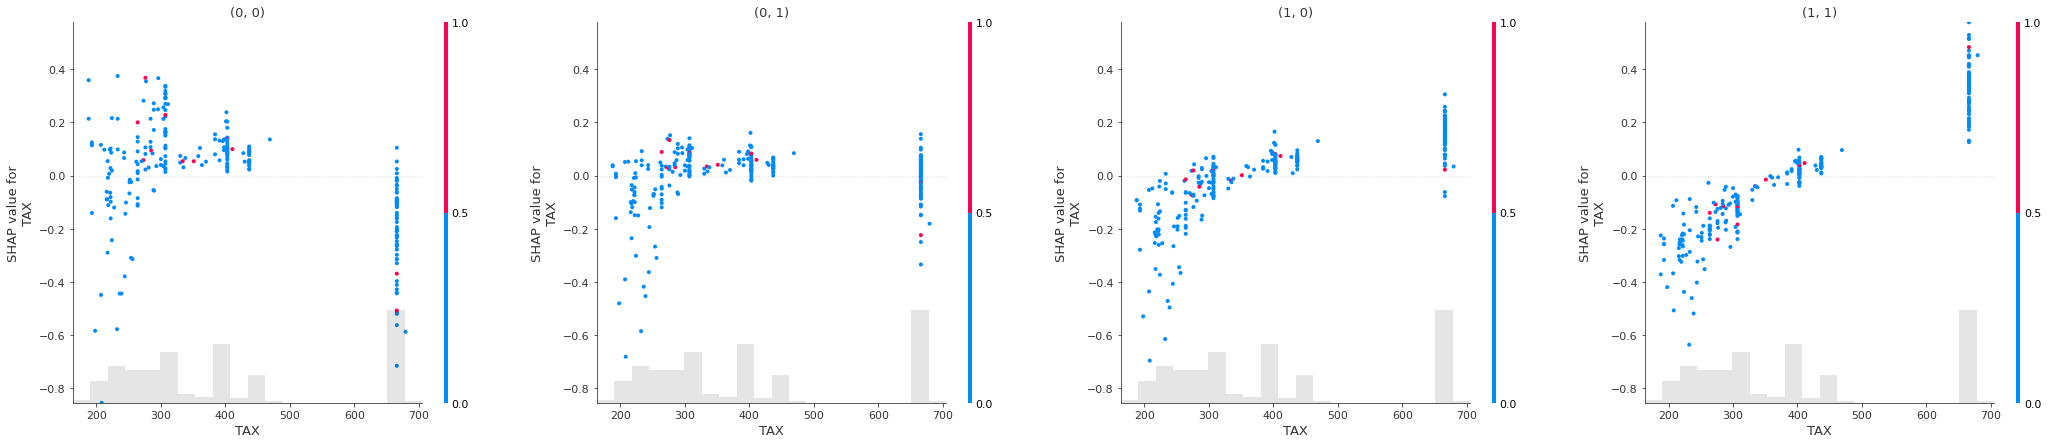

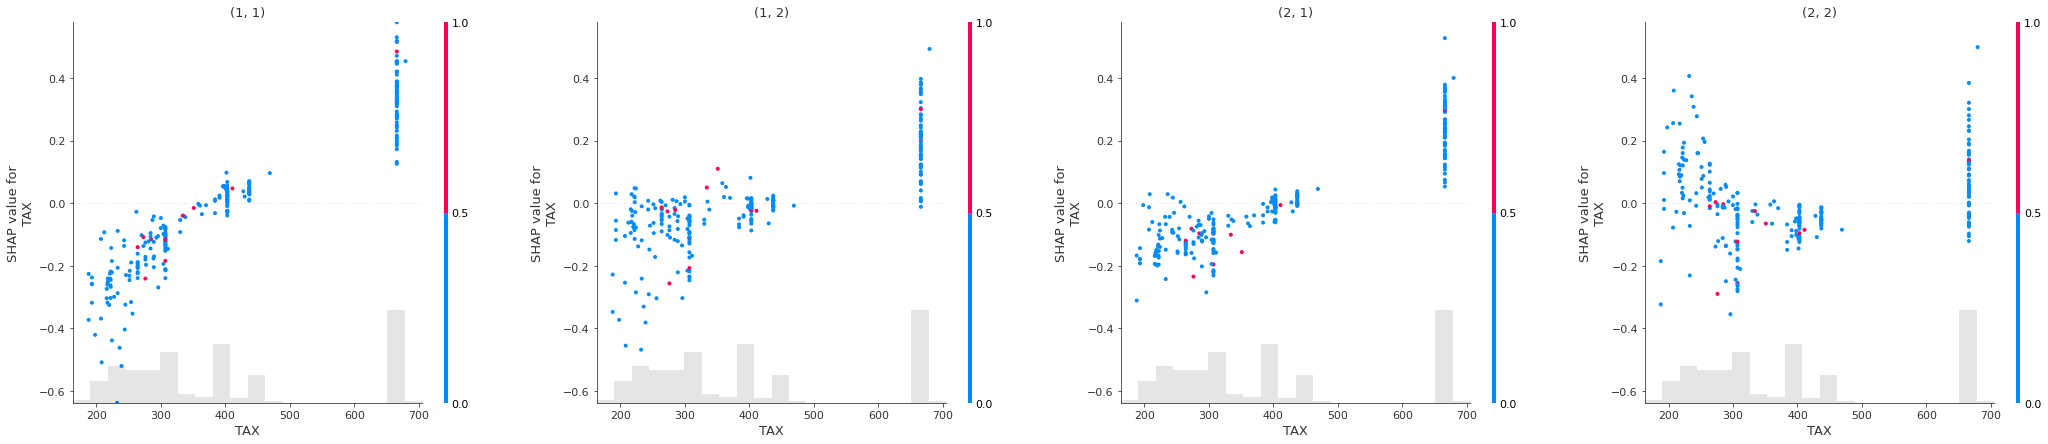

In [38]:
plot_next_feature()

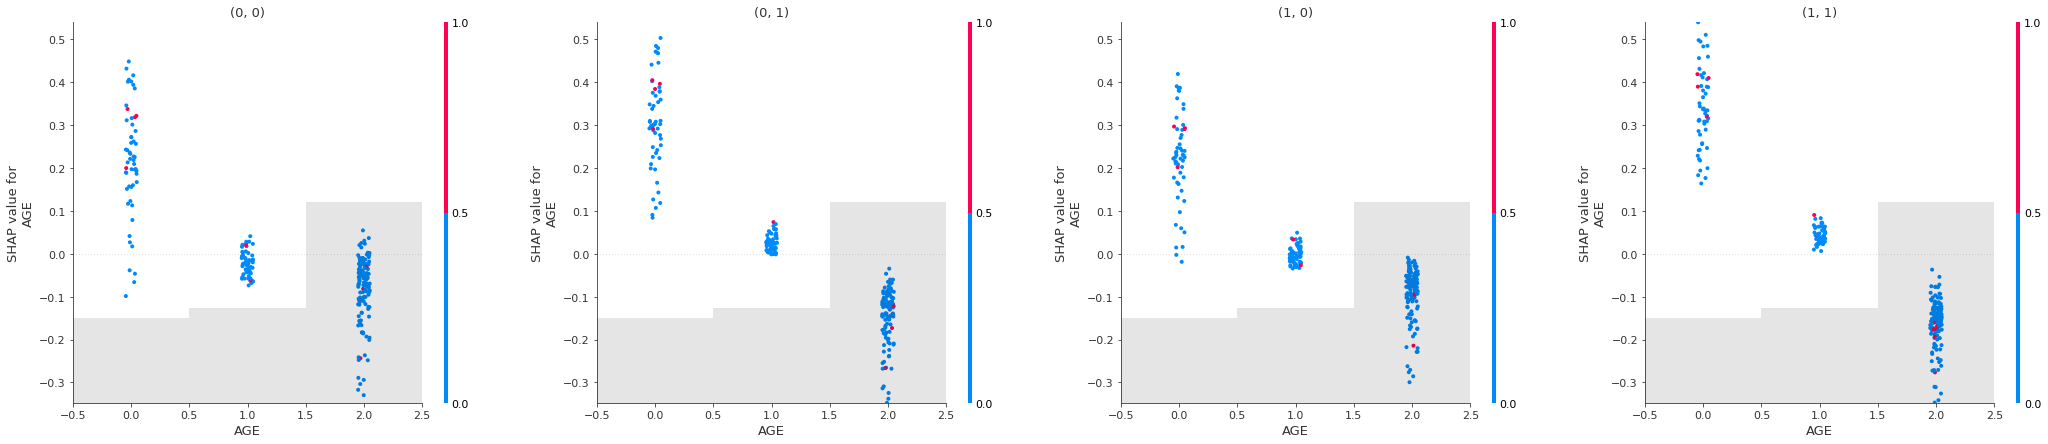

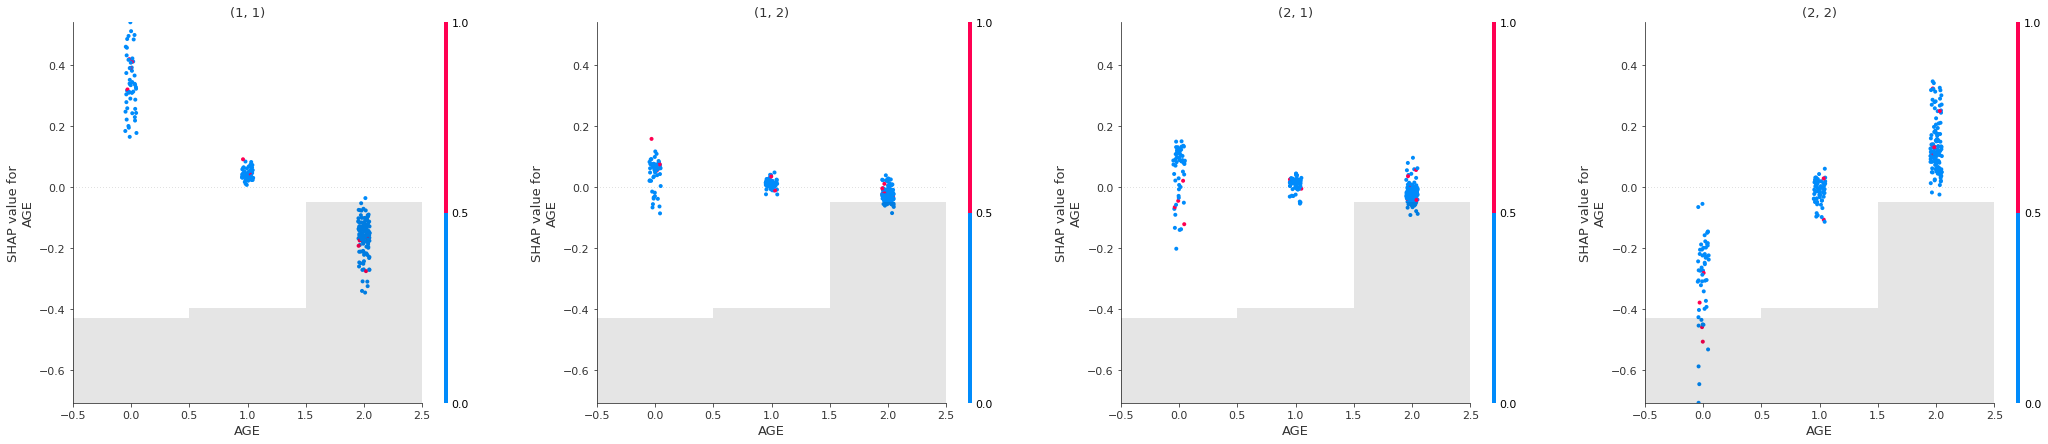

In [39]:
plot_next_feature()

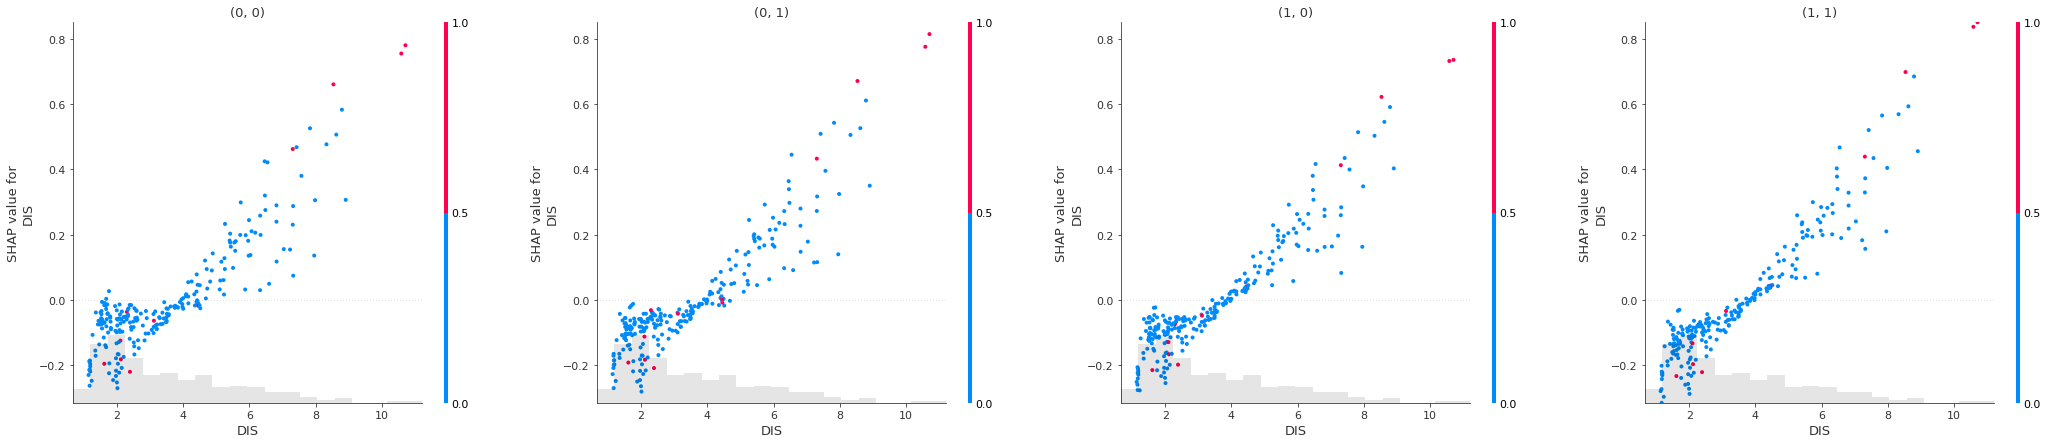

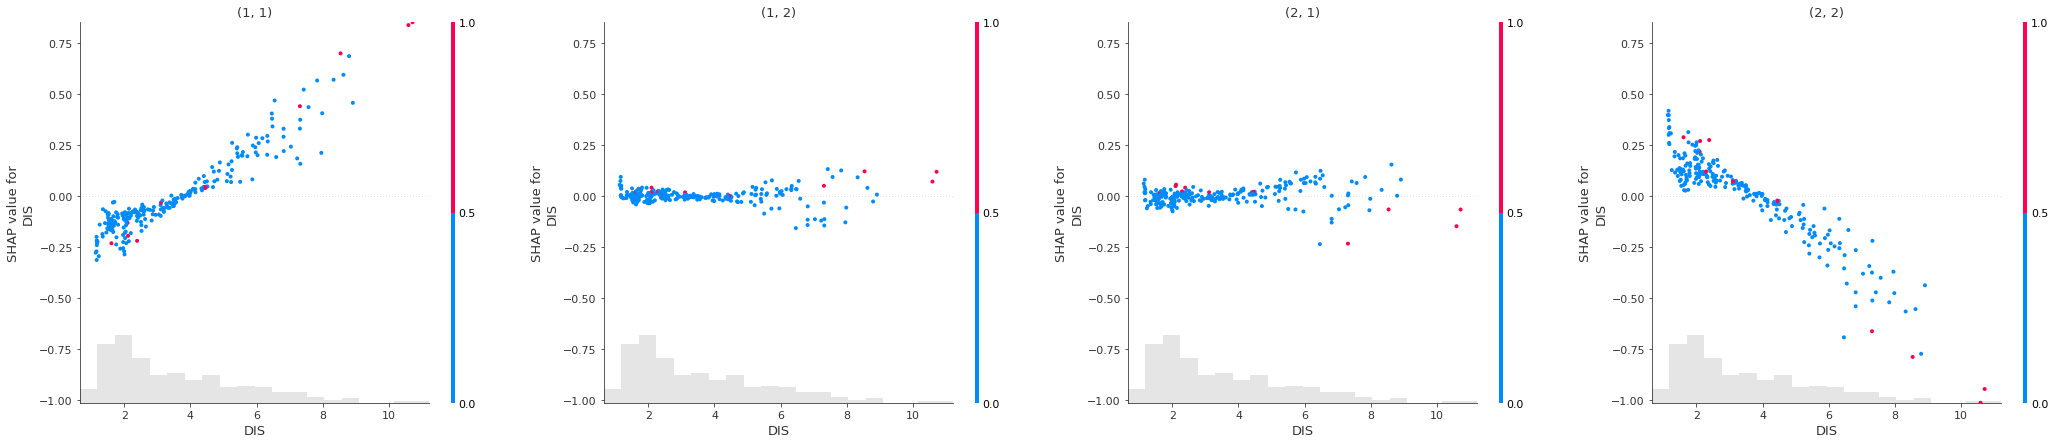

In [40]:
plot_next_feature()

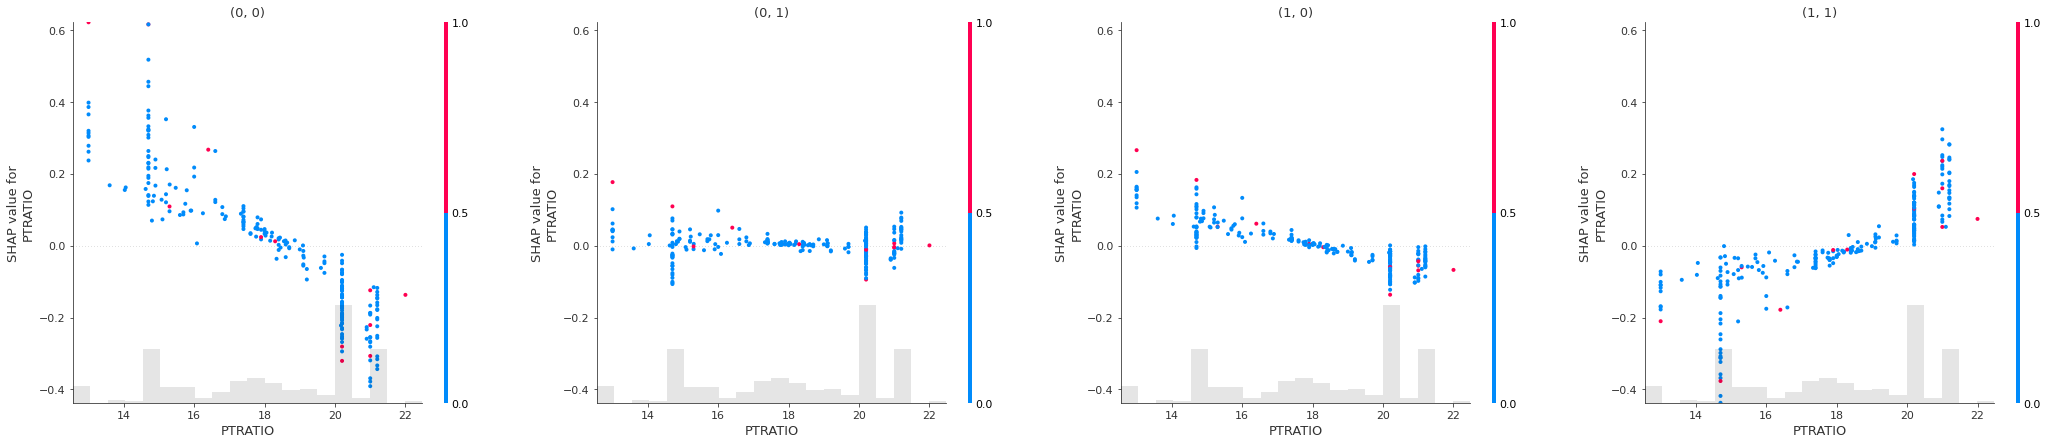

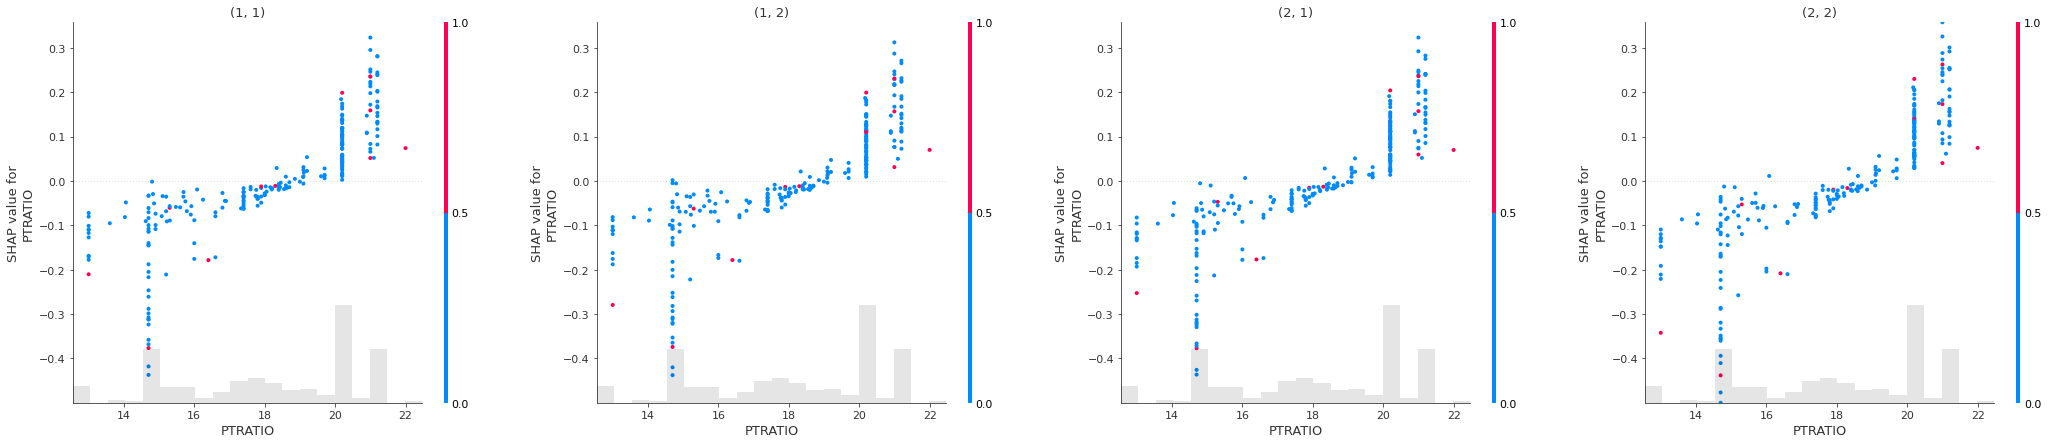

In [41]:
plot_next_feature()

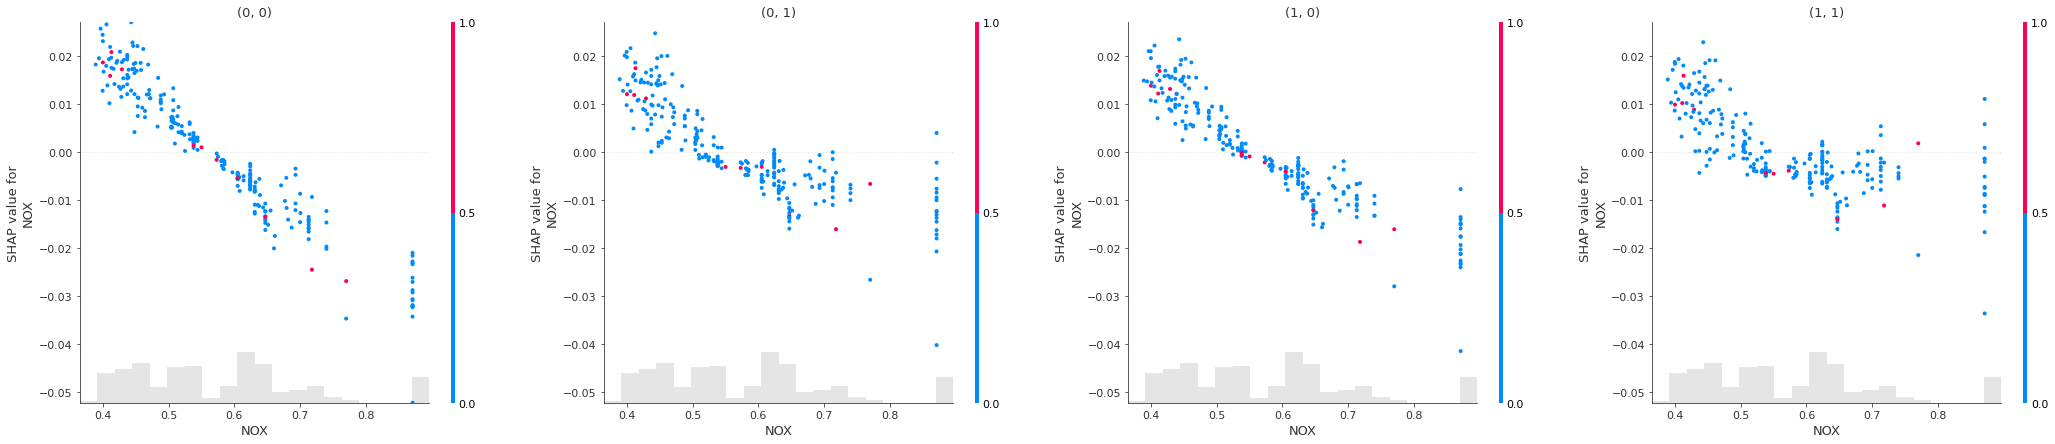

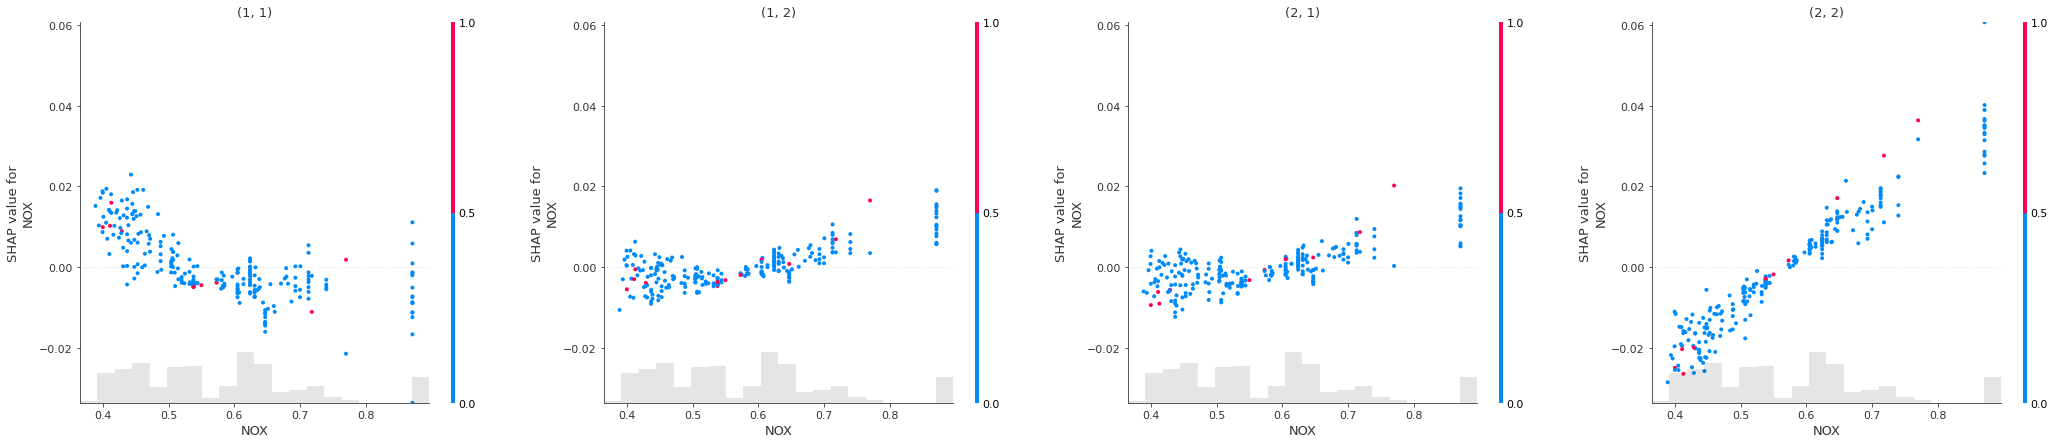

In [42]:
plot_next_feature()

# Local Explanations

## Clustering of (0,1) SHAP Values

In [4]:
clustering = make_clustering(comparer, explanations.mclass_diff.log_odds, '(0, 1)', '(0, 0)', '(1, 1)')

node #490 (level 0)
(2, 2)    96
(0, 0)    86
(1, 1)    52
(1, 2)     5
(0, 1)     3
(2, 1)     2
(1, 0)     2
dtype: int64


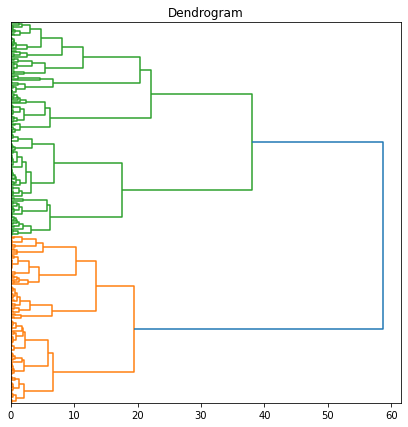

In [5]:
clustering.plot_dendrogram()

In [6]:
clustering.go_down()

node #486 (level 1)
(0, 0)    86
(1, 1)    17
(0, 1)     3
(1, 0)     2
dtype: int64


Cluster characteristics:
- 10.5 < LSTAT
- ZN ≤ 12.5
- 4 < INDUS
- RM < 6.9
- RAD ≤ 2 (not relevant)
- DIS < 6.6 (not relevant)

Differences:
- LSTAT < 14.2
- ZN=0
- 13.8 < INDUS < 19.6
- CRIM < 3.9
- RM < 6.4
- 5 ≤ RAD (not relevant)
- 1 ≤ AGE ≤ 2
- DIS < 3.2

Counterfactuals:
- $LSTAT=14.9 \rightarrow (0,0)$
- $LSTAT=10.4 \rightarrow (1,1)$

In [7]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

LSTAT


global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean    11.736981   18.762657   12.933333
std      7.372550    4.963004    1.623710
min      1.763949   10.580000   11.100000
25%      5.008267   16.143805   12.305000
50%      9.950000   17.505486   13.510000
75%     17.091674   20.932851   13.850000
max     36.980000   36.980000   14.190000

ZN


global   local-all  local-diff
count  246.000000  108.000000         3.0
mean    12.841063    0.115741         0.0
std     25.552540    1.202813         0.0
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    0.000000         0.0
75%     20.000000    0.000000         0.0
max    100.000000   12.500000         0.0

INDUS


global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean    11.718208   17.187994   17.190000
std      7.290396    4.798006    2.952135
min      1.210000    4.050000   13.890000
25%      4.243588   18.100000   15.995000
50%      9.900000   18.100000   18.100000
75%     18.100000   19.580000   18.840000
max     25.650000   25.650000   19.580000

CRIM


global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean     2.720010    4.710454    2.060947
std      6.388147    8.882899    1.906929
min      0.009060    0.045600    0.045600
25%      0.099321    0.741865    1.173000
50%      0.540032    2.318678    2.300400
75%      3.181873    5.579054    3.068620
max     73.534100   73.534100    3.836840

RM


global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean     6.511388    5.875902    6.152667
std      0.889747    0.484219    0.231716
min      3.561000    3.863000    5.888000
25%      5.882000    5.614930    6.069500
50%      6.315500    5.884000    6.251000
75%      7.134552    6.229000    6.285000
max      8.638029    6.833000    6.319000

RAD


global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean     9.346908   12.243879   11.333333
std      8.493772    9.715014   10.969655
min      1.000000    2.000000    5.000000
25%      4.000000    4.000000    5.000000
50%      5.000000    5.000000    5.000000
75%      8.000000   24.000000   14.500000
max     24.000000   24.000000   24.000000

TAX


global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean   403.132604  487.978253  448.333333
std    165.416533  159.043624  198.912879
min    188.000000  188.000000  276.000000
25%    273.000000  403.000000  339.500000
50%    362.186013  437.000000  403.000000
75%    461.000000  666.000000  534.500000
max    679.526743  679.526743  666.000000

AGE


global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean     1.304878    1.833333    1.666667
std      0.813494    0.421391    0.577350
min      0.000000    0.000000    1.000000
25%      1.000000    2.000000    1.500000
50%      2.000000    2.000000    2.000000
75%      2.000000    2.000000    2.000000
max      2.000000    2.000000    2.000000

DIS


global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean     3.501706    2.535299    2.502533
std      2.007156    1.163464    0.536874
min      1.137912    1.358000    2.100000
25%      1.967365    1.671299    2.197750
50%      2.866600    2.114151    2.295500
75%      4.621654    2.877750    2.703800
max     10.710300    6.592100    3.112100

PTRATIO


global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean    18.125578   19.159541   17.100000
std      2.524334    2.384422    2.816026
min     13.000000   14.700000   14.700000
25%     15.707491   18.440845   15.550000
50%     18.571912   20.200000   16.400000
75%     20.200000   21.000000   18.300000
max     22.000000   21.200000   20.200000

NOX


global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean     0.572581    0.654174    0.641667
std      0.125307    0.114319    0.114492
min      0.389000    0.437000    0.550000
25%      0.462112    0.581000    0.577500
50%      0.544000    0.624000    0.605000
75%      0.638740    0.713000    0.687500
max      0.871000    0.871000    0.770000

In [27]:
clustering.test(LSTAT=10.4)

before  after
(0, 1)     3.0    NaN
(1, 1)     NaN    3.0

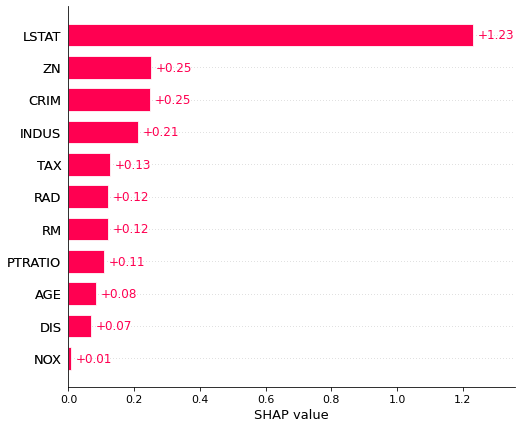

In [17]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

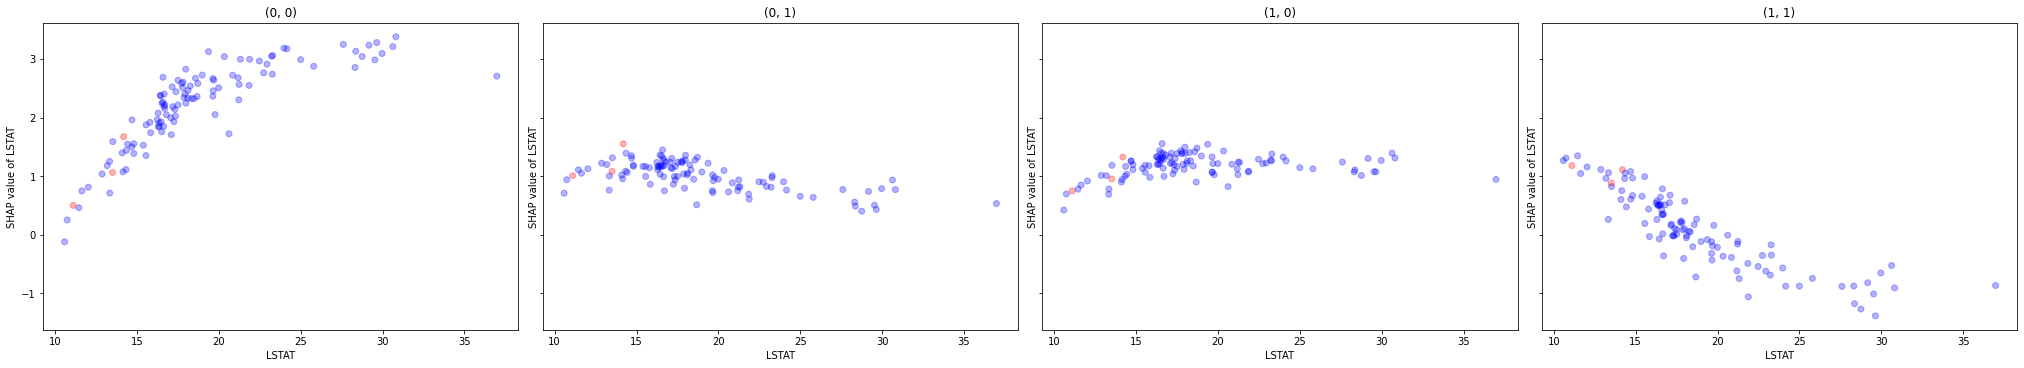

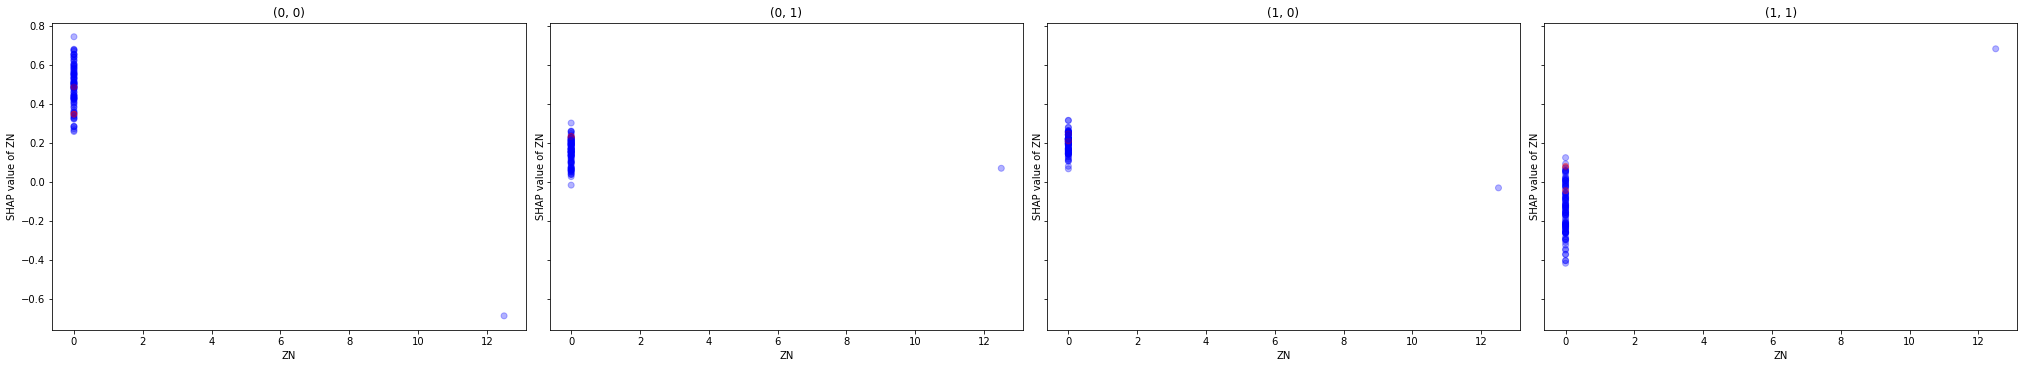

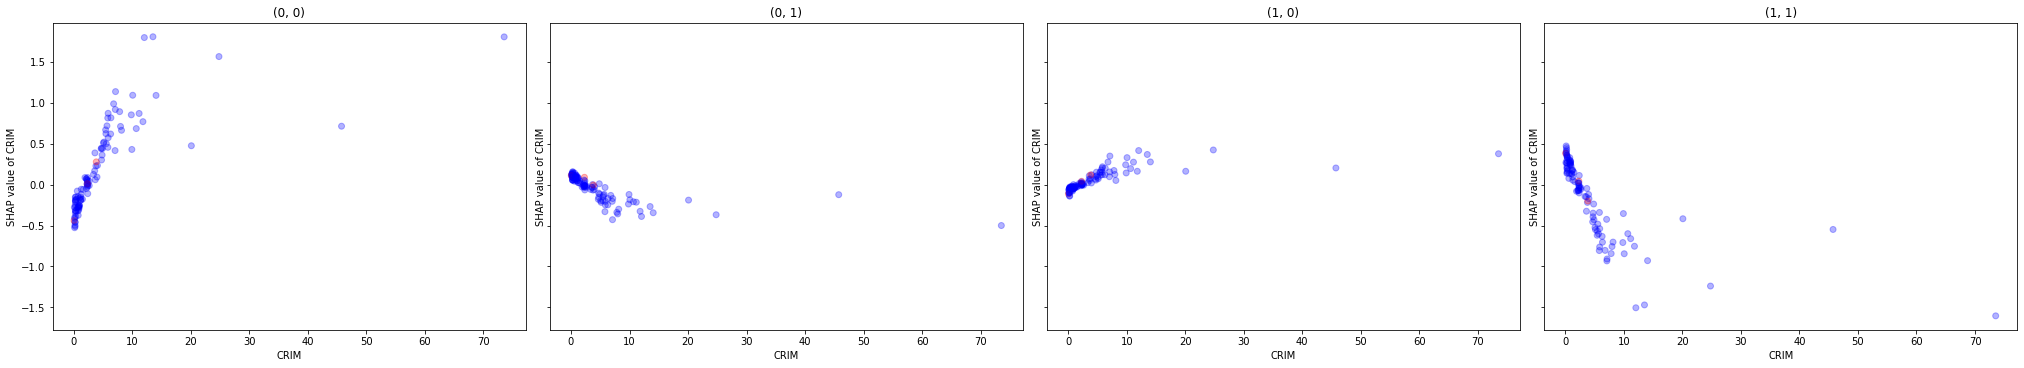

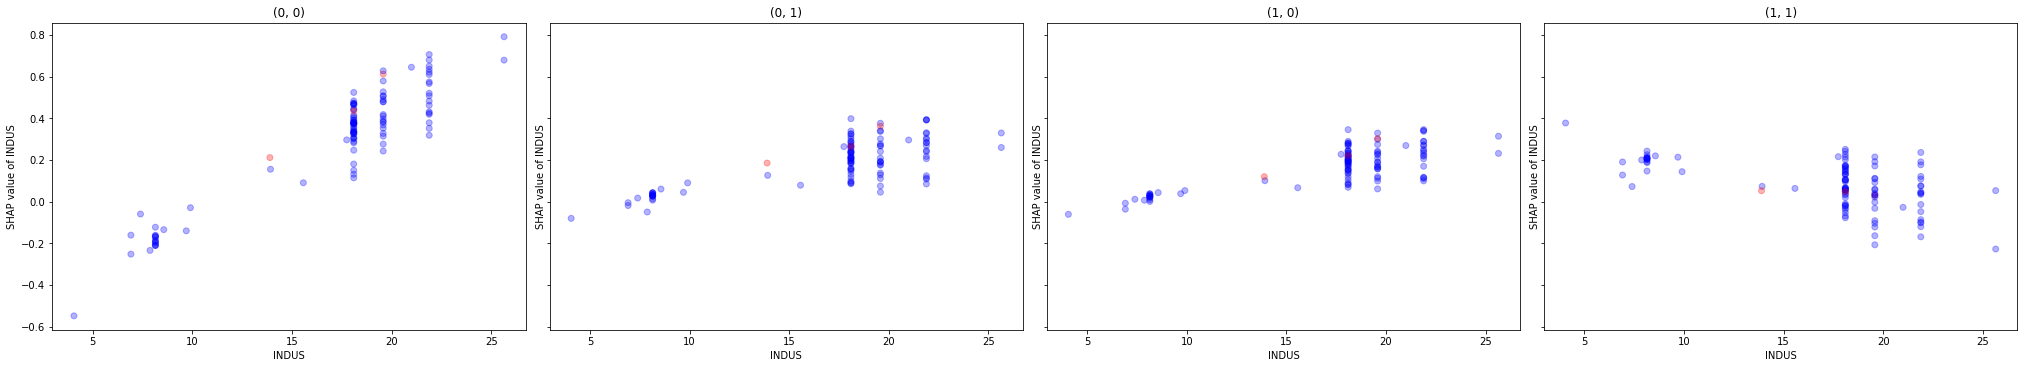

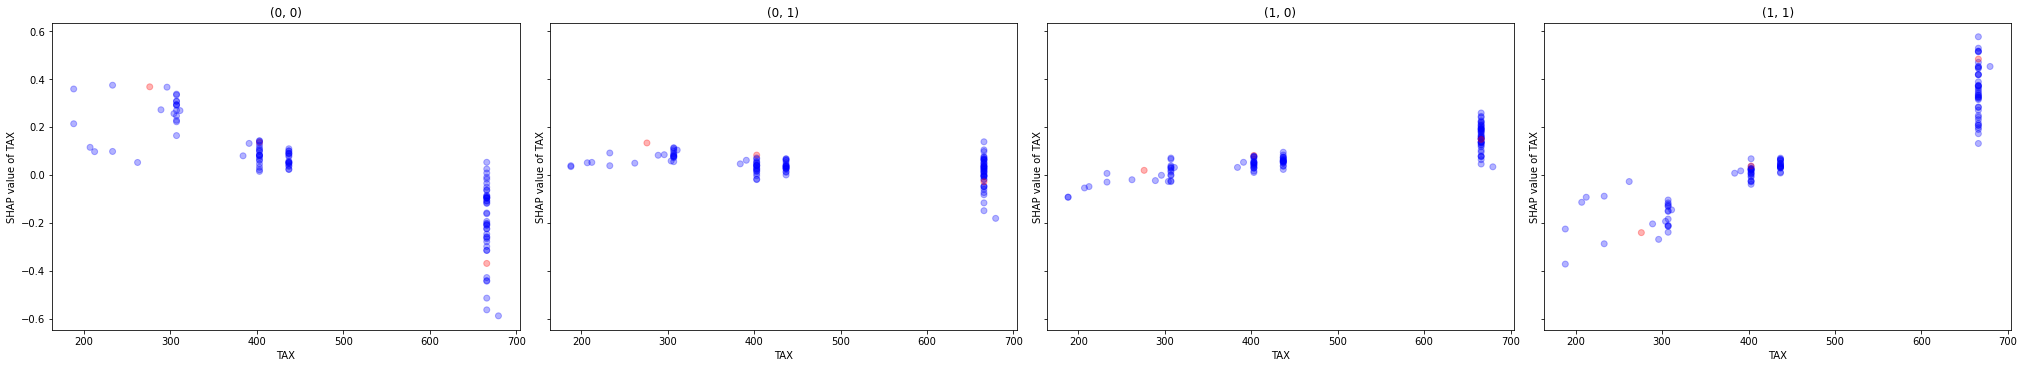

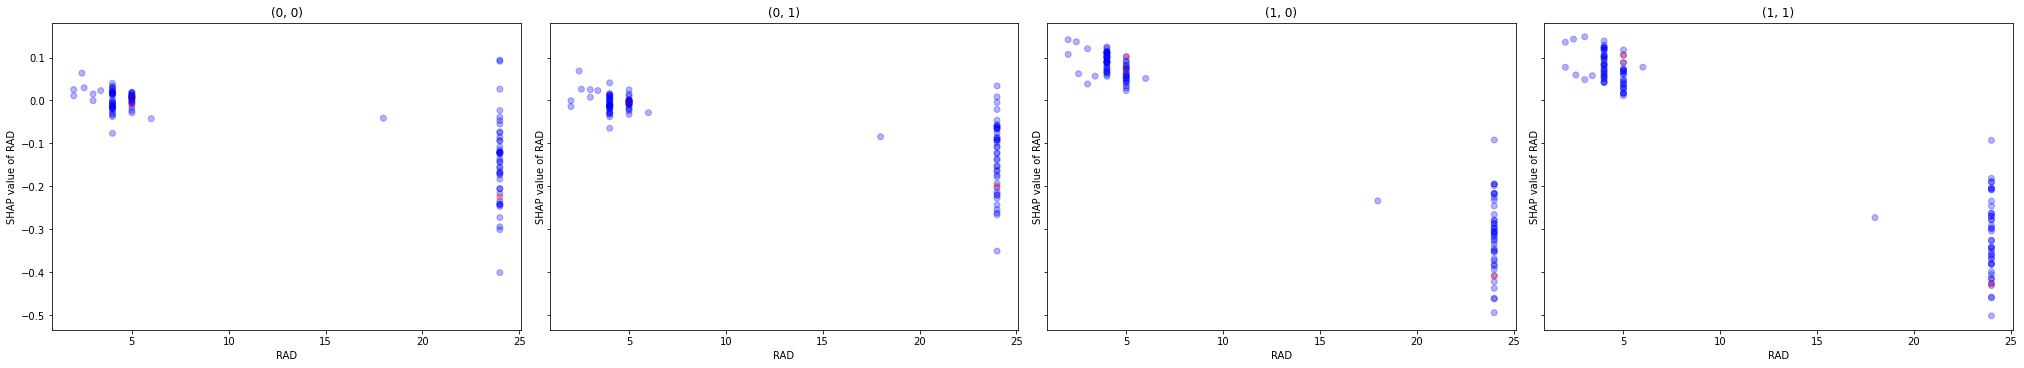

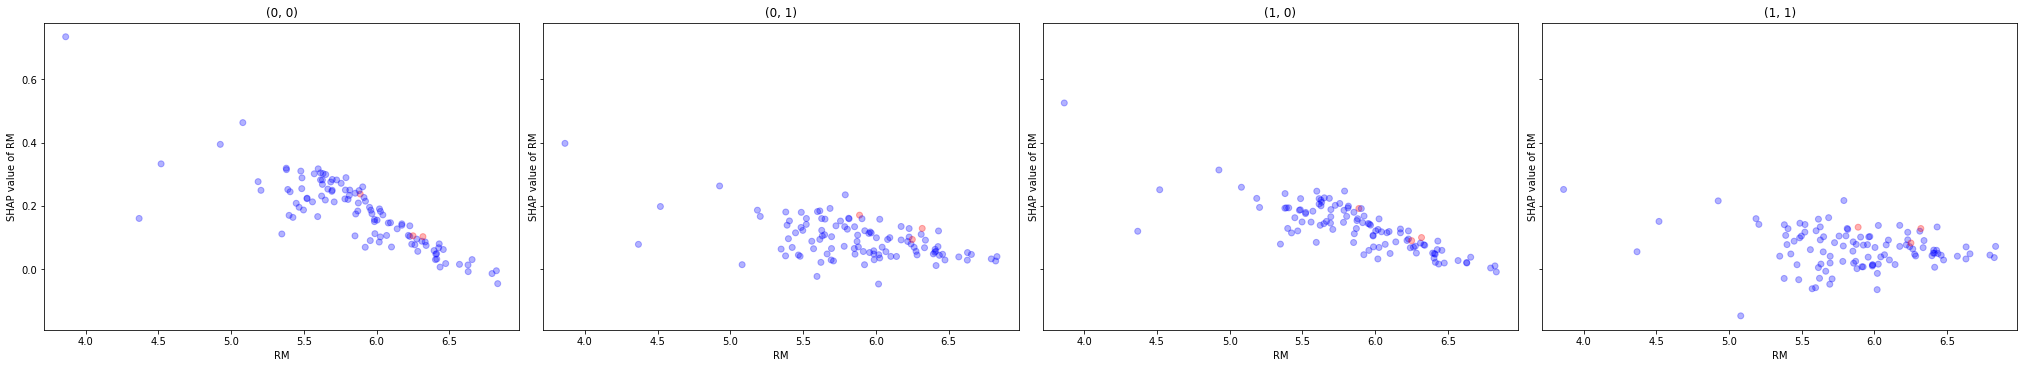

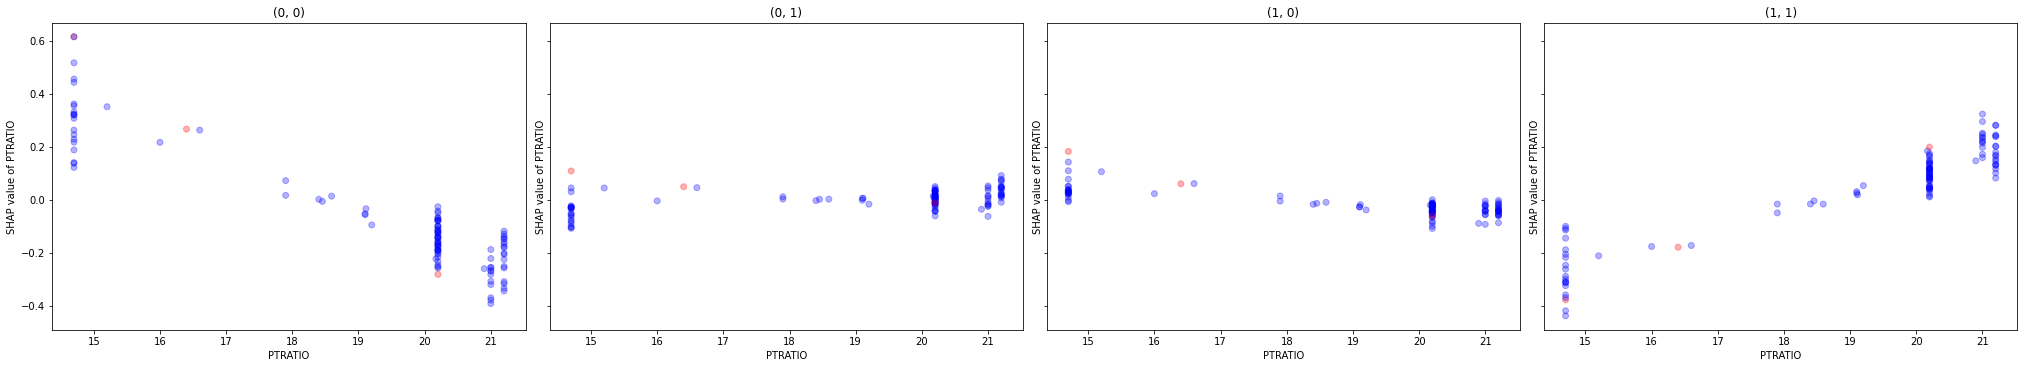

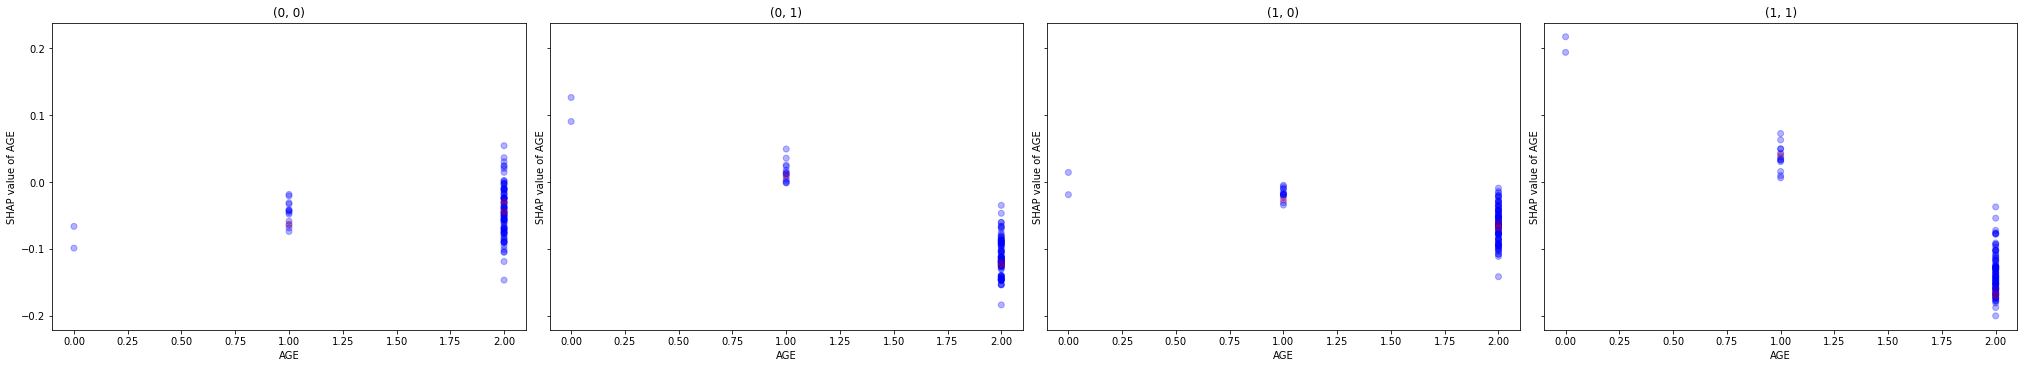

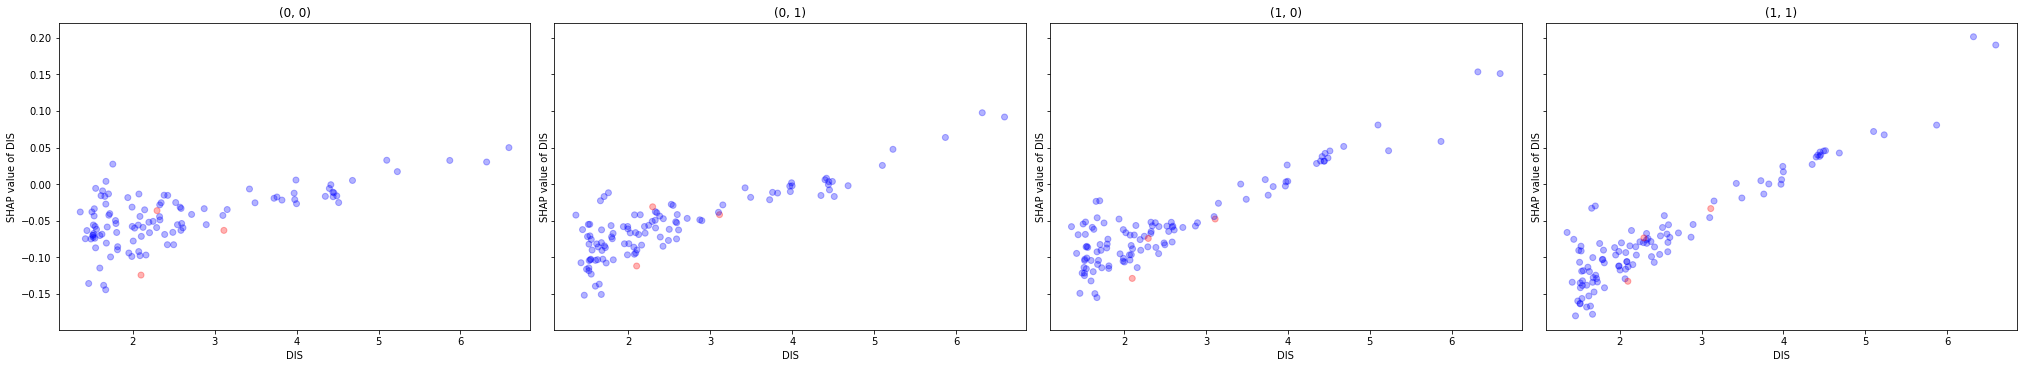

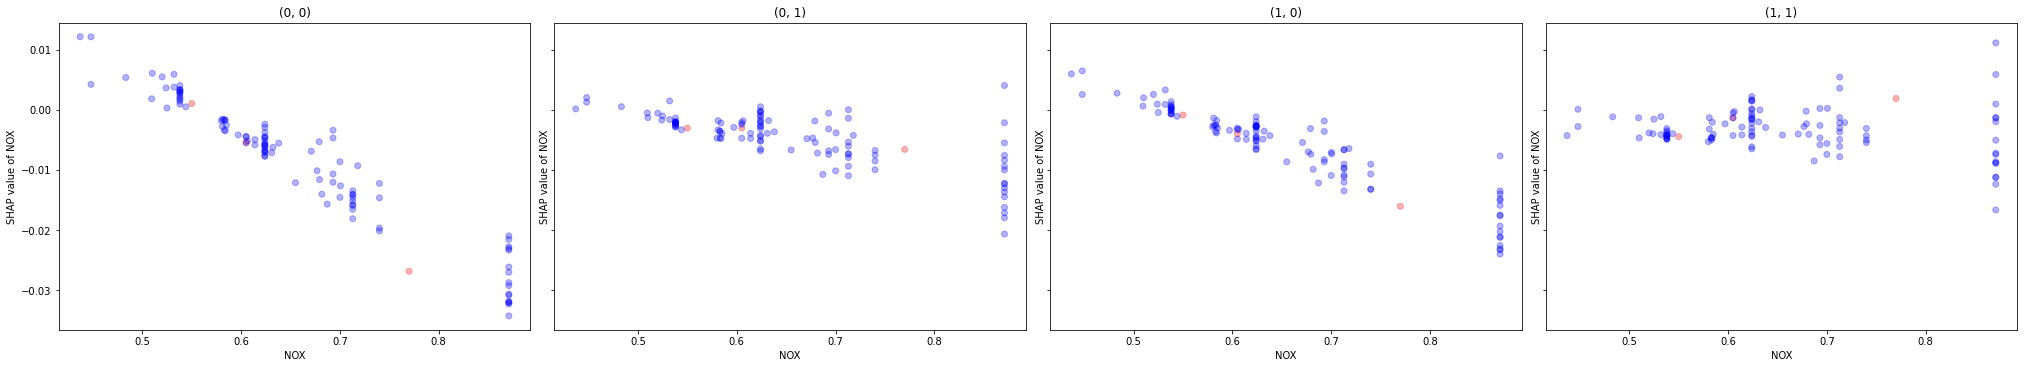

In [18]:
for feature in feature_order:
    clustering.plot_feature(feature, alpha=0.3)

In [33]:
clustering.test(LSTAT=14.9)

before  after
(0, 0)     NaN    3.0
(0, 1)     3.0    NaN

## Clustering of (1,0) SHAP Values

In [34]:
clustering = make_clustering(comparer, explanations.mclass_diff.log_odds, '(1, 0)', '(0, 0)', '(1, 1)')

node #490 (level 0)
(2, 2)    96
(0, 0)    86
(1, 1)    52
(1, 2)     5
(0, 1)     3
(2, 1)     2
(1, 0)     2
dtype: int64


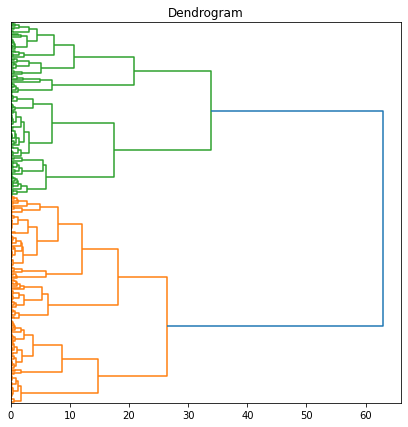

In [35]:
clustering.plot_dendrogram()

In [36]:
clustering.go_down()

node #488 (level 1)
(0, 0)    86
(1, 1)    41
(0, 1)     3
(1, 0)     2
(2, 2)     1
(1, 2)     1
dtype: int64


This cluster contains very diverse difference classes, I will try again with a subcluster.

In [37]:
clustering.go_down()

node #484 (level 2)
(0, 0)    54
dtype: int64


In [38]:
clustering.get_next()

node #488 (level 1)
(0, 0)    86
(1, 1)    41
(0, 1)     3
(1, 0)     2
(2, 2)     1
(1, 2)     1
dtype: int64
node #486 (level 2)
(1, 1)    41
(0, 0)    32
(0, 1)     3
(1, 0)     2
(2, 2)     1
(1, 2)     1
dtype: int64


In [39]:
clustering.go_down()

node #476 (level 3)
(1, 1)    24
(2, 2)     1
(1, 2)     1
dtype: int64


In [40]:
clustering.get_next()

node #486 (level 2)
(1, 1)    41
(0, 0)    32
(0, 1)     3
(1, 0)     2
(2, 2)     1
(1, 2)     1
dtype: int64
node #483 (level 3)
(0, 0)    32
(1, 1)    17
(0, 1)     3
(1, 0)     2
dtype: int64


Cluster characteristics:
- 10.5 < LSTAT < 21.9
- ZN ≤ 12.5
- 4 < INDUS
- CRIM < 7.2
- RM < 6.5
- 2 ≤ RAD (not relevant)
- DIS < 6.6 (not relevant)

Differences:
- 16.4 < LSTAT < 16.6
- ZN=0
- INDUS=8.14
- CRIM < 0.9
- RM < 5.7
- RAD=4
- TAX=307
- AGE=2
- DIS = 4.5
- PTRATIO=21

Counterfactuals:
- $LSTAT=16.8 \rightarrow (0,0)$
- $LSTAT=16.3 \rightarrow (1,1)$

In [41]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

LSTAT


global  local-all  local-diff
count  246.000000  54.000000    2.000000
mean    11.736981  15.885395   16.493291
std      7.372550   2.486715    0.023630
min      1.763949  10.580000   16.476581
25%      5.008267  14.337500   16.484936
50%      9.950000  16.334797   16.493291
75%     17.091674  17.338671   16.501645
max     36.980000  21.849034   16.510000

ZN


global  local-all  local-diff
count  246.000000  54.000000         2.0
mean    12.841063   0.231481         0.0
std     25.552540   1.701035         0.0
min      0.000000   0.000000         0.0
25%      0.000000   0.000000         0.0
50%      0.000000   0.000000         0.0
75%     20.000000   0.000000         0.0
max    100.000000  12.500000         0.0

INDUS


global  local-all  local-diff
count  246.000000  54.000000        2.00
mean    11.718208  16.081667        8.14
std      7.290396   5.874219        0.00
min      1.210000   4.050000        8.14
25%      4.243588   8.245000        8.14
50%      9.900000  18.840000        8.14
75%     18.100000  19.580000        8.14
max     25.650000  25.650000        8.14

CRIM


global  local-all  local-diff
count  246.000000  54.000000    2.000000
mean     2.720010   1.647136    0.833357
std      6.388147   1.540196    0.010159
min      0.009060   0.045600    0.826173
25%      0.099321   0.330259    0.829765
50%      0.540032   1.056103    0.833357
75%      3.181873   2.329966    0.836948
max     73.534100   7.129026    0.840540

RM


global  local-all  local-diff
count  246.000000  54.000000    2.000000
mean     6.511388   5.828364    5.624860
std      0.889747   0.281950    0.036571
min      3.561000   5.080871    5.599000
25%      5.882000   5.629087    5.611930
50%      6.315500   5.797131    5.624860
75%      7.134552   5.985950    5.637789
max      8.638029   6.437000    5.650719

RAD


global  local-all  local-diff
count  246.000000  54.000000         2.0
mean     9.346908   7.296296         4.0
std      8.493772   7.067410         0.0
min      1.000000   2.000000         4.0
25%      4.000000   4.000000         4.0
50%      5.000000   5.000000         4.0
75%      8.000000   5.000000         4.0
max     24.000000  24.000000         4.0

TAX


global   local-all  local-diff
count  246.000000   54.000000         2.0
mean   403.132604  405.777778       307.0
std    165.416533  126.211363         0.0
min    188.000000  188.000000       307.0
25%    273.000000  307.000000       307.0
50%    362.186013  403.000000       307.0
75%    461.000000  437.000000       307.0
max    679.526743  666.000000       307.0

AGE


global  local-all  local-diff
count  246.000000  54.000000         2.0
mean     1.304878   1.759259         2.0
std      0.813494   0.511571         0.0
min      0.000000   0.000000         2.0
25%      1.000000   2.000000         2.0
50%      2.000000   2.000000         2.0
75%      2.000000   2.000000         2.0
max      2.000000   2.000000         2.0

DIS


global  local-all  local-diff
count  246.000000  54.000000    2.000000
mean     3.501706   2.863210    4.450224
std      2.007156   1.325620    0.006189
min      1.137912   1.488436    4.445848
25%      1.967365   1.719184    4.448036
50%      2.866600   2.405350    4.450224
75%      4.621654   3.988000    4.452412
max     10.710300   6.592100    4.454600

PTRATIO


global  local-all  local-diff
count  246.000000  54.000000         2.0
mean    18.125578  18.350000        21.0
std      2.524334   2.838266         0.0
min     13.000000  14.700000        21.0
25%     15.707491  14.700000        21.0
50%     18.571912  20.200000        21.0
75%     20.200000  21.000000        21.0
max     22.000000  21.200000        21.0

NOX


global  local-all  local-diff
count  246.000000  54.000000       2.000
mean     0.572581   0.642222       0.538
std      0.125307   0.138840       0.000
min      0.389000   0.437000       0.538
25%      0.462112   0.538000       0.538
50%      0.544000   0.584500       0.538
75%      0.638740   0.733500       0.538
max      0.871000   0.871000       0.538

In [56]:
clustering.test(LSTAT=10.5)

before  after
(1, 0)     2.0    NaN
(1, 1)     NaN    2.0

In [57]:
clustering.test(LSTAT=21.9)

before  after
(0, 0)     NaN    2.0
(1, 0)     2.0    NaN

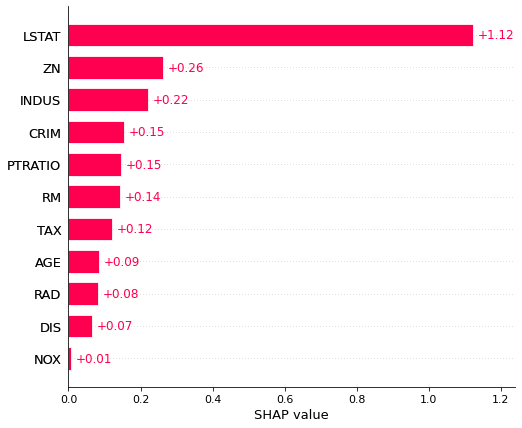

In [53]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

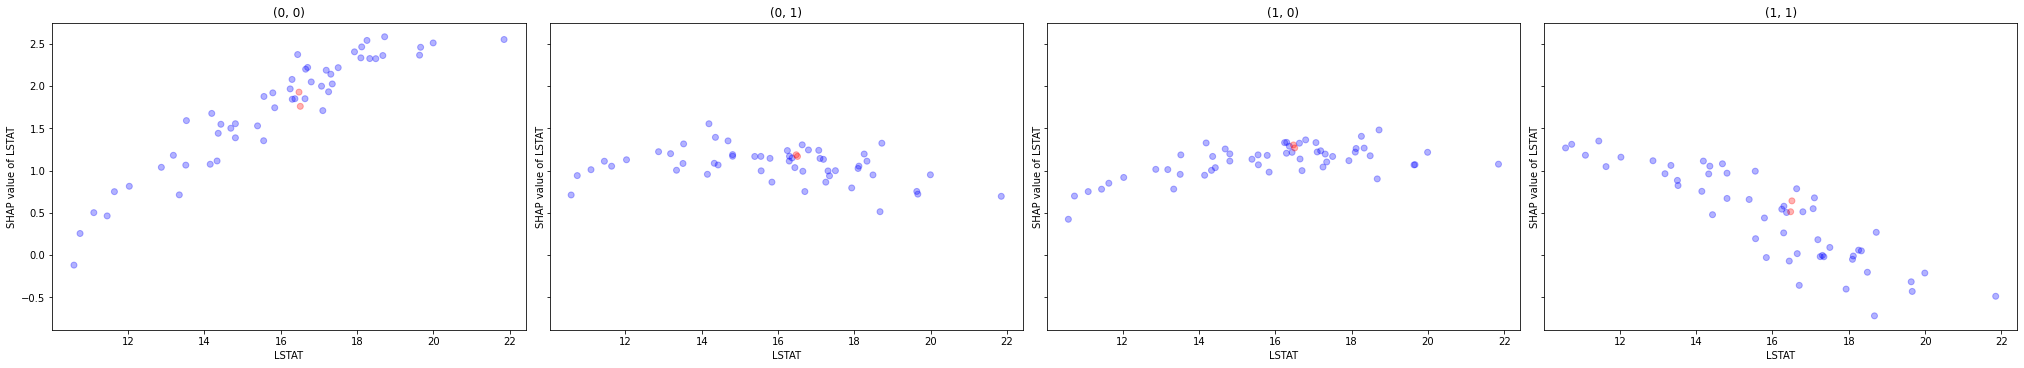

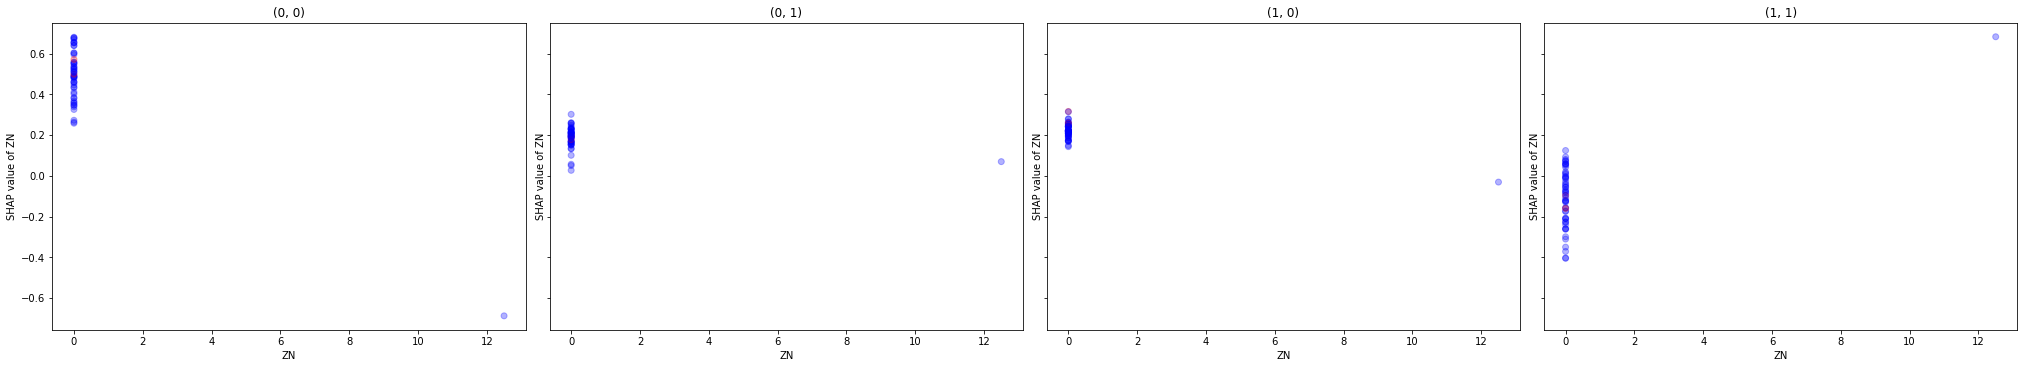

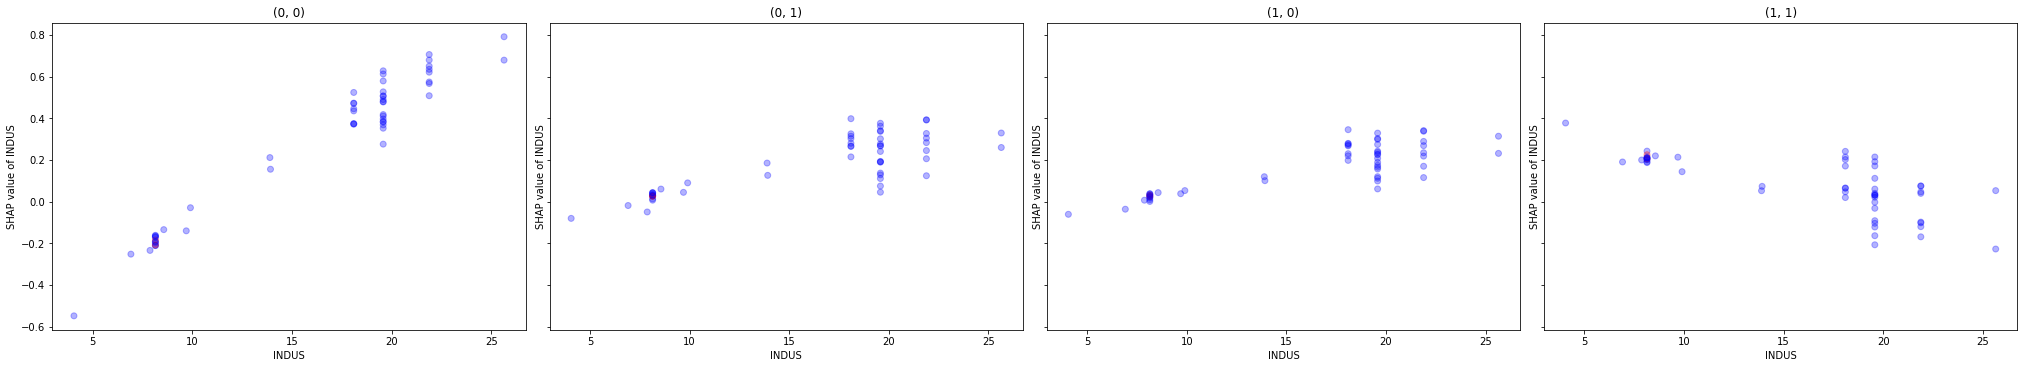

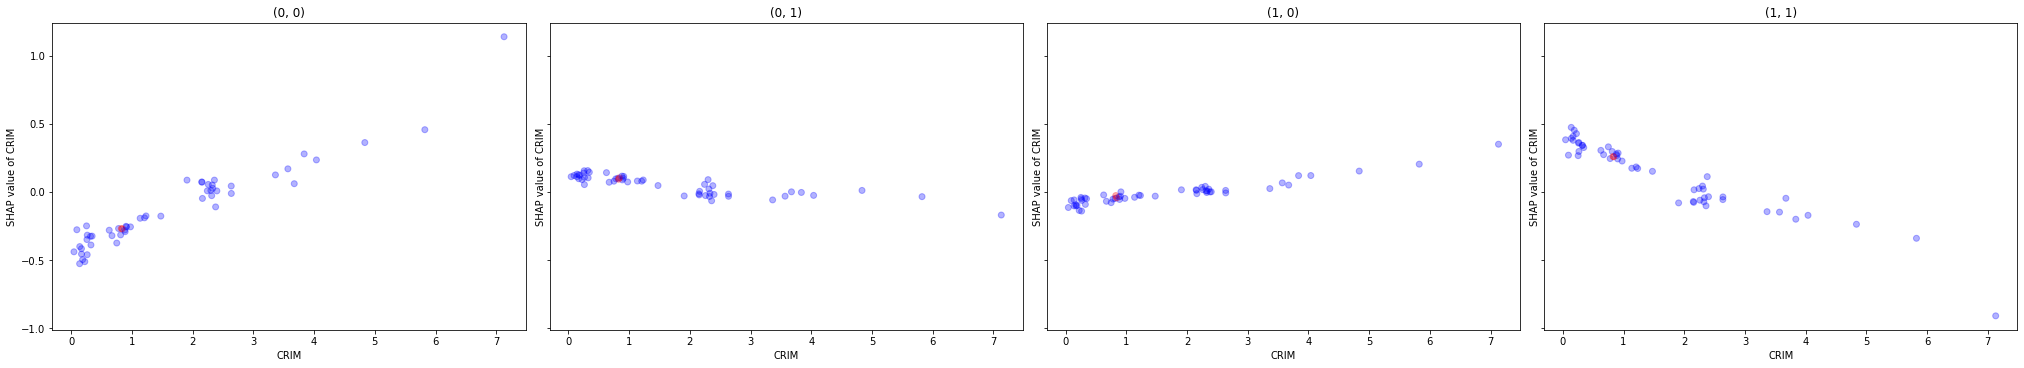

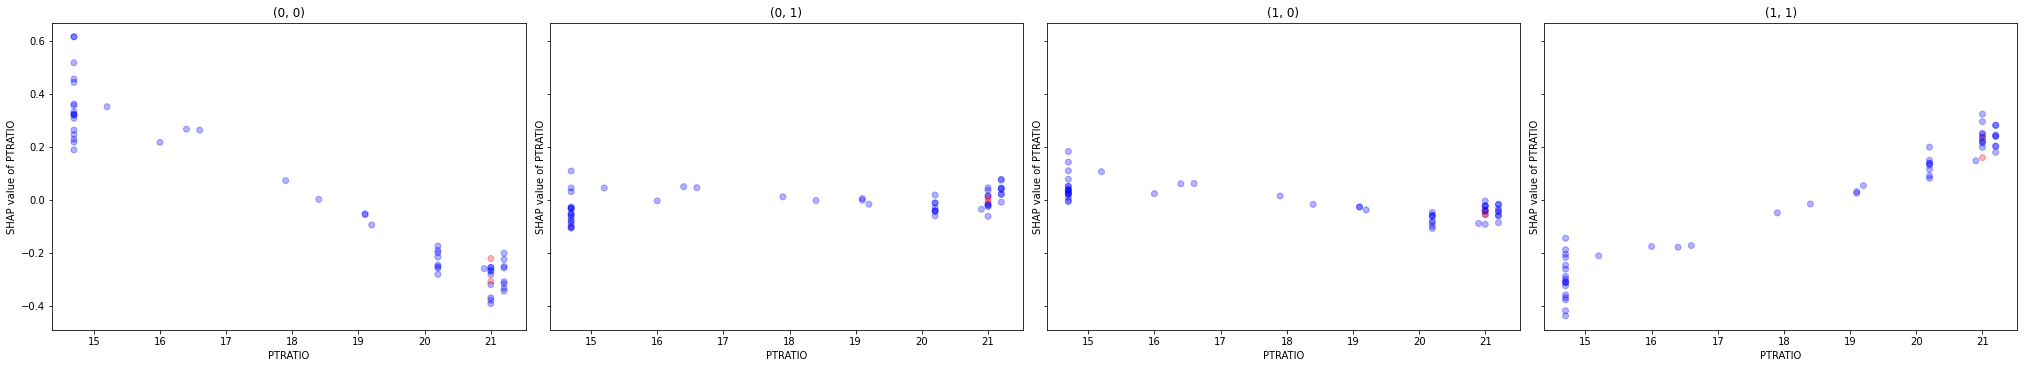

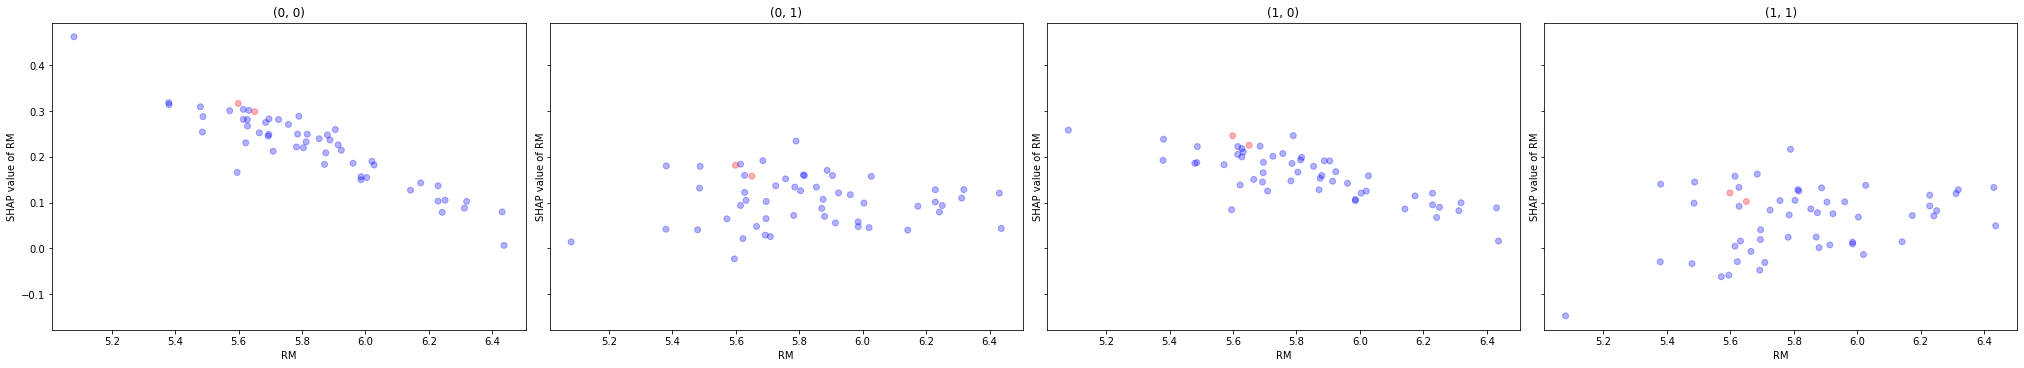

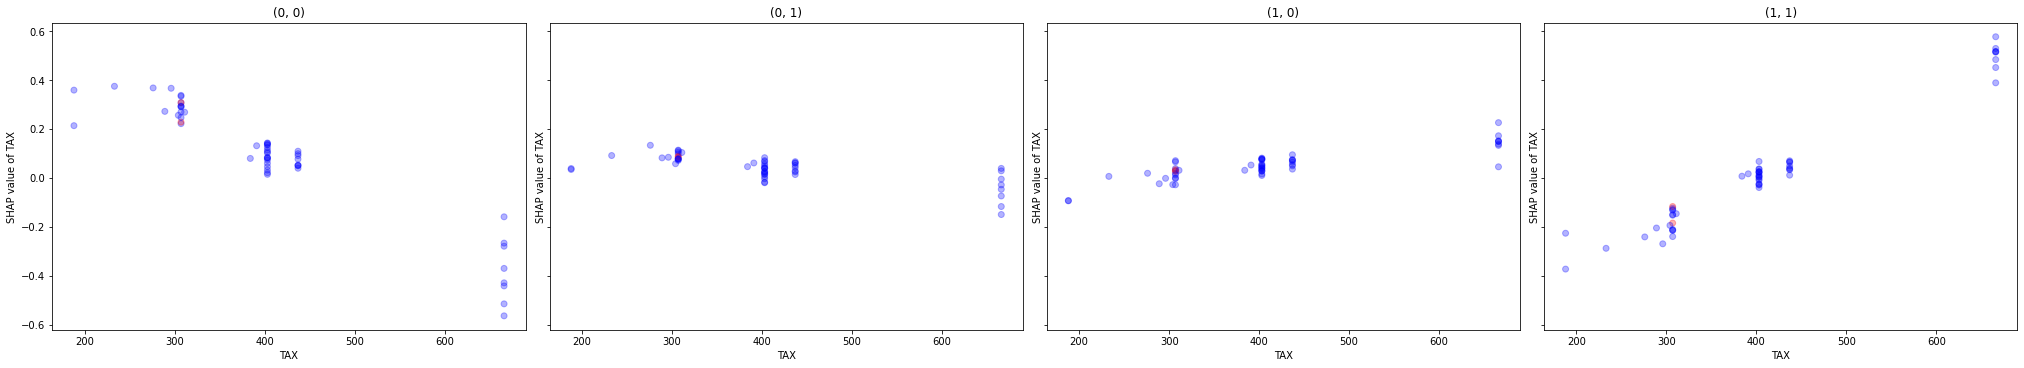

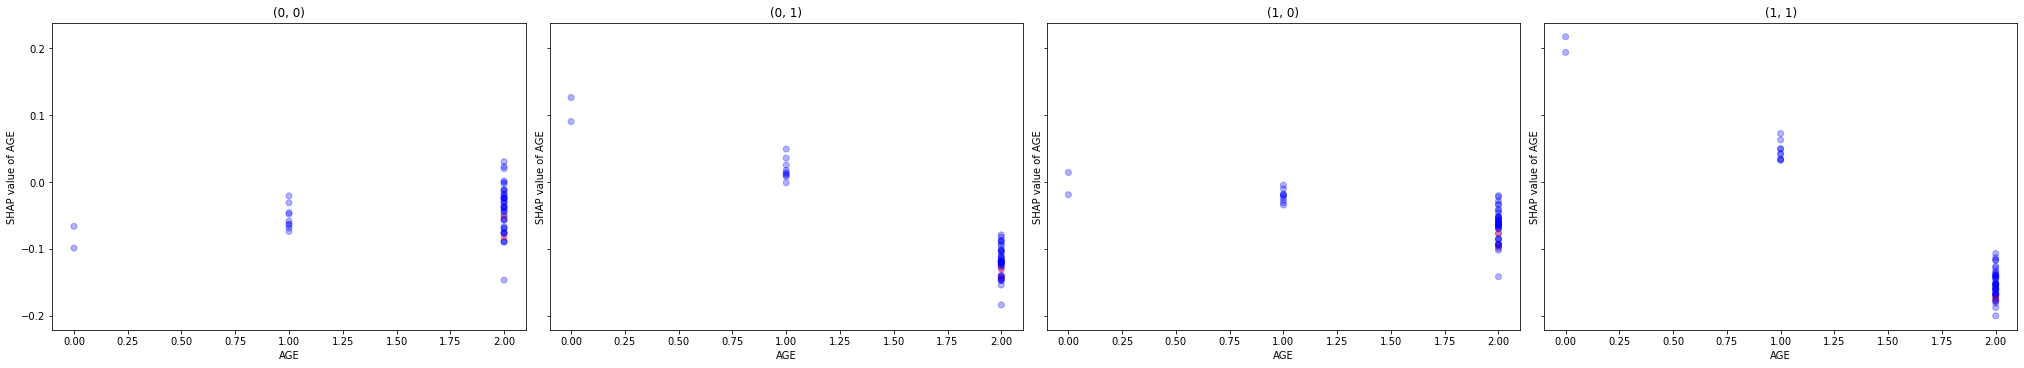

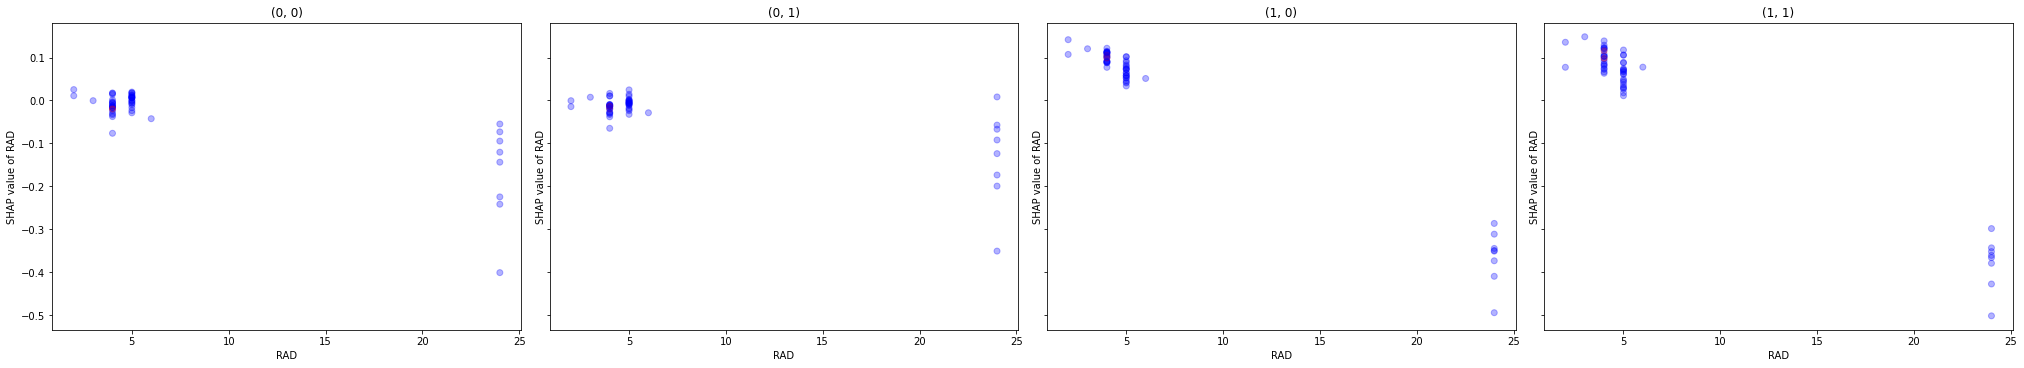

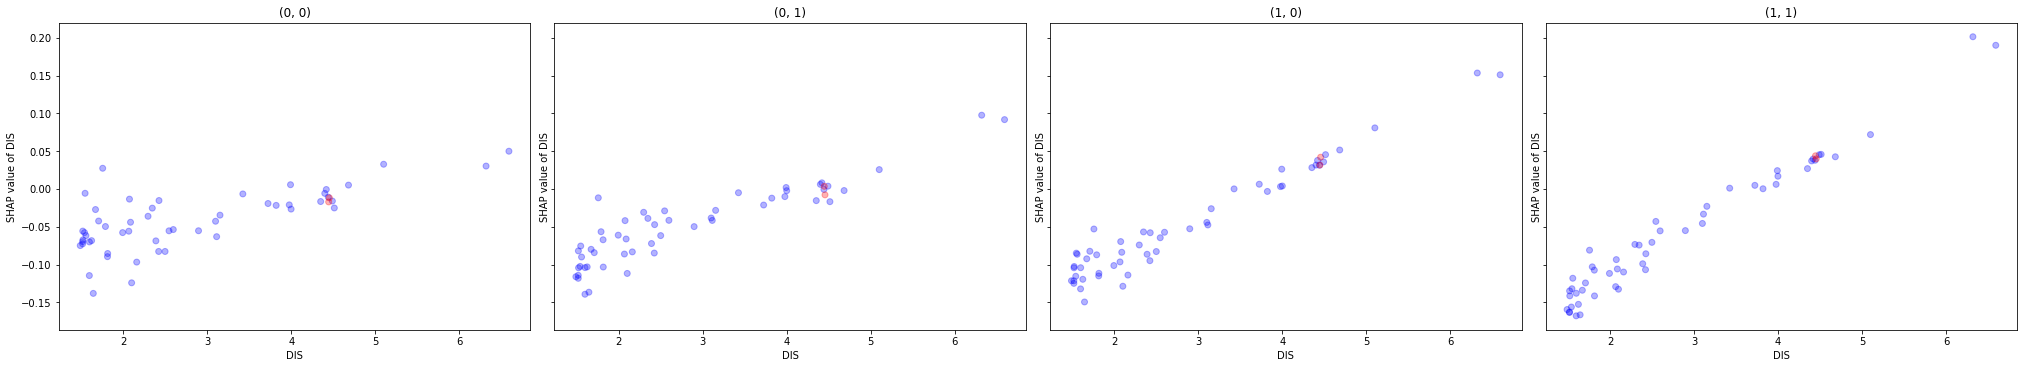

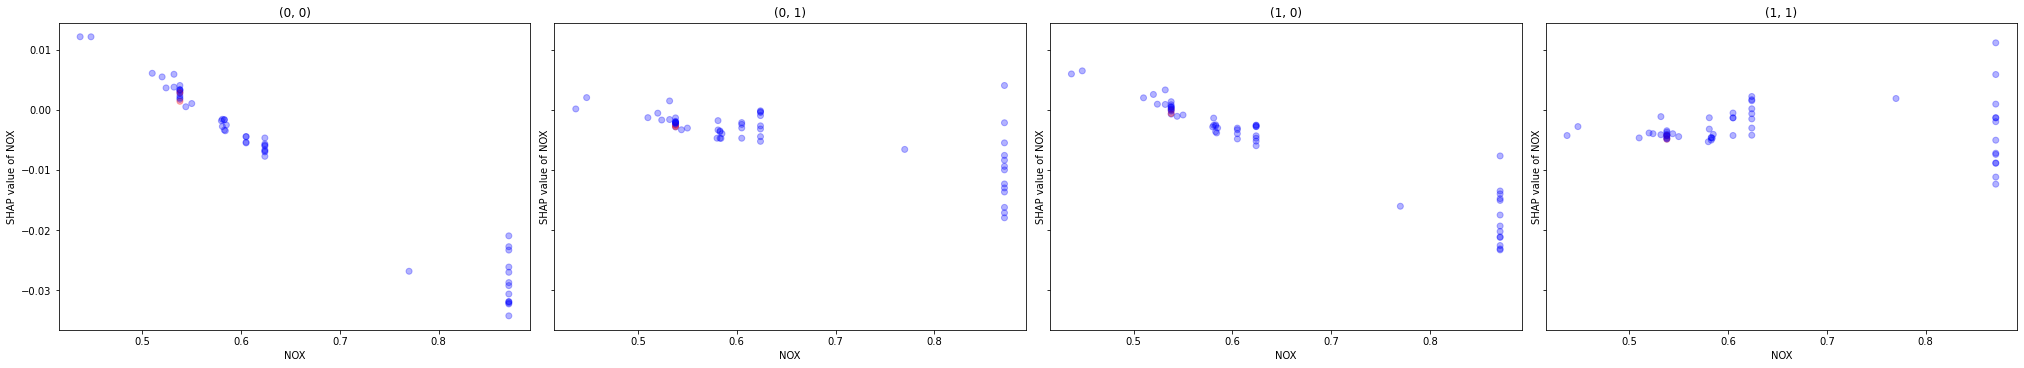

In [54]:
for feature in feature_order:
    clustering.plot_feature(feature, alpha=0.3)

In [46]:
clustering.test(LSTAT=16.3)

before  after
(1, 0)     2.0    NaN
(1, 1)     NaN    2.0

In [52]:
clustering.test(LSTAT=16.8)

before  after
(0, 0)     NaN    2.0
(1, 0)     2.0    NaN

In this case I can refine the originally found counterfactuals, based on the knowledge obtained from the local explanations.

## Clustering of (1,2) SHAP Values

In [70]:
clustering = make_clustering(comparer, explanations.mclass_diff.log_odds, '(1, 2)', '(1, 1)', '(2, 2)')

node #490 (level 0)
(2, 2)    96
(0, 0)    86
(1, 1)    52
(1, 2)     5
(0, 1)     3
(2, 1)     2
(1, 0)     2
dtype: int64


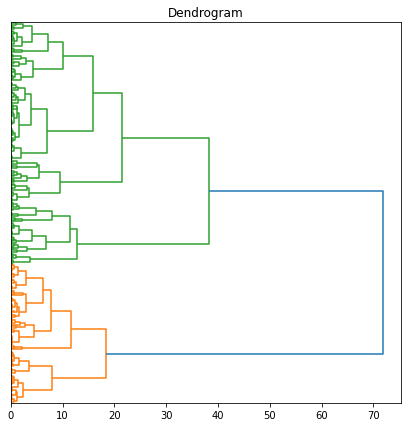

In [71]:
clustering.plot_dendrogram()

### Cluster 1

In [72]:
clustering.go_down()

node #487 (level 1)
(0, 0)    83
(1, 1)     5
(1, 0)     2
dtype: int64


In [73]:
clustering.get_next()

node #490 (level 0)
(2, 2)    96
(0, 0)    86
(1, 1)    52
(1, 2)     5
(0, 1)     3
(2, 1)     2
(1, 0)     2
dtype: int64
node #489 (level 1)
(2, 2)    96
(1, 1)    47
(1, 2)     5
(0, 0)     3
(0, 1)     3
(2, 1)     2
dtype: int64


In [74]:
clustering.go_down()

node #485 (level 2)
(1, 1)    32
(0, 0)     3
(0, 1)     3
(2, 2)     1
(1, 2)     1
dtype: int64


In [75]:
clustering.go_down()

node #465 (level 3)
(1, 1)    6
(0, 1)    1
dtype: int64


In [76]:
clustering.get_next()

node #485 (level 2)
(1, 1)    32
(0, 0)     3
(0, 1)     3
(2, 2)     1
(1, 2)     1
dtype: int64
node #483 (level 3)
(1, 1)    26
(0, 0)     3
(0, 1)     2
(1, 2)     1
(2, 2)     1
dtype: int64


In [77]:
clustering.go_down()

node #475 (level 4)
(1, 1)    18
(2, 2)     1
(1, 2)     1
dtype: int64


Cluster characteristics:
- 8.2 < LSTAT < 13.2
- ZN ≤ 55
- INDUS < 15.1
- CRIM < 0.6 (not relevant)
- RM < 7.3
- RAD ≤ 8
- TAX ≤ 430
- 2.1 < DIS < 8.0

Difference:
- LSTAT=9.52
- ZN=20
- INDUS=3.97
- CRIM=0.54 (not relevant)
- RM=7.23
- RAD=5
- TAX=264
- AGE=1
- DIS=2.12
- PRATIO=13

Counterfactuals:
- $LSTAT=9.8 \rightarrow (1,1)$
- $LSTAT=9.4 \rightarrow (2,2)$

In [78]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

LSTAT


global  local-all  local-diff
count  246.000000  20.000000    1.000000
mean    11.736981  10.828706    9.522242
std      7.372550   1.513602         NaN
min      1.763949   8.230000    9.522242
25%      5.008267   9.519182    9.522242
50%      9.950000  10.495000    9.522242
75%     17.091674  12.295471    9.522242
max     36.980000  13.150000    9.522242

ZN


global  local-all  local-diff
count  246.000000  20.000000         1.0
mean    12.841063  16.575000        20.0
std     25.552540  17.821686         NaN
min      0.000000   0.000000        20.0
25%      0.000000   0.000000        20.0
50%      0.000000  20.000000        20.0
75%     20.000000  25.750000        20.0
max    100.000000  55.000000        20.0

INDUS


global  local-all  local-diff
count  246.000000  20.000000        1.00
mean    11.718208   7.080144        3.97
std      7.290396   3.568197         NaN
min      1.210000   2.180000        3.97
25%      4.243588   5.080000        3.97
50%      9.900000   5.750000        3.97
75%     18.100000   9.579664        3.97
max     25.650000  15.040000        3.97

CRIM


global  local-all  local-diff
count  246.000000  20.000000    1.000000
mean     2.720010   0.151011    0.539742
std      6.388147   0.133779         NaN
min      0.009060   0.010960    0.539742
25%      0.099321   0.054925    0.539742
50%      0.540032   0.117215    0.539742
75%      3.181873   0.181503    0.539742
max     73.534100   0.539742    0.539742

RM


global  local-all  local-diff
count  246.000000  20.000000    1.000000
mean     6.511388   6.189391    7.225003
std      0.889747   0.417660         NaN
min      3.561000   5.593000    7.225003
25%      5.882000   5.865000    7.225003
50%      6.315500   6.155000    7.225003
75%      7.134552   6.458250    7.225003
max      8.638029   7.225003    7.225003

RAD


global  local-all  local-diff
count  246.000000  20.000000         1.0
mean     9.346908   4.994028         5.0
std      8.493772   1.720655         NaN
min      1.000000   1.000000         5.0
25%      4.000000   4.000000         5.0
50%      5.000000   5.000000         5.0
75%      8.000000   6.000000         5.0
max     24.000000   8.000000         5.0

TAX


global   local-all  local-diff
count  246.000000   20.000000         1.0
mean   403.132604  299.576001       264.0
std    165.416533   58.341316         NaN
min    188.000000  222.000000       264.0
25%    273.000000  268.500000       264.0
50%    362.186013  291.000000       264.0
75%    461.000000  310.500000       264.0
max    679.526743  430.000000       264.0

AGE


global  local-all  local-diff
count  246.000000  20.000000         1.0
mean     1.304878   0.650000         1.0
std      0.813494   0.587143         NaN
min      0.000000   0.000000         1.0
25%      1.000000   0.000000         1.0
50%      2.000000   1.000000         1.0
75%      2.000000   1.000000         1.0
max      2.000000   2.000000         1.0

DIS


global  local-all  local-diff
count  246.000000  20.000000    1.000000
mean     3.501706   4.995920    2.115348
std      2.007156   2.008159         NaN
min      1.137912   2.115348    2.115348
25%      1.967365   3.491875    2.115348
50%      2.866600   4.620600    2.115348
75%      4.621654   7.082975    2.115348
max     10.710300   7.980900    2.115348

PTRATIO


global  local-all  local-diff
count  246.000000  20.000000         1.0
mean    18.125578  18.072014        13.0
std      2.524334   1.974070         NaN
min     13.000000  13.000000        13.0
25%     15.707491  16.750000        13.0
50%     18.571912  18.400000        13.0
75%     20.200000  19.325000        13.0
max     22.000000  20.900000        13.0

NOX


global  local-all  local-diff
count  246.000000  20.000000       1.000
mean     0.572581   0.482377       0.647
std      0.125307   0.062886         NaN
min      0.389000   0.389000       0.647
25%      0.462112   0.438500       0.647
50%      0.544000   0.464000       0.647
75%      0.638740   0.520000       0.647
max      0.871000   0.647000       0.647

In [81]:
clustering.test(LSTAT=8.2)

before  after
(1, 2)     1.0    NaN
(2, 2)     NaN    1.0

In [82]:
clustering.test(LSTAT=13.2)

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

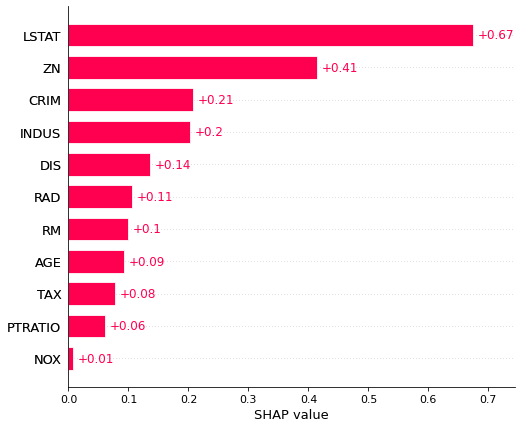

In [83]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

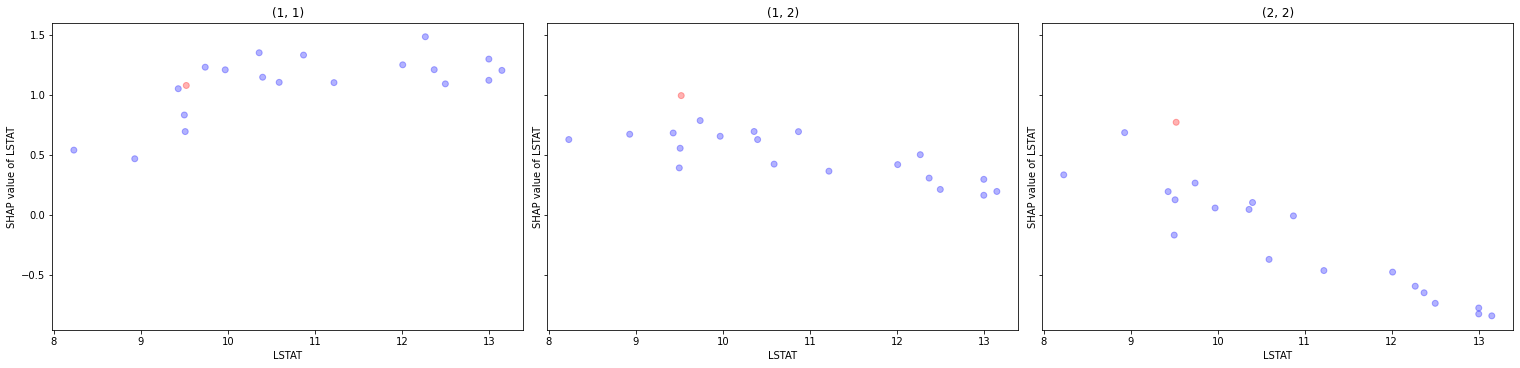

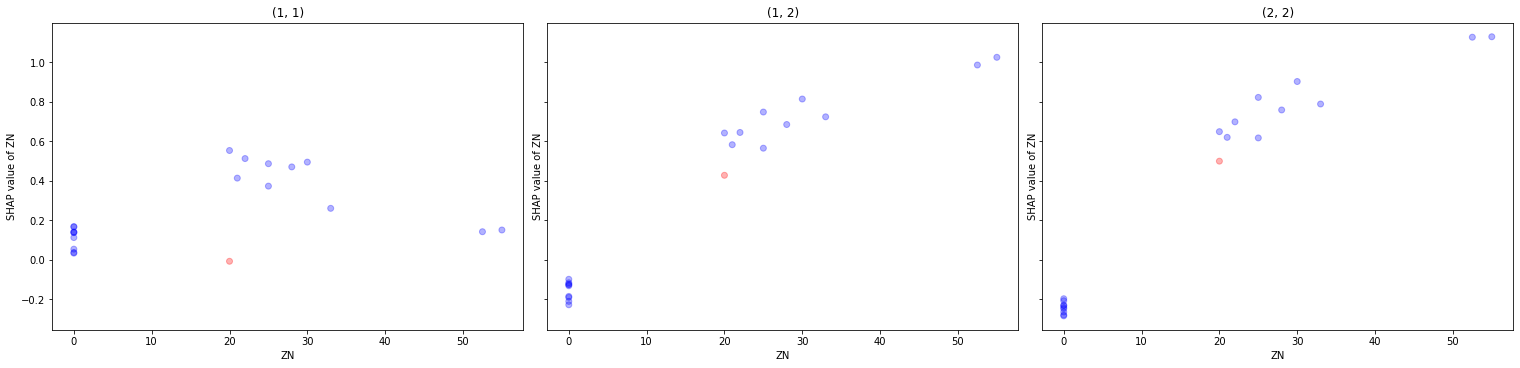

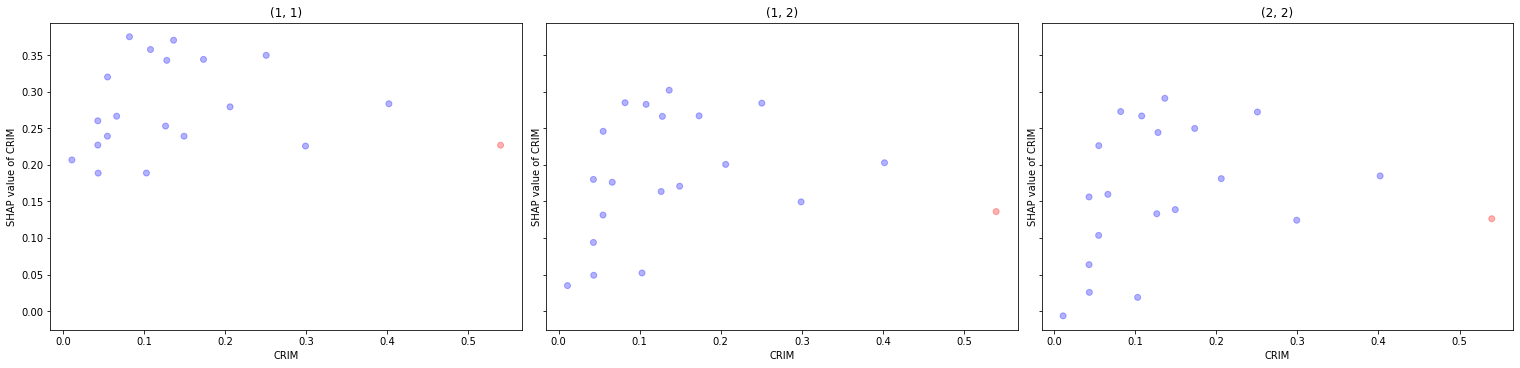

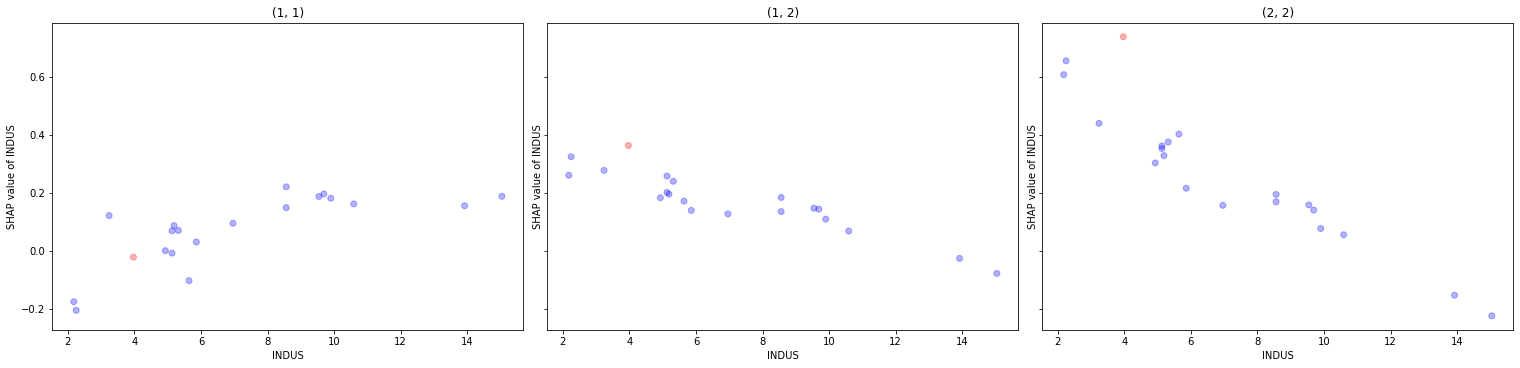

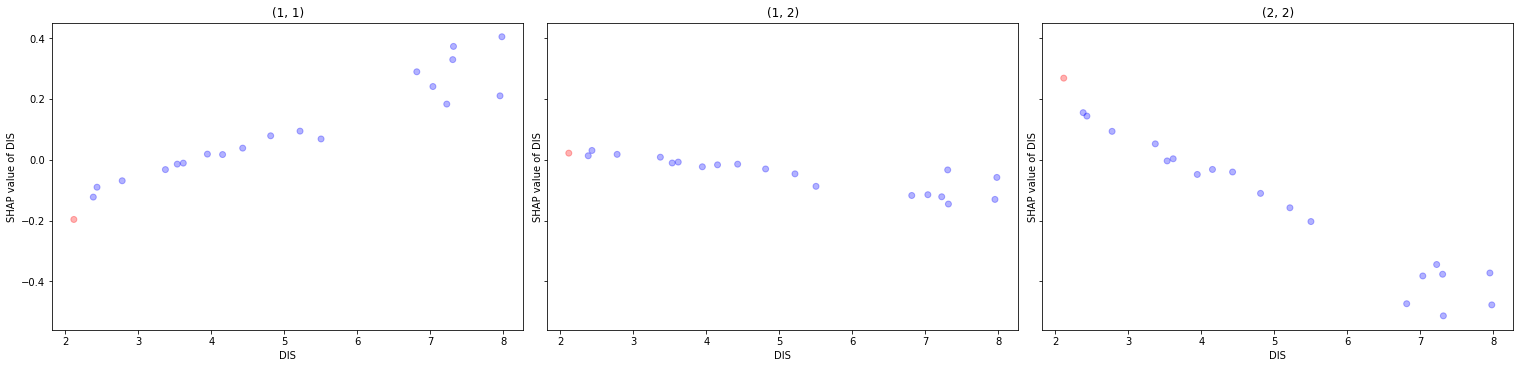

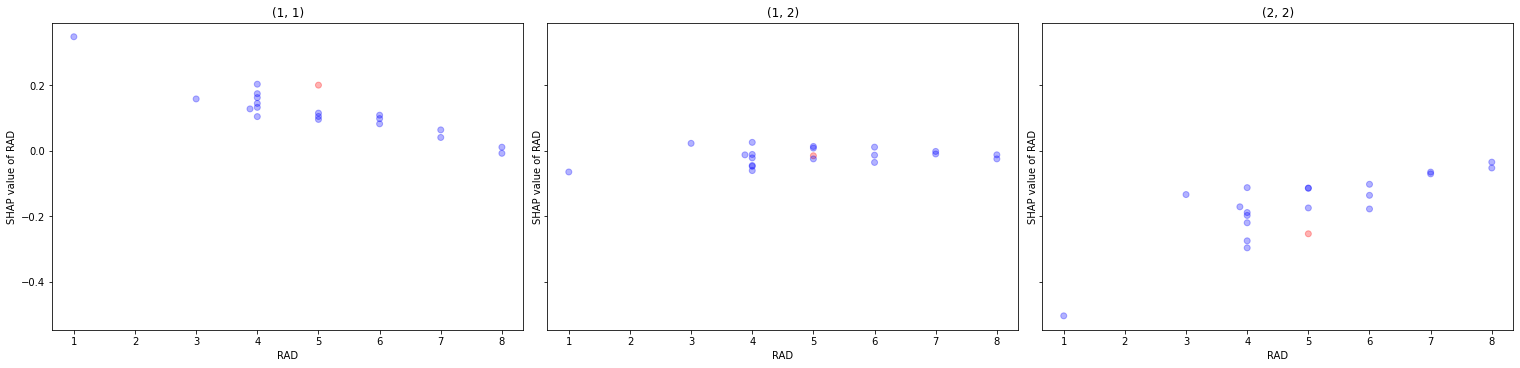

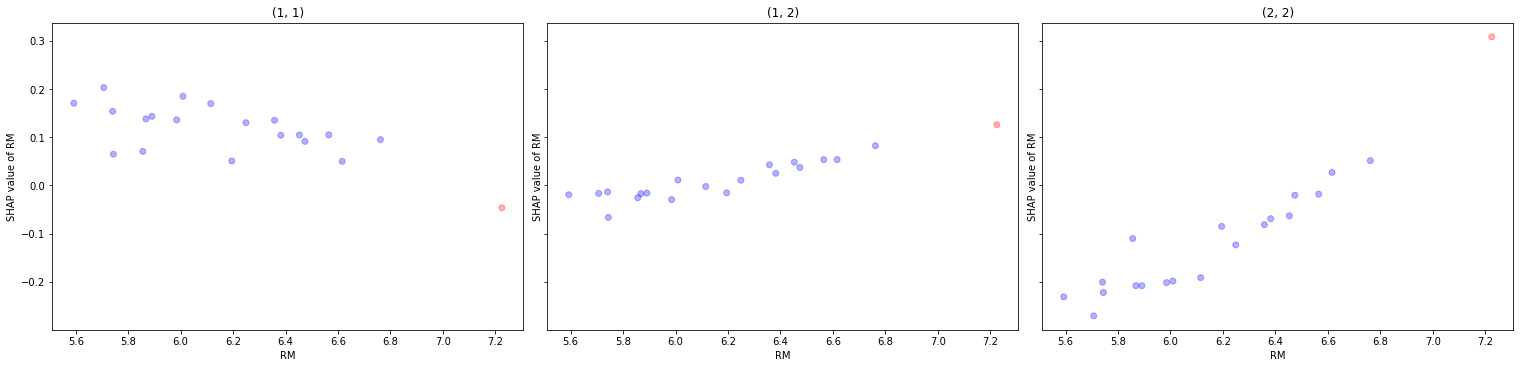

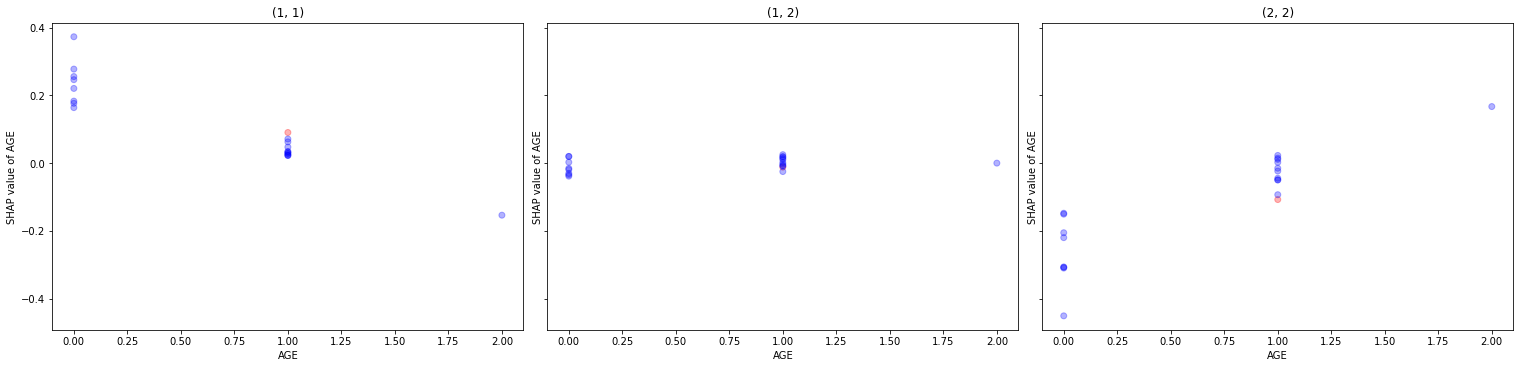

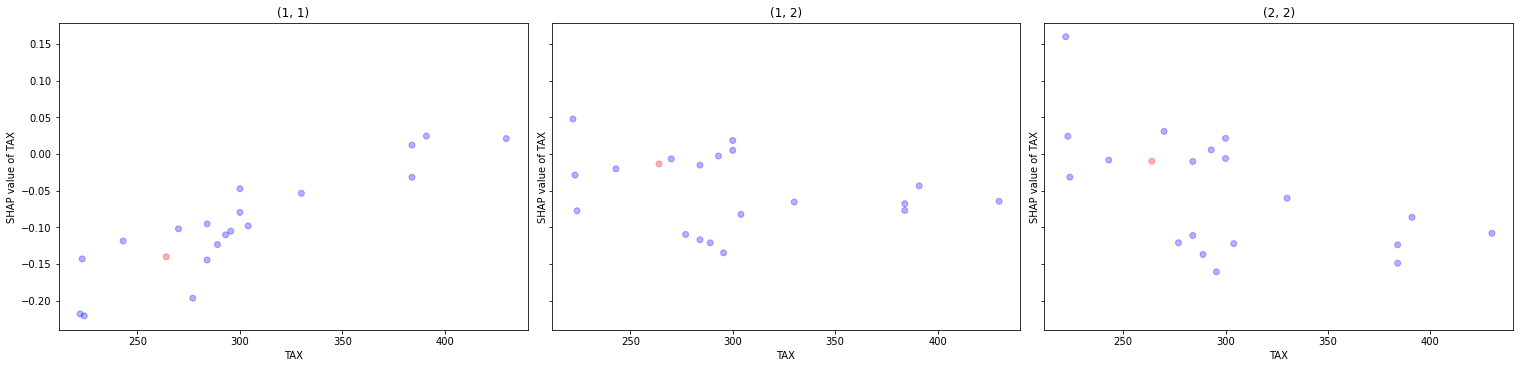

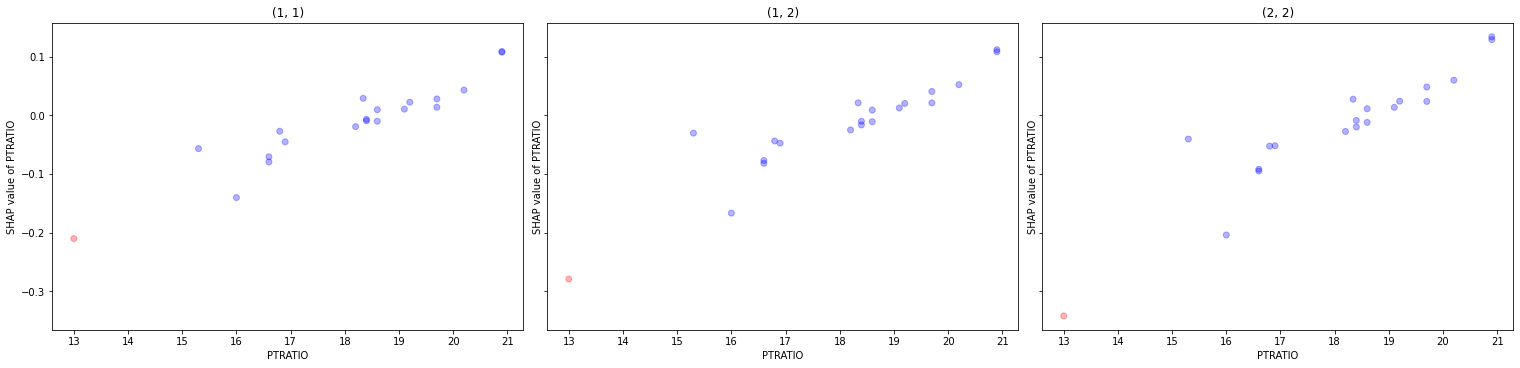

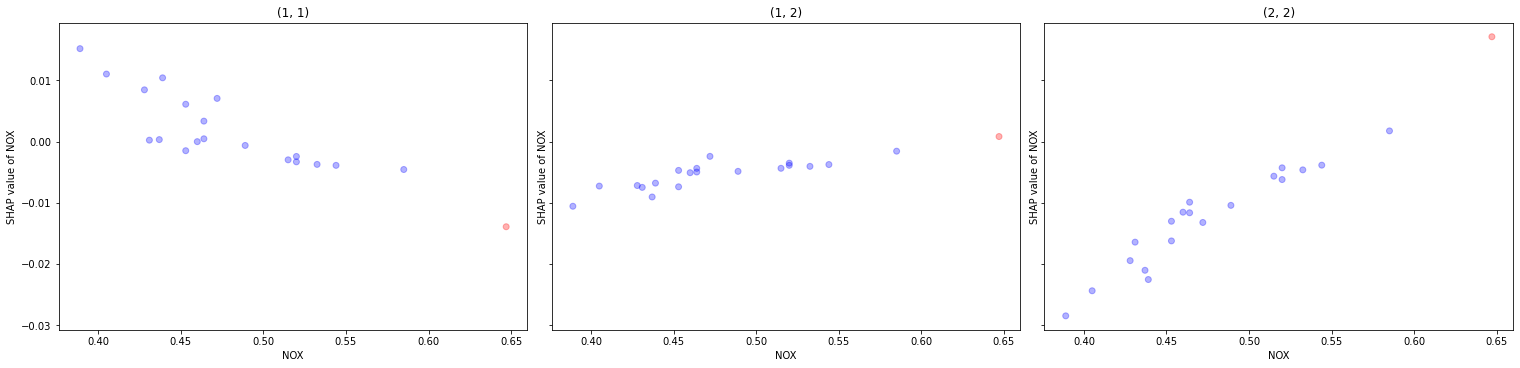

In [84]:
for feature in feature_order:
    clustering.plot_feature(feature, alpha=0.3)

In [91]:
clustering.test(LSTAT=9.4)

before  after
(1, 2)     1.0    NaN
(2, 2)     NaN    1.0

In [95]:
clustering.test(LSTAT=9.8)

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

### Cluster 2

In [96]:
clustering.get_next()

node #483 (level 3)
(1, 1)    26
(0, 0)     3
(0, 1)     2
(1, 2)     1
(2, 2)     1
dtype: int64
node #479 (level 4)
(1, 1)    8
(0, 0)    3
(0, 1)    2
dtype: int64


In [97]:
clustering.get_next()

node #483 (level 3)
(1, 1)    26
(0, 0)     3
(0, 1)     2
(1, 2)     1
(2, 2)     1
dtype: int64
node #485 (level 2)
(1, 1)    32
(0, 0)     3
(0, 1)     3
(2, 2)     1
(1, 2)     1
dtype: int64
node #489 (level 1)
(2, 2)    96
(1, 1)    47
(1, 2)     5
(0, 0)     3
(0, 1)     3
(2, 1)     2
dtype: int64
node #488 (level 2)
(2, 2)    95
(1, 1)    15
(1, 2)     4
(2, 1)     2
dtype: int64


Cluster characteristics:
- LSTAT < 10.0
- INDUS < 19.6
- CRIM < 9.3 (not relevant)

Differences:
- 5.4 < LSTAT < 7.9
- 60 ≤ ZN ≤ 90
- INDUS < 4.2
- CRIM < 0.2
- 5.9 < RM < 7.1
- RAD ≤ 4
- 285 ≤ TAX ≤ 411
- 7.3 < DIS

Counterfactuals:
- $LSTAT=11.6 \rightarrow (1,1)$
- $LSTAT=3.5 \rightarrow (2,2)$

In [106]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

LSTAT


global   local-all  local-diff
count  246.000000  116.000000    4.000000
mean    11.736981    5.302725    6.317500
std      7.372550    2.024459    1.094513
min      1.763949    1.763949    5.490000
25%      5.008267    3.648777    5.550000
50%      9.950000    4.726692    5.965000
75%     17.091674    6.873637    6.732500
max     36.980000    9.930000    7.850000

ZN


global   local-all  local-diff
count  246.000000  116.000000    4.000000
mean    12.841063   23.404323   78.750000
std     25.552540   32.175624   13.149778
min      0.000000    0.000000   60.000000
25%      0.000000    0.000000   75.000000
50%      0.000000    0.394834   82.500000
75%     20.000000   30.895715   86.250000
max    100.000000  100.000000   90.000000

INDUS


global   local-all  local-diff
count  246.000000  116.000000    4.000000
mean    11.718208    7.548647    2.680000
std      7.290396    6.280044    1.128125
min      1.210000    1.210000    1.690000
25%      4.243588    2.950000    1.855000
50%      9.900000    4.766059    2.440000
75%     18.100000   11.930000    3.265000
max     25.650000   19.580000    4.150000

CRIM


global   local-all  local-diff
count  246.000000  116.000000    4.000000
mean     2.720010    1.355068    0.053463
std      6.388147    2.579150    0.047189
min      0.009060    0.009060    0.009060
25%      0.099321    0.054806    0.016290
50%      0.540032    0.208679    0.049100
75%      3.181873    0.627982    0.086273
max     73.534100    9.232300    0.106590

RM


global   local-all  local-diff
count  246.000000  116.000000    4.000000
mean     6.511388    7.168639    6.529750
std      0.889747    0.774975    0.471451
min      3.561000    3.561000    5.936000
25%      5.882000    6.632066    6.371000
50%      6.315500    7.229624    6.547500
75%      7.134552    7.759307    6.706250
max      8.638029    8.638029    7.088000

RAD


global   local-all  local-diff
count  246.000000  116.000000        4.00
mean     9.346908    7.466550        3.25
std      8.493772    7.091125        1.50
min      1.000000    1.000000        1.00
25%      4.000000    3.839236        3.25
50%      5.000000    5.000000        4.00
75%      8.000000    8.000000        4.00
max     24.000000   24.000000        4.00

TAX


global   local-all  local-diff
count  246.000000  116.000000    4.000000
mean   403.132604  342.452148  345.250000
std    165.416533  147.294951   52.002404
min    188.000000  193.000000  285.000000
25%    273.000000  243.750000  321.750000
50%    362.186013  289.216125  342.500000
75%    461.000000  398.000000  366.000000
max    679.526743  666.000000  411.000000

AGE


global   local-all  local-diff
count  246.000000  116.000000         4.0
mean     1.304878    0.931034         0.0
std      0.813494    0.831177         0.0
min      0.000000    0.000000         0.0
25%      1.000000    0.000000         0.0
50%      2.000000    1.000000         0.0
75%      2.000000    2.000000         0.0
max      2.000000    2.000000         0.0

DIS


global   local-all  local-diff
count  246.000000  116.000000    4.000000
mean     3.501706    4.082334    9.284650
std      2.007156    2.197546    1.652942
min      1.137912    1.137912    7.307300
25%      1.967365    2.120615    8.228300
50%      2.866600    3.560553    9.560500
75%      4.621654    5.548544   10.616850
max     10.710300   10.710300   10.710300

PTRATIO


global   local-all  local-diff
count  246.000000  116.000000    4.000000
mean    18.125578   17.132943   18.375000
std      2.524334    2.354784    2.758472
min     13.000000   13.000000   15.300000
25%     15.707491   15.093651   17.250000
50%     18.571912   17.400000   18.100000
75%     20.200000   18.739478   19.225000
max     22.000000   22.000000   22.000000

NOX


global   local-all  local-diff
count  246.000000  116.000000    4.000000
mean     0.572581    0.514599    0.413250
std      0.125307    0.096053    0.011955
min      0.389000    0.394000    0.400000
25%      0.462112    0.437000    0.408250
50%      0.544000    0.490500    0.412000
75%      0.638740    0.605000    0.417000
max      0.871000    0.871000    0.429000

In [126]:
clustering.test(LSTAT=11.6)

before  after
(1, 1)     NaN    4.0
(1, 2)     4.0    NaN

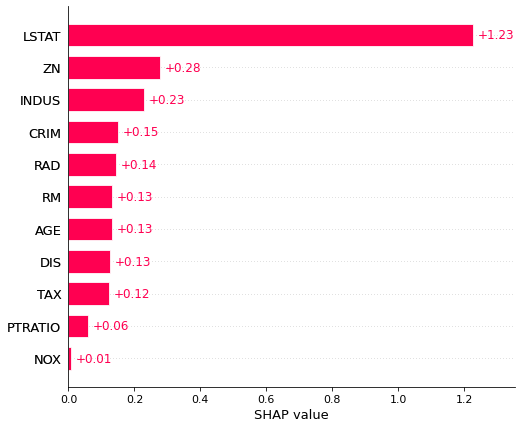

In [107]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

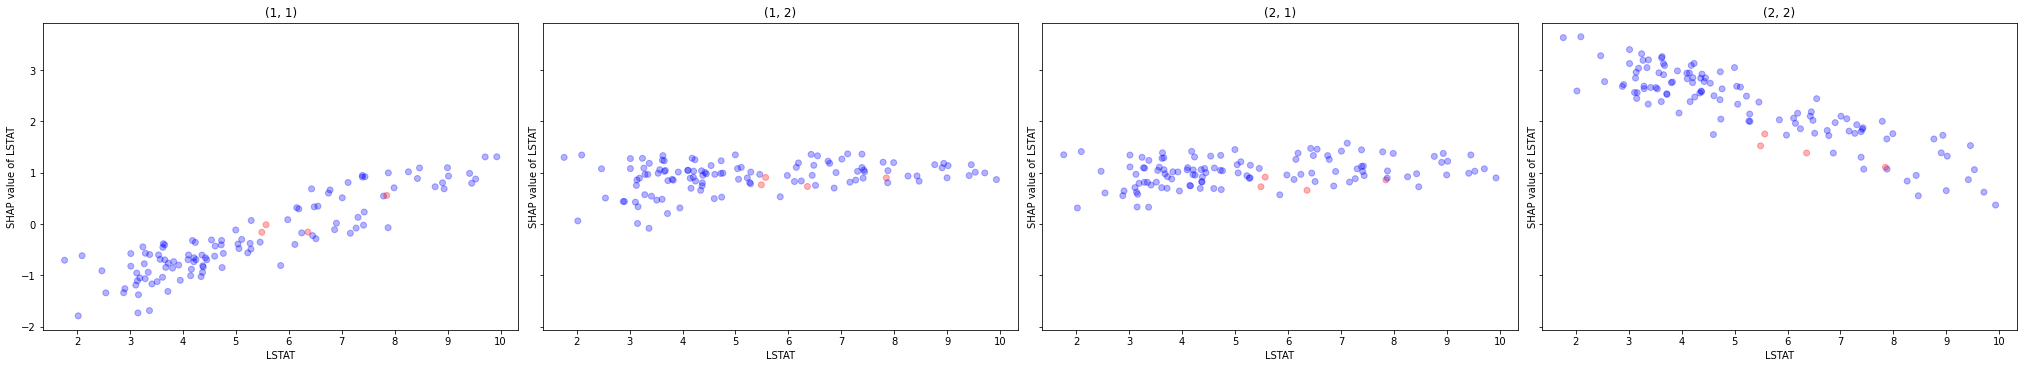

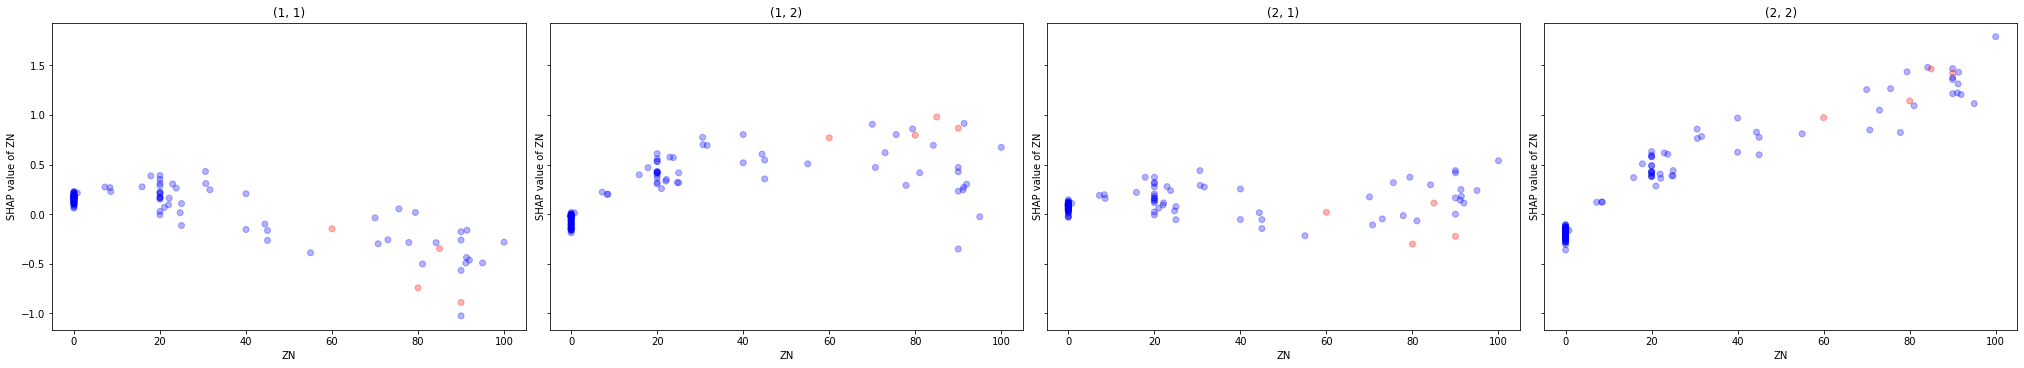

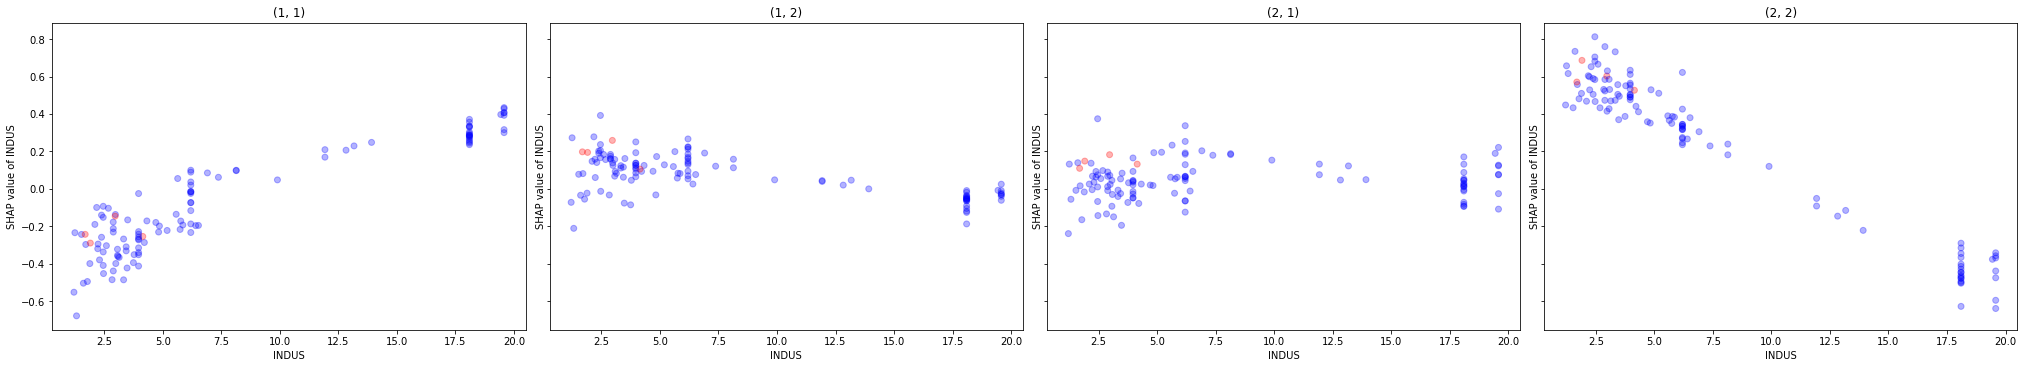

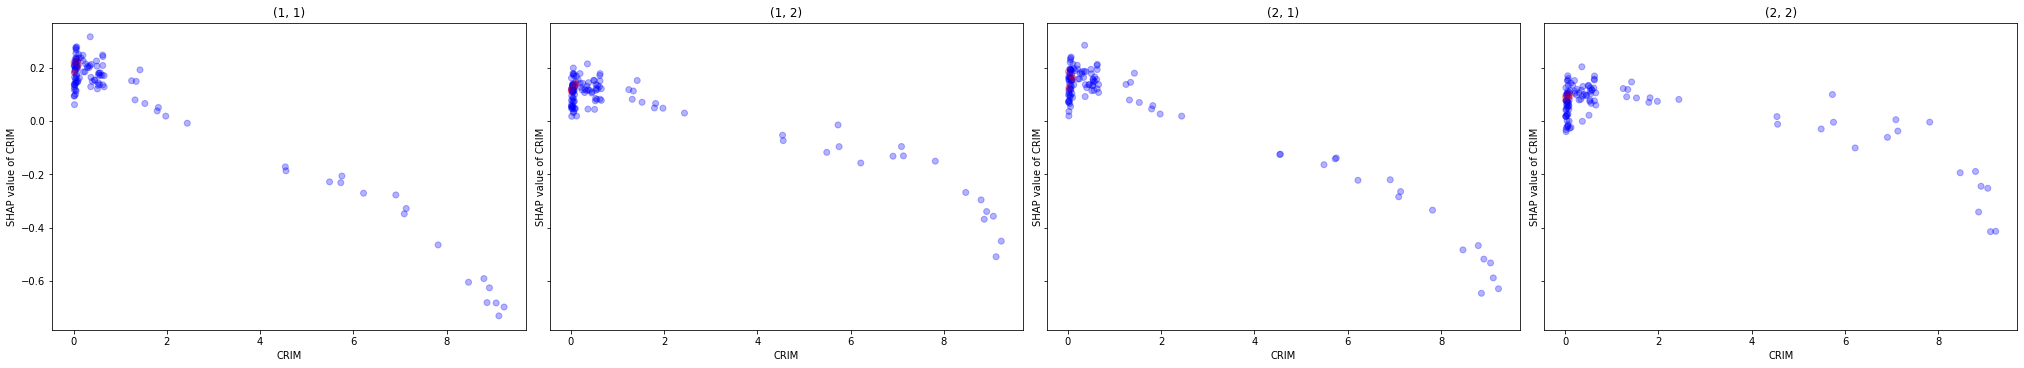

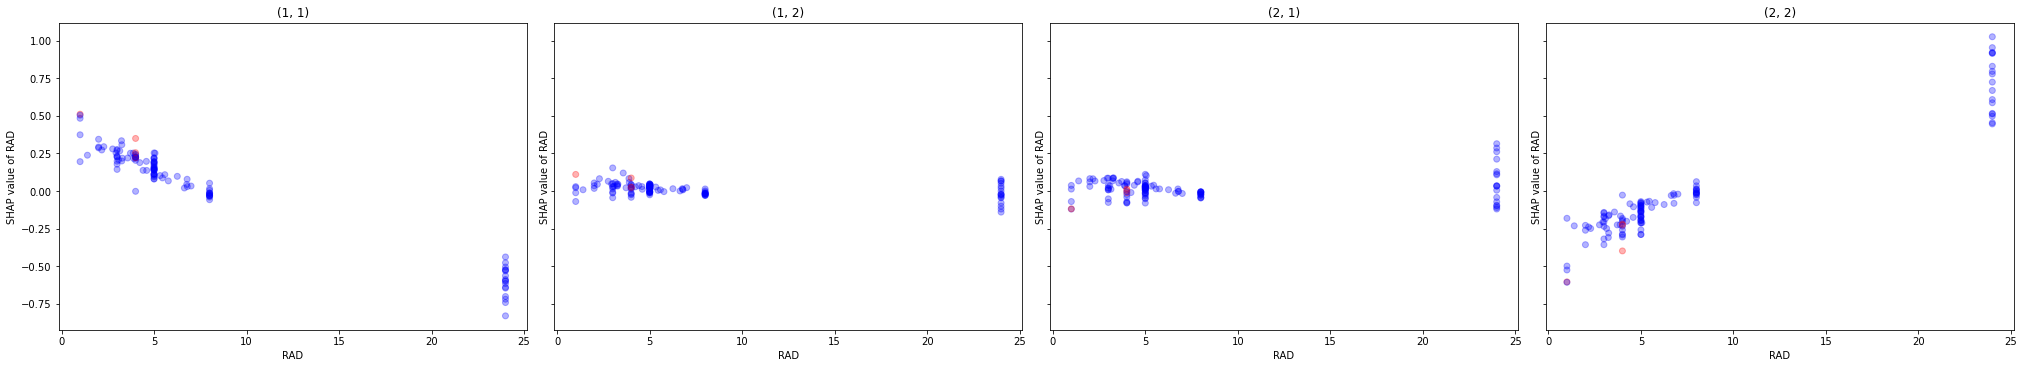

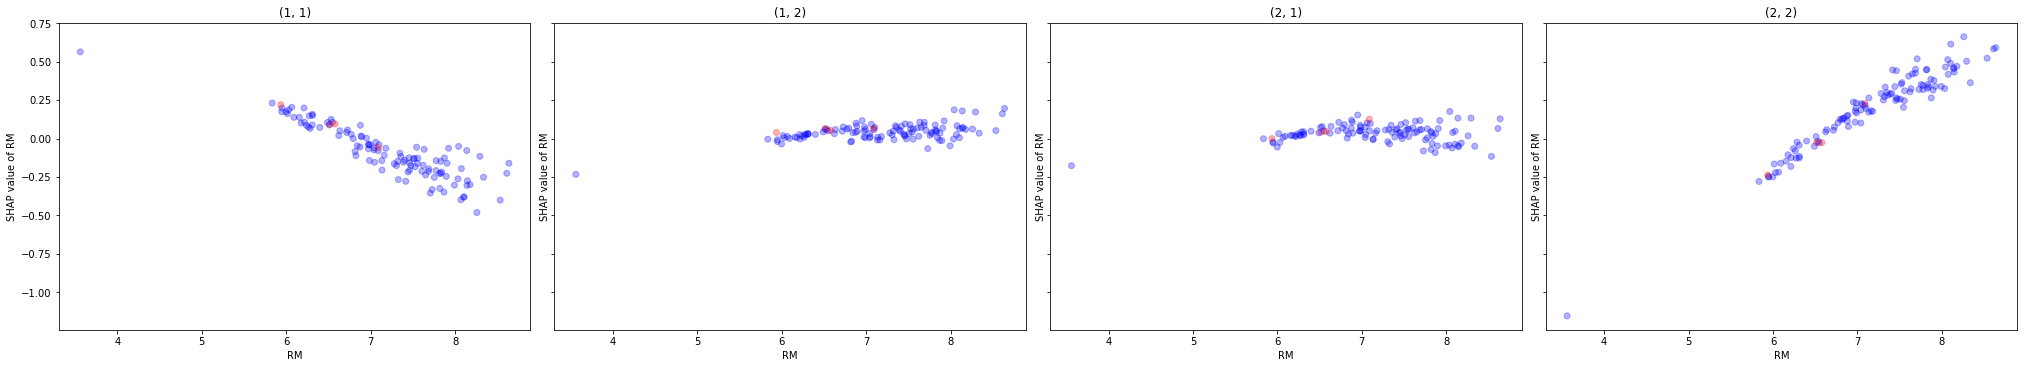

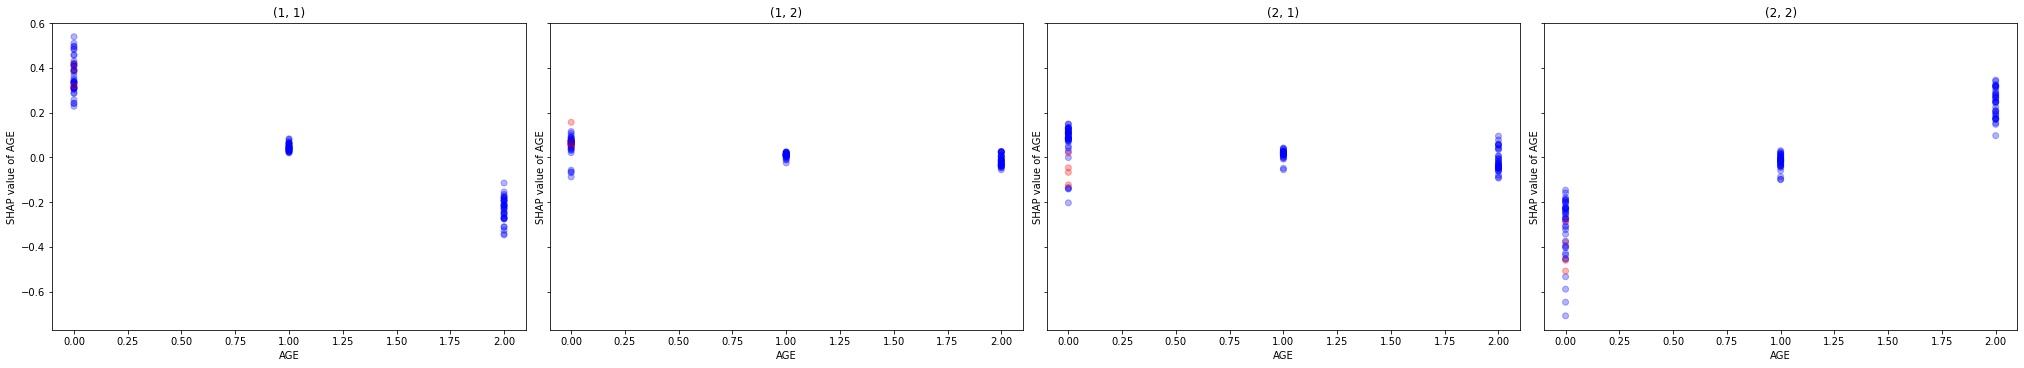

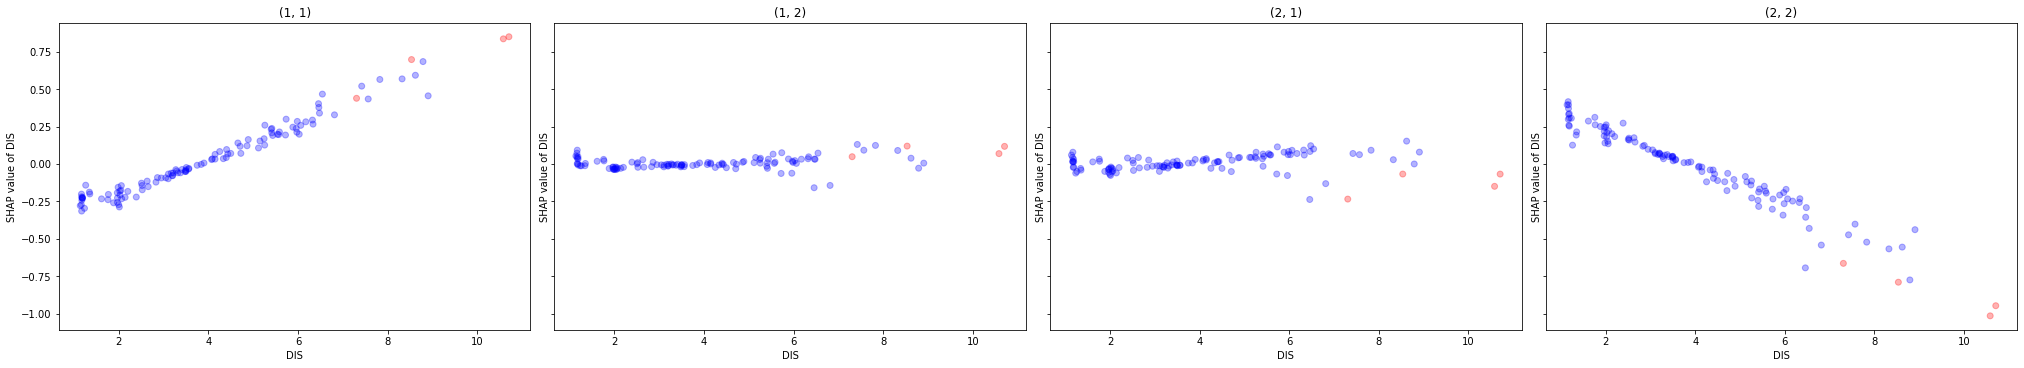

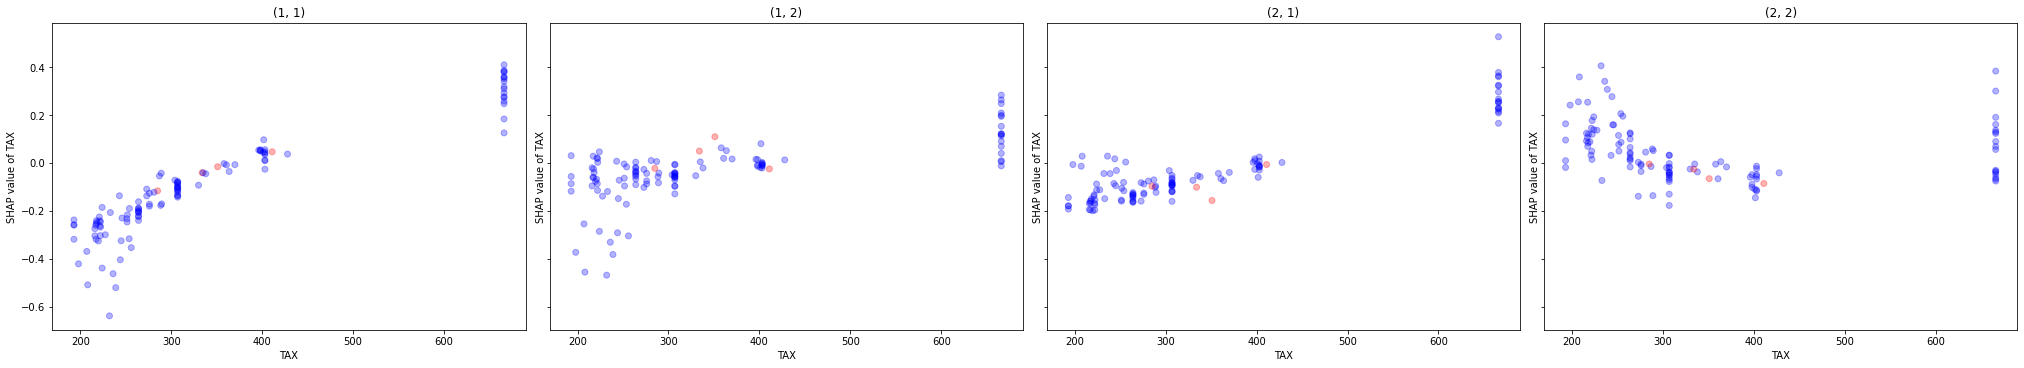

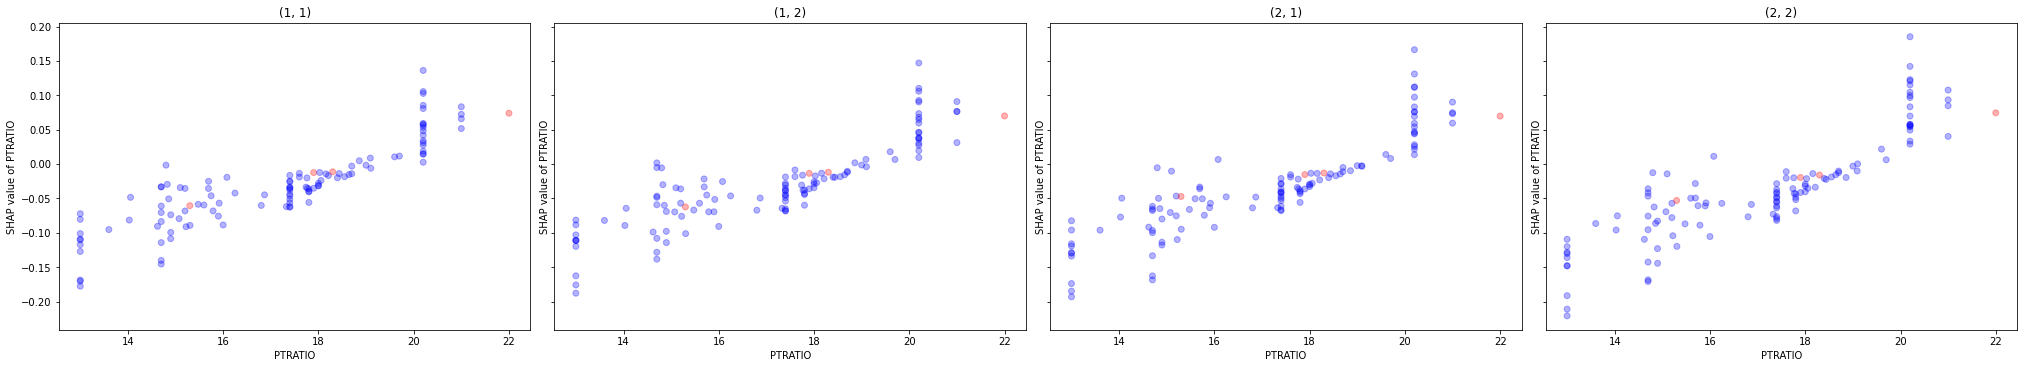

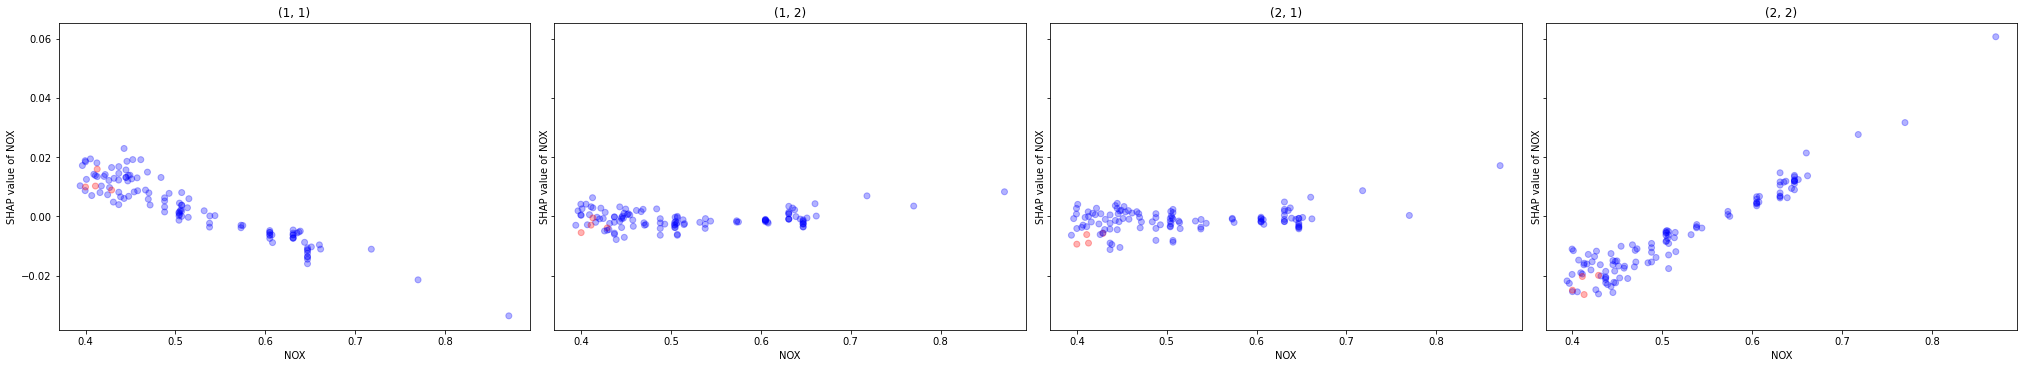

In [108]:
for feature in feature_order:
    clustering.plot_feature(feature, alpha=0.3)

In [116]:
clustering.test(LSTAT=3.5)

before  after
(1, 2)     4.0    NaN
(2, 2)     NaN    4.0

In [120]:
clustering.test(LSTAT=9.9)

before  after
(1, 1)     NaN      3
(1, 2)     4.0      1

## Clustering of (2,1) SHAP Values

In [11]:
clustering = make_clustering(comparer, explanations.mclass_diff.log_odds, '(2, 1)', '(1, 1)', '(2, 2)')

node #490 (level 0)
(2, 2)    96
(0, 0)    86
(1, 1)    52
(1, 2)     5
(0, 1)     3
(2, 1)     2
(1, 0)     2
dtype: int64


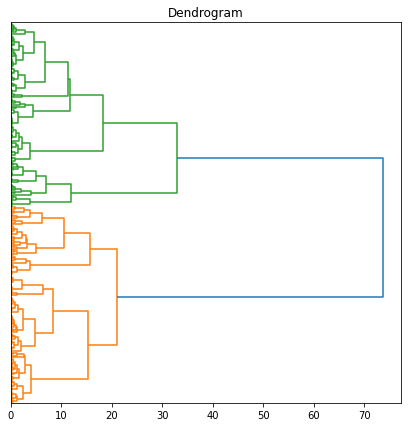

In [12]:
clustering.plot_dendrogram()

In [13]:
clustering.go_down()

node #488 (level 1)
(2, 2)    96
(1, 1)    24
(1, 2)     5
(2, 1)     2
dtype: int64


Cluster characteristics:
- LSTAT < 10.9
- INDUS < 19.6
- CRIM < 9.3

Differences:
- 6.4 < LSTAT < 7.2
- ZN = 0
- 11.9 < INDUS < 18.2
- CRIM < 4.6 
- RM < 6.8
- 273 ≤ TAX
- AGE = 2
- 1.6 < DIS < 2.4
- 20.2 ≤ PTRATIO (not relevant)

Counterfactuals:
- $LSTAT=7.5 \rightarrow (1,1)$
- $LSTAT=6.0 \rightarrow (2,2)$

In [14]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

LSTAT


global   local-all  local-diff
count  246.000000  127.000000    2.000000
mean    11.736981    5.681719    6.800000
std      7.372550    2.304218    0.452548
min      1.763949    1.763949    6.480000
25%      5.008267    3.696082    6.640000
50%      9.950000    5.058243    6.800000
75%     17.091674    7.401020    6.960000
max     36.980000   10.870000    7.120000

ZN


global   local-all  local-diff
count  246.000000  127.000000         2.0
mean    12.841063   23.003161         0.0
std     25.552540   31.336797         0.0
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    0.789668         0.0
75%     20.000000   31.135970         0.0
max    100.000000  100.000000         0.0

INDUS


global   local-all  local-diff
count  246.000000  127.000000    2.000000
mean    11.718208    7.424985   15.015000
std      7.290396    6.105684    4.362849
min      1.210000    1.210000   11.930000
25%      4.243588    2.974898   13.472500
50%      9.900000    4.860000   15.015000
75%     18.100000   10.245000   16.557500
max     25.650000   19.580000   18.100000

CRIM


global   local-all  local-diff
count  246.000000  127.000000    2.000000
mean     2.720010    1.249983    2.332730
std      6.388147    2.488160    3.143995
min      0.009060    0.009060    0.109590
25%      0.099321    0.054255    1.221160
50%      0.540032    0.136420    2.332730
75%      3.181873    0.619624    3.444300
max     73.534100    9.232300    4.555870

RM


global   local-all  local-diff
count  246.000000  127.000000    2.000000
mean     6.511388    7.097899    5.177500
std      0.889747    0.784680    2.286076
min      3.561000    3.561000    3.561000
25%      5.882000    6.523870    4.369250
50%      6.315500    7.100179    5.177500
75%      7.134552    7.697315    5.985750
max      8.638029    8.638029    6.794000

RAD


global   local-all  local-diff
count  246.000000  127.000000    2.000000
mean     9.346908    7.229290   12.500000
std      8.493772    6.838406   16.263456
min      1.000000    1.000000    1.000000
25%      4.000000    3.948168    6.750000
50%      5.000000    5.000000   12.500000
75%      8.000000    7.000000   18.250000
max     24.000000   24.000000   24.000000

TAX


global   local-all  local-diff
count  246.000000  127.000000    2.000000
mean   403.132604  337.436608  469.500000
std    165.416533  142.549248  277.892965
min    188.000000  193.000000  273.000000
25%    273.000000  243.500000  371.250000
50%    362.186013  289.000000  469.500000
75%    461.000000  397.089921  567.750000
max    679.526743  666.000000  666.000000

AGE


global   local-all  local-diff
count  246.000000  127.000000         2.0
mean     1.304878    0.881890         2.0
std      0.813494    0.822445         0.0
min      0.000000    0.000000         2.0
25%      1.000000    0.000000         2.0
50%      2.000000    1.000000         2.0
75%      2.000000    2.000000         2.0
max      2.000000    2.000000         2.0

DIS


global   local-all  local-diff
count  246.000000  127.000000    2.000000
mean     3.501706    4.184753    2.001050
std      2.007156    2.193218    0.548503
min      1.137912    1.137912    1.613200
25%      1.967365    2.294509    1.807125
50%      2.866600    3.838400    2.001050
75%      4.621654    5.577023    2.194975
max     10.710300   10.710300    2.388900

PTRATIO


global   local-all  local-diff
count  246.000000  127.000000    2.000000
mean    18.125578   17.144263   20.600000
std      2.524334    2.325144    0.565685
min     13.000000   13.000000   20.200000
25%     15.707491   15.200000   20.400000
50%     18.571912   17.400000   20.600000
75%     20.200000   18.700000   20.800000
max     22.000000   22.000000   21.000000

In [16]:
clustering.test(LSTAT=10.9)

before  after
(1, 1)     NaN    2.0
(2, 1)     2.0    NaN

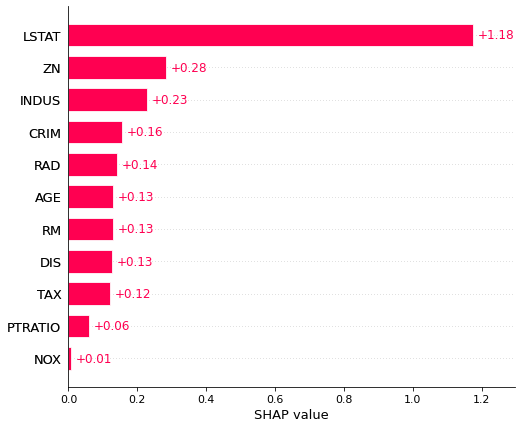

In [17]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

In [22]:
clustering.test(LSTAT=6.0)

before  after
(2, 1)     2.0    NaN
(2, 2)     NaN    2.0

In [26]:
clustering.test(LSTAT=7.5)

before  after
(1, 1)     NaN    2.0
(2, 1)     2.0    NaN

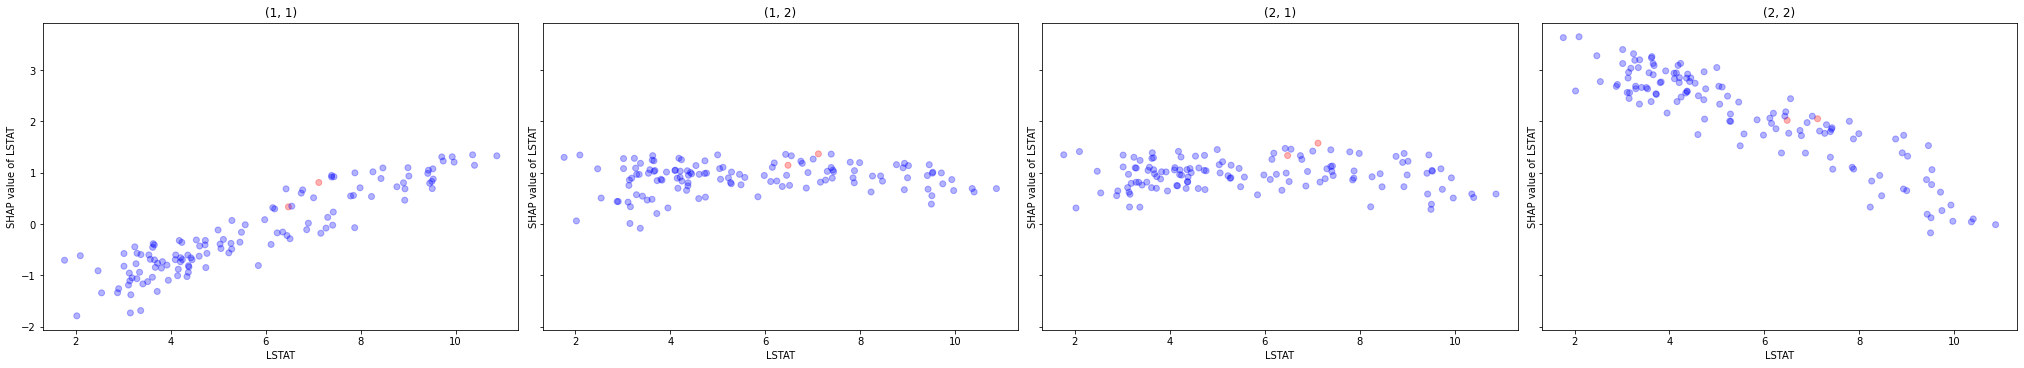

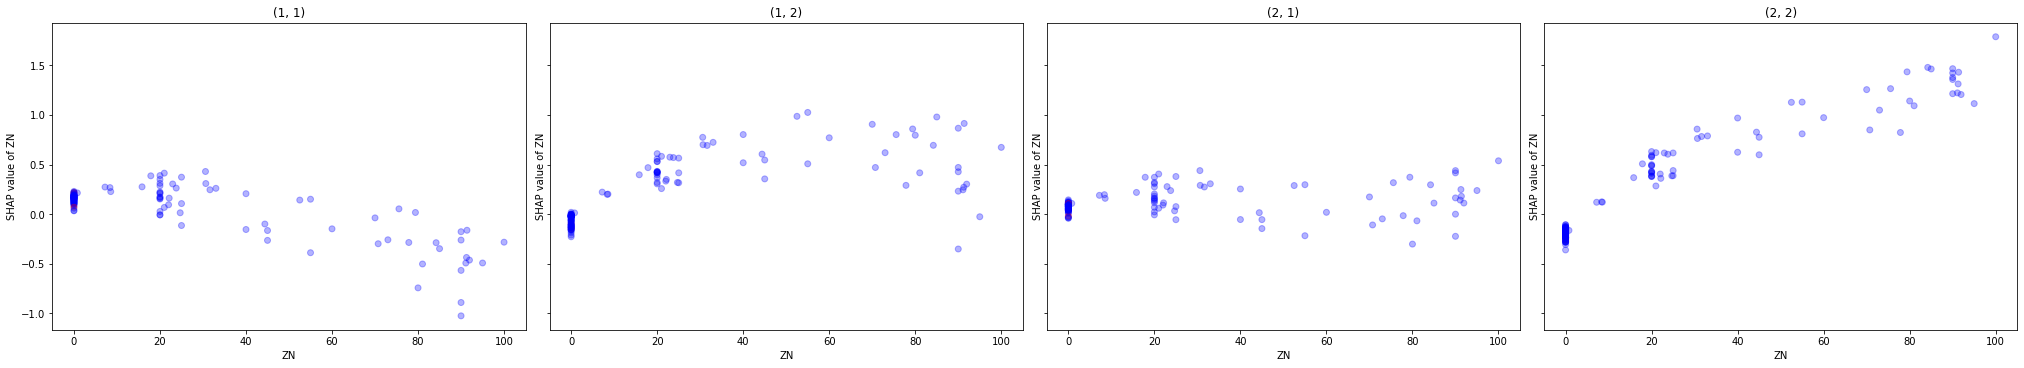

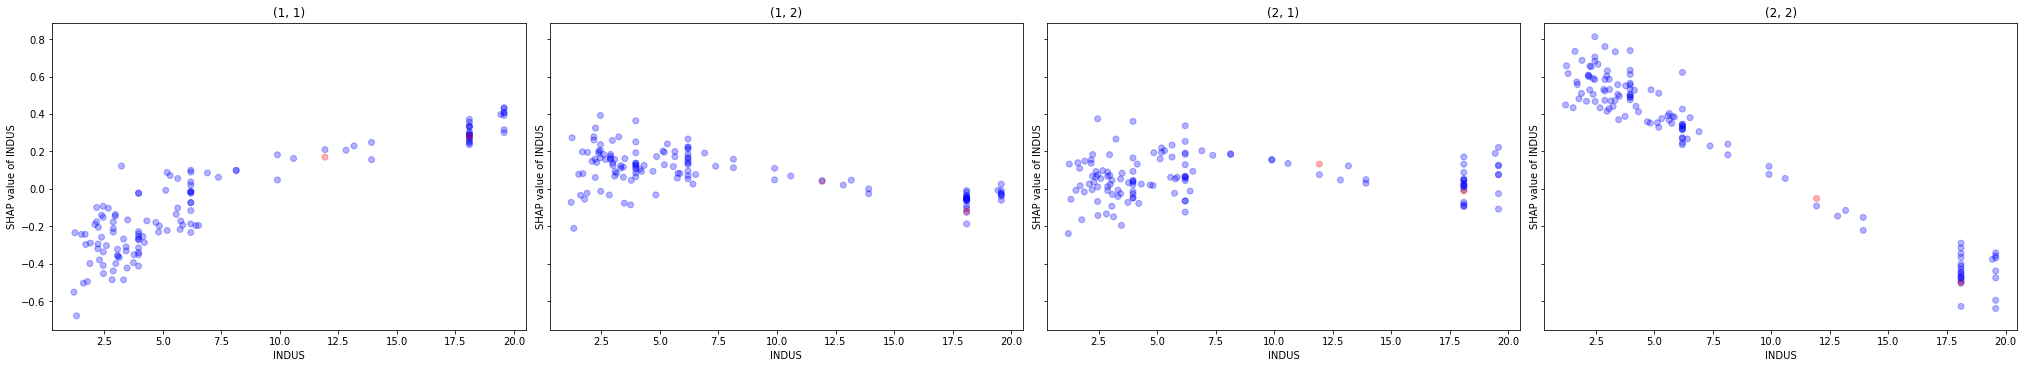

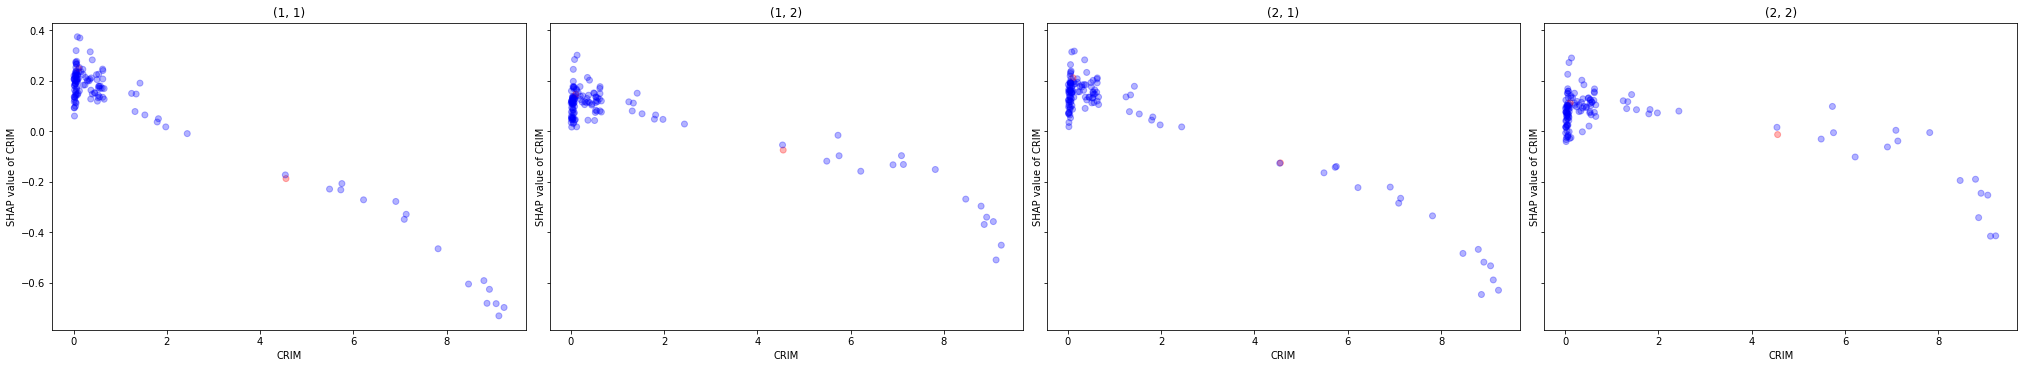

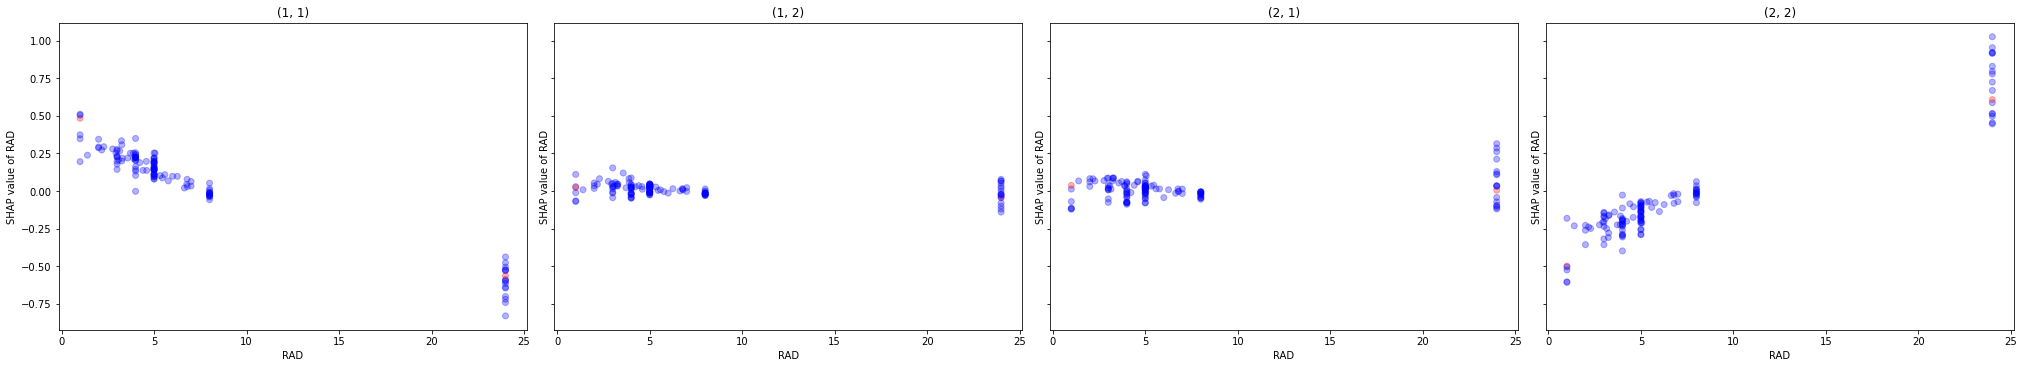

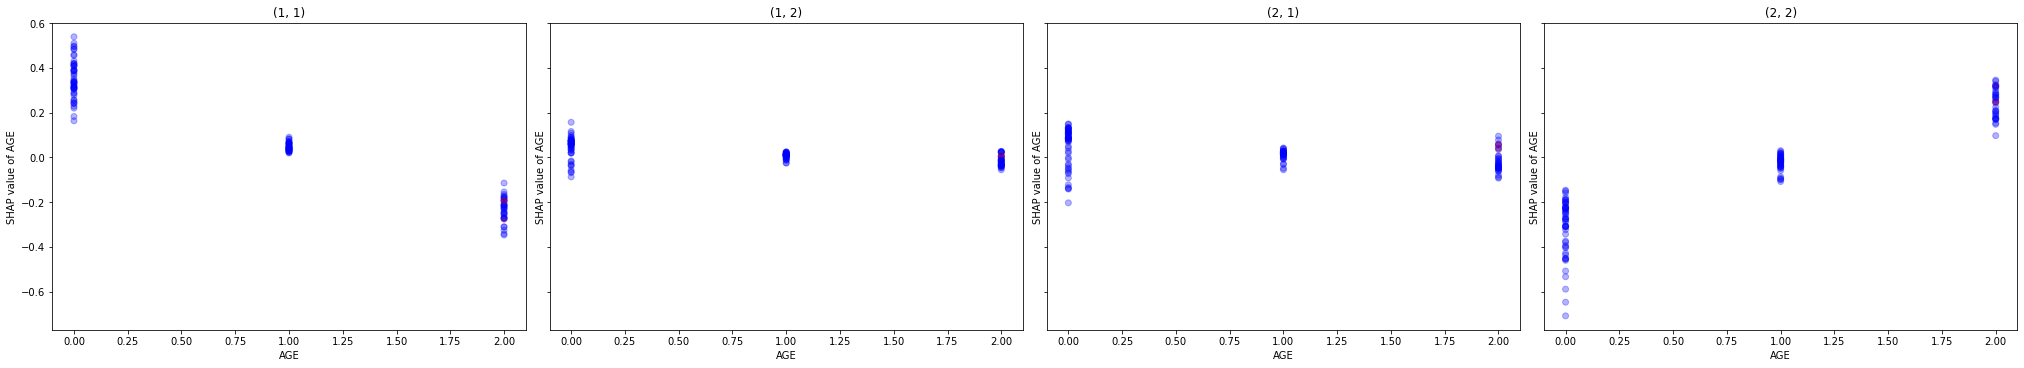

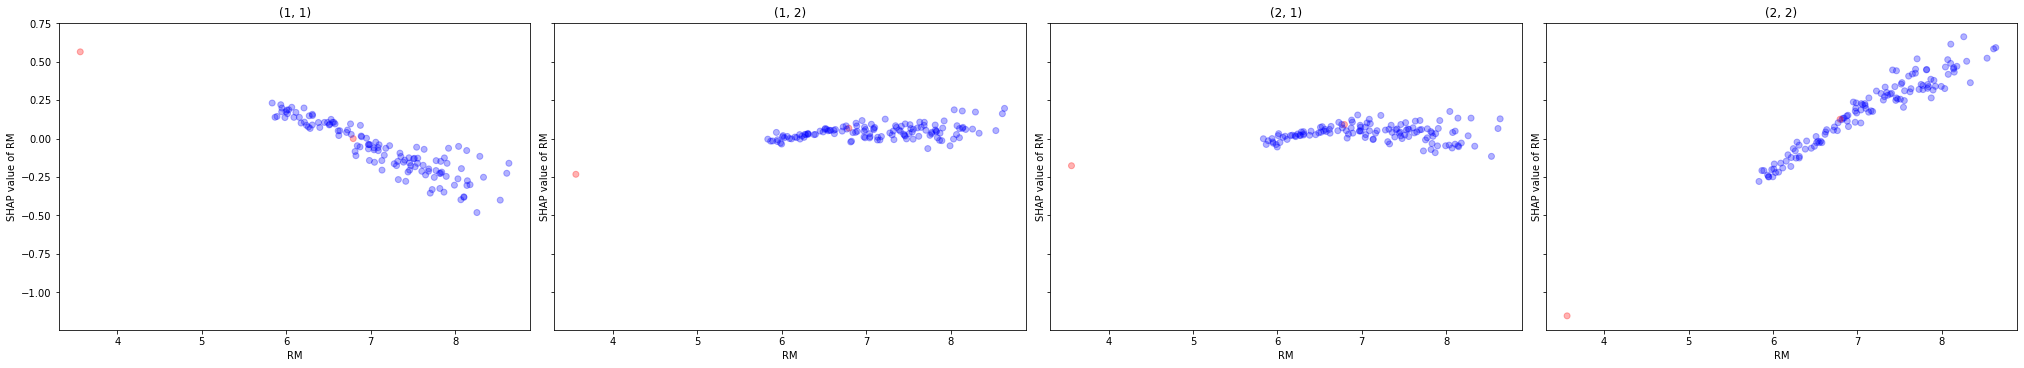

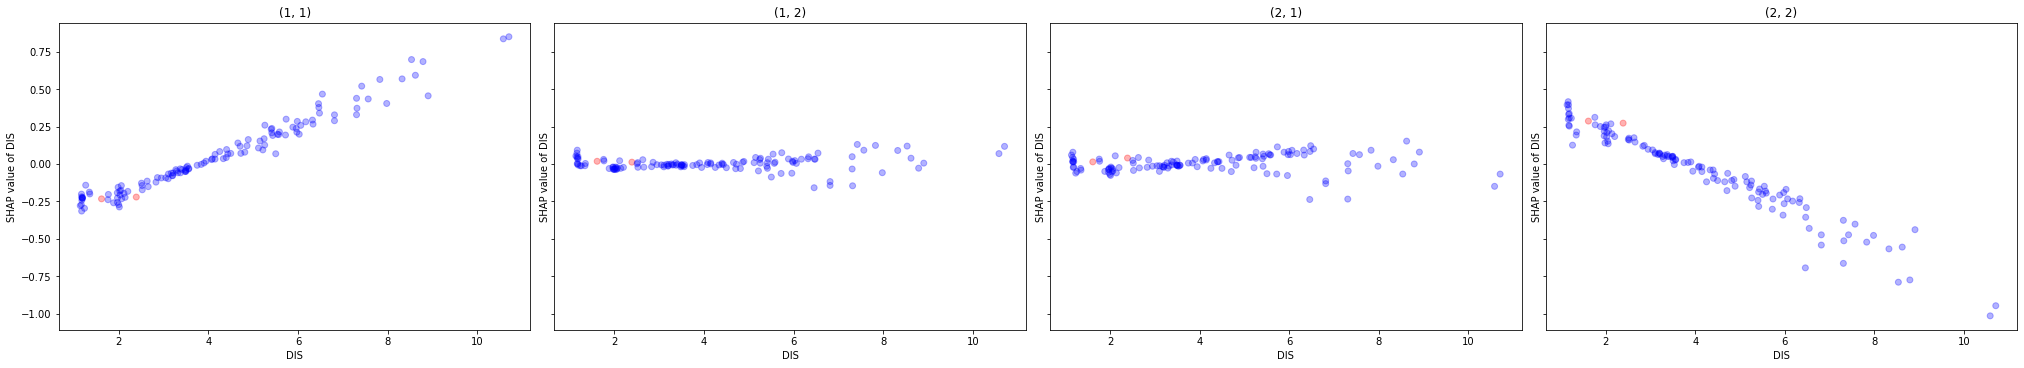

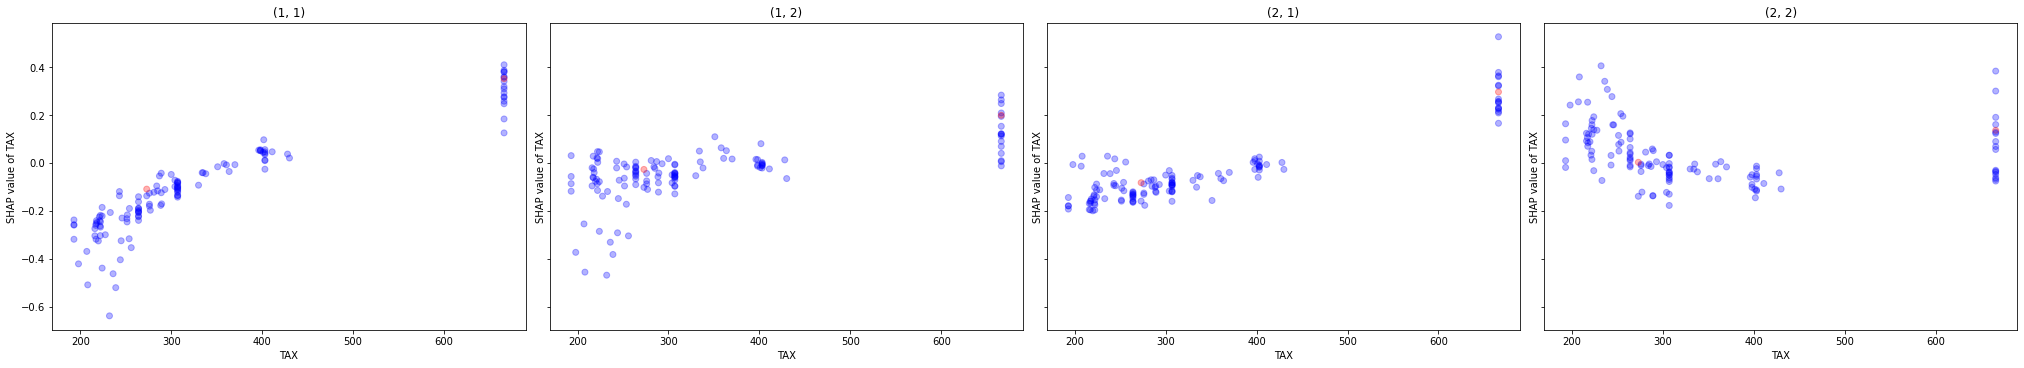

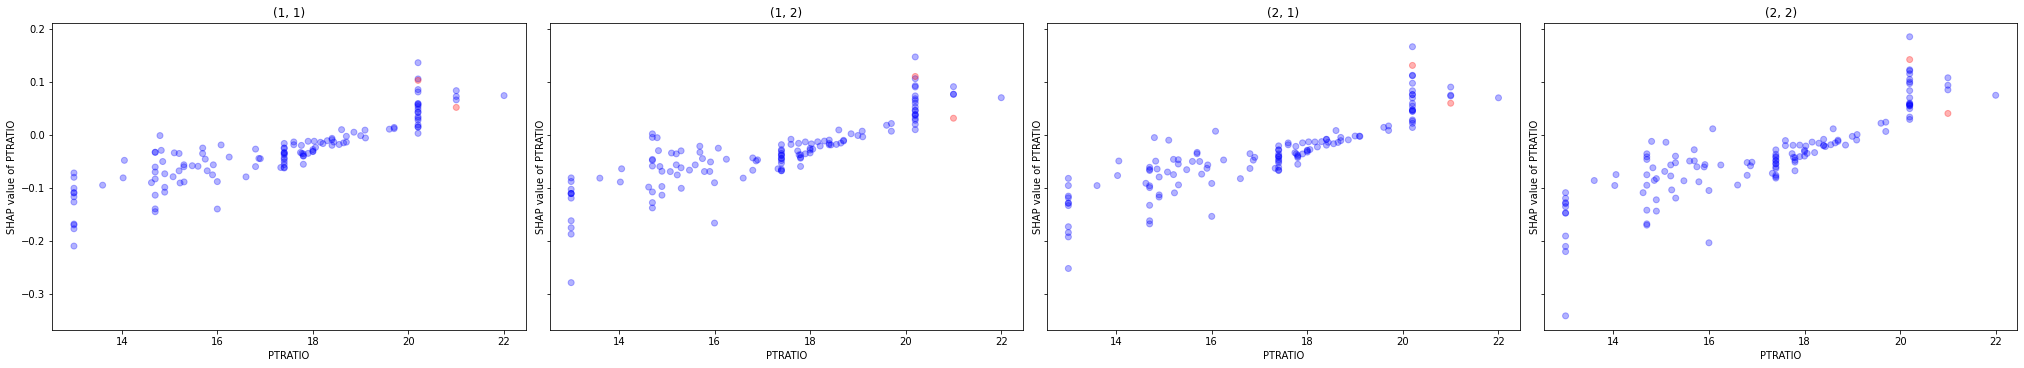

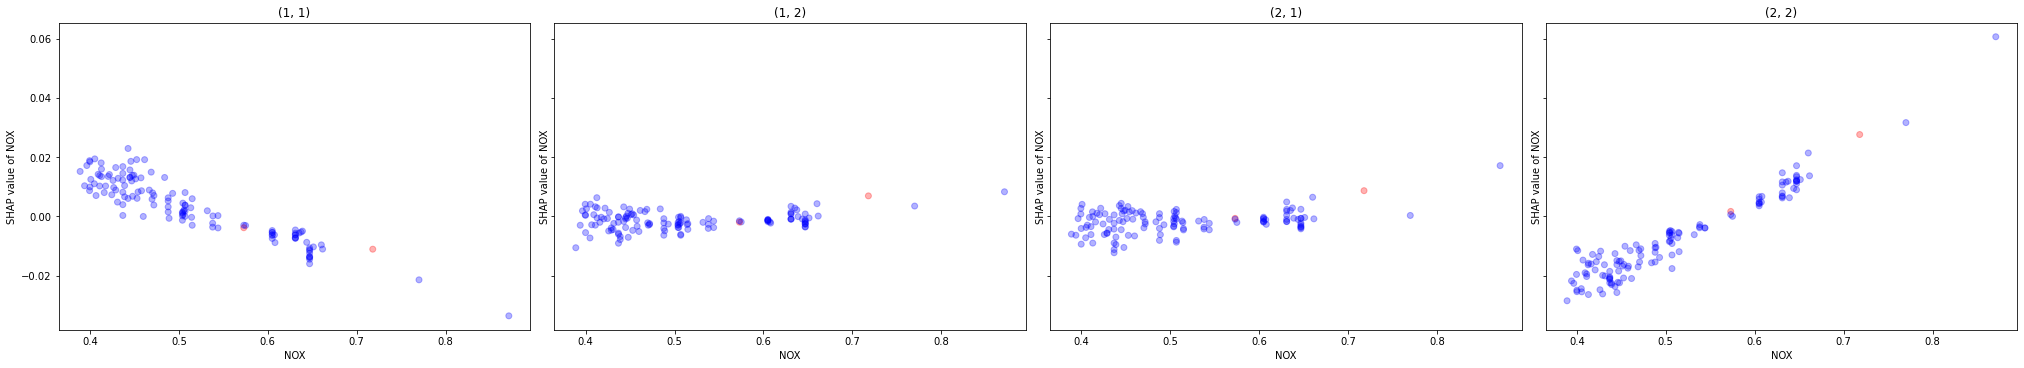

In [18]:
for feature in feature_order:
    clustering.plot_feature(feature, alpha=0.3)